# Lecture 21 - Computer Vision

```{contents}
:local:
:depth: 1
```

## Learning goals
- Build and train compact **convolutional neural networks** with PyTorch.
- Track learning curves, compute key metrics, and inspect sample predictions
- Visualize learned filters and intermediate feature maps.

 [![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1VP9tfiiBU8e40iG3qaQlCefkkofVbXiT?usp=sharing) 

Suggested reading for this section: https://poloclub.github.io/cnn-explainer/

## 1. Setup

In [1]:
#pip install torch torchvision torchaudio matplotlib scikit-learn onnx onnxruntime opencv-python tqdm
# 0. setup
import os, random, math, random, requests, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import seaborn as sns

## 2. CNN Model for MNIST

We start with a quick MNIST (Modified National Institute of Standards and Technology database) pipeline to anchor the core ideas. This section fixes random seeds for reproducibility, picks a device, and applies the standard MNIST normalization.

We then load train and test splits, create `DataLoaders`, and show a small gallery to confirm images and labels look correct.

Device: cpu


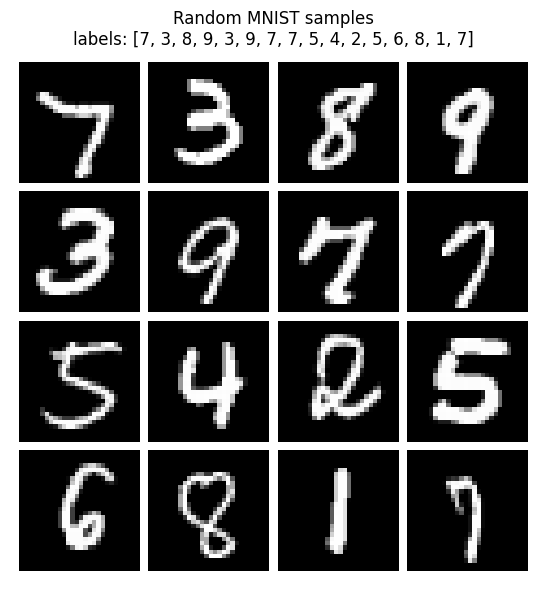

In [2]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transform pipeline:
# 1) convert to tensor in [0,1]
# 2) normalize with MNIST mean and std; helps training stability

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

root = "./data"
train_set = datasets.MNIST(root=root, train=True, download=True, transform=tfm)
test_set  = datasets.MNIST(root=root, train=False, download=True, transform=tfm)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

# Show 16 random samples
def show_samples(ds, n=16, save_path="samples.png"):
    idxs = np.random.choice(len(ds), size=n, replace=False)
    imgs = [ds[i][0] for i in idxs]
    labels = [int(ds[i][1]) for i in idxs]
    grid = vutils.make_grid(torch.stack(imgs), nrow=int(n**0.5), normalize=True, pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.title(f"Random MNIST samples\nlabels: {labels}")
    plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.tight_layout()
    plt.show()            # also writes if you prefer: plt.savefig(save_path)
show_samples(train_set)

Each MNIST image is mostly dark, with a few bright pixels forming the digit.
When all images are combined, their average brightness is about *0.1307*, and how much they vary from that average (the spread) is about *0.3081*.

We use these numbers to normalize every image so the data is centered around zero.

This helps the later CNN train faster and stay stable.

Below, you can see one image before and after normalization.

MNIST mean: 0.1307, std: 0.3081


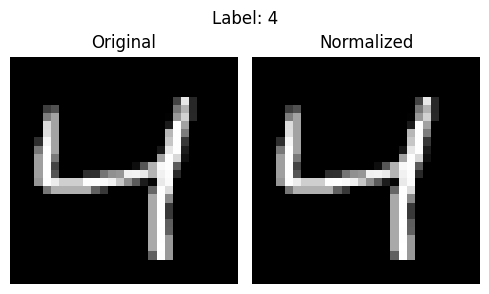

First 20 pixel values (original): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
First 20 pixel values (normalized): [-0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984]


In [3]:
# Compute MNIST mean and std
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img for img, _ in mnist])
mean, std = imgs.mean().item(), imgs.std().item()
print(f"MNIST mean: {mean:.4f}, std: {std:.4f}")

# Create raw and normalized datasets
raw_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
norm_ds = datasets.MNIST(root="./data", train=True, download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((mean,), (std,))
                         ]))

# Pick one sample
idx = 2
img_raw, label = raw_ds[idx]
img_norm, _ = norm_ds[idx]

# Convert to numpy
raw_arr = img_raw.squeeze().numpy()
norm_arr = img_norm.squeeze().numpy()

# Show side by side
plt.figure(figsize=(5,3))
plt.subplot(1,2,1); plt.imshow(raw_arr, cmap="gray"); plt.axis("off"); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(norm_arr, cmap="gray"); plt.axis("off"); plt.title("Normalized")
plt.suptitle(f"Label: {label}")
plt.tight_layout(); plt.show()

# Print first 20 pixel values
print("First 20 pixel values (original):", np.round(raw_arr.flatten()[:20], 3).tolist())
print("First 20 pixel values (normalized):", np.round(norm_arr.flatten()[:20], 3).tolist())

Here we define a compact `CNN`: two conv blocks with ReLU and max-pool, then a small MLP head. Dropout helps when the model begins to memorize digits. The spatial path is `28→14→7`, which is why the first linear layer expects `64×7×7` features. The printed parameter count is a quick sanity check that the model is small enough to train in minutes.

In [4]:
# Model development
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First conv block: increase channels from 1 to 32
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # preserves 28x28
        # Second conv block: 32 -> 64 channels
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # preserves 14x14 after pooling
        self.pool = nn.MaxPool2d(2, 2)                # halves width and height
        self.drop = nn.Dropout(0.25)                  # regularization to reduce overfitting
        # After two pools: 28 -> 14 -> 7 so feature map is 64x7x7
        self.fc1  = nn.Linear(64*7*7, 128)            # dense layer for abstraction
        self.fc2  = nn.Linear(128, 10)                # 10 digits

    def forward(self, x):
        # Block 1: conv + ReLU + pool
        x = self.pool(F.relu(self.conv1(x)))          # 1x28x28 -> 32x14x14
        # Block 2: conv + ReLU + pool
        x = self.pool(F.relu(self.conv2(x)))          # 32x14x14 -> 64x7x7
        # Flatten features for linear layers
        x = x.view(x.size(0), -1)
        # Hidden layer with dropout
        x = self.drop(F.relu(self.fc1(x)))
        # Output logits (no softmax here; handled by loss during training)
        return self.fc2(x)

model = Net().to(device)
print("Total parameters:", f"{sum(p.numel() for p in model.parameters()):,}")

Total parameters: 421,642


We train for a few epochs with Adam and cross-entropy. The loop zeros grads, runs forward, computes loss, calls backward, and steps the optimizer. The progress bar reports the latest batch loss, while the epoch average is logged after each pass. If loss is unstable, try a smaller LR such as 1e-3.

In [5]:
epochs = 2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Adam is a good default
criterion = nn.CrossEntropyLoss()                           # expects raw logits and int labels

train_losses, test_losses, test_accs = [], [], []

for epoch in range(1, epochs+1):
    # ---- Training loop ----
    model.train()
    running = 0.0                     # accumulate loss*batch_size for epoch average
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]")
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()         # clear previous gradients
        logits = model(x)             # forward pass
        loss = criterion(logits, y)   # compute loss
        loss.backward()               # backpropagate
        optimizer.step()              # update weights
        running += loss.item() * x.size(0)
        pbar.set_postfix(loss=loss.item())

    tr_loss = running / len(train_loader.dataset)
    train_losses.append(tr_loss)

    # ---- Evaluation loop (no grad) ----
    model.eval()                      # eval mode disables dropout
    te_running, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch}/{epochs} [eval]"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            te_running += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()

    te_loss = te_running / len(test_loader.dataset)
    te_acc  = correct / total
    test_losses.append(te_loss); test_accs.append(te_acc)

    print(f"Epoch {epoch}: train loss {tr_loss:.4f}  test loss {te_loss:.4f}  acc {te_acc:.4f}")

Epoch 1/2 [train]:   0%|                                                                           | 0/469 [00:00<?, ?it/s]

Epoch 1/2 [train]:   0%|                                                                | 0/469 [00:09<?, ?it/s, loss=2.31]

Epoch 1/2 [train]:   0%|                                                      | 1/469 [00:09<1:11:48,  9.21s/it, loss=2.31]

Epoch 1/2 [train]:   0%|                                                      | 1/469 [00:09<1:11:48,  9.21s/it, loss=6.55]

Epoch 1/2 [train]:   0%|                                                      | 1/469 [00:09<1:11:48,  9.21s/it, loss=2.34]

Epoch 1/2 [train]:   1%|▎                                                       | 3/469 [00:09<18:54,  2.43s/it, loss=2.34]

Epoch 1/2 [train]:   1%|▎                                                       | 3/469 [00:09<18:54,  2.43s/it, loss=2.28]

Epoch 1/2 [train]:   1%|▎                                                       | 3/469 [00:09<18:54,  2.43s/it, loss=2.24]

Epoch 1/2 [train]:   1%|▌                                                       | 5/469 [00:09<09:24,  1.22s/it, loss=2.24]

Epoch 1/2 [train]:   1%|▌                                                       | 5/469 [00:09<09:24,  1.22s/it, loss=2.07]

Epoch 1/2 [train]:   1%|▌                                                       | 5/469 [00:09<09:24,  1.22s/it, loss=1.86]

Epoch 1/2 [train]:   1%|▊                                                       | 7/469 [00:09<05:37,  1.37it/s, loss=1.86]

Epoch 1/2 [train]:   1%|▊                                                       | 7/469 [00:09<05:37,  1.37it/s, loss=1.66]

Epoch 1/2 [train]:   1%|▊                                                       | 7/469 [00:09<05:37,  1.37it/s, loss=1.49]

Epoch 1/2 [train]:   2%|█                                                       | 9/469 [00:09<03:39,  2.09it/s, loss=1.49]

Epoch 1/2 [train]:   2%|█                                                       | 9/469 [00:09<03:39,  2.09it/s, loss=1.19]

Epoch 1/2 [train]:   2%|█                                                       | 9/469 [00:09<03:39,  2.09it/s, loss=1.05]

Epoch 1/2 [train]:   2%|█▎                                                     | 11/469 [00:09<02:31,  3.02it/s, loss=1.05]

Epoch 1/2 [train]:   2%|█▎                                                    | 11/469 [00:09<02:31,  3.02it/s, loss=0.905]

Epoch 1/2 [train]:   2%|█▎                                                     | 11/469 [00:09<02:31,  3.02it/s, loss=0.79]

Epoch 1/2 [train]:   3%|█▌                                                     | 13/469 [00:09<01:49,  4.15it/s, loss=0.79]

Epoch 1/2 [train]:   3%|█▍                                                    | 13/469 [00:10<01:49,  4.15it/s, loss=0.696]

Epoch 1/2 [train]:   3%|█▌                                                      | 13/469 [00:10<01:49,  4.15it/s, loss=0.6]

Epoch 1/2 [train]:   3%|█▊                                                      | 15/469 [00:10<01:23,  5.46it/s, loss=0.6]

Epoch 1/2 [train]:   3%|█▋                                                    | 15/469 [00:10<01:23,  5.46it/s, loss=0.545]

Epoch 1/2 [train]:   3%|█▋                                                    | 15/469 [00:10<01:23,  5.46it/s, loss=0.567]

Epoch 1/2 [train]:   4%|█▉                                                    | 17/469 [00:10<01:05,  6.91it/s, loss=0.567]

Epoch 1/2 [train]:   4%|█▉                                                    | 17/469 [00:10<01:05,  6.91it/s, loss=0.608]

Epoch 1/2 [train]:   4%|█▉                                                    | 17/469 [00:10<01:05,  6.91it/s, loss=0.419]

Epoch 1/2 [train]:   4%|██▏                                                   | 19/469 [00:10<00:53,  8.48it/s, loss=0.419]

Epoch 1/2 [train]:   4%|██▏                                                   | 19/469 [00:10<00:53,  8.48it/s, loss=0.428]

Epoch 1/2 [train]:   4%|██▏                                                   | 19/469 [00:10<00:53,  8.48it/s, loss=0.438]

Epoch 1/2 [train]:   4%|██▍                                                   | 21/469 [00:10<00:44, 10.08it/s, loss=0.438]

Epoch 1/2 [train]:   4%|██▍                                                   | 21/469 [00:10<00:44, 10.08it/s, loss=0.537]

Epoch 1/2 [train]:   4%|██▍                                                   | 21/469 [00:10<00:44, 10.08it/s, loss=0.403]

Epoch 1/2 [train]:   5%|██▋                                                   | 23/469 [00:10<00:38, 11.53it/s, loss=0.403]

Epoch 1/2 [train]:   5%|██▋                                                   | 23/469 [00:10<00:38, 11.53it/s, loss=0.381]

Epoch 1/2 [train]:   5%|██▋                                                   | 23/469 [00:10<00:38, 11.53it/s, loss=0.433]

Epoch 1/2 [train]:   5%|██▉                                                   | 25/469 [00:10<00:34, 12.77it/s, loss=0.433]

Epoch 1/2 [train]:   5%|██▉                                                   | 25/469 [00:10<00:34, 12.77it/s, loss=0.203]

Epoch 1/2 [train]:   5%|██▉                                                    | 25/469 [00:10<00:34, 12.77it/s, loss=0.48]

Epoch 1/2 [train]:   6%|███▏                                                   | 27/469 [00:10<00:31, 13.85it/s, loss=0.48]

Epoch 1/2 [train]:   6%|███▏                                                   | 27/469 [00:10<00:31, 13.85it/s, loss=0.42]

Epoch 1/2 [train]:   6%|███▏                                                   | 27/469 [00:10<00:31, 13.85it/s, loss=0.39]

Epoch 1/2 [train]:   6%|███▍                                                   | 29/469 [00:10<00:30, 14.57it/s, loss=0.39]

Epoch 1/2 [train]:   6%|███▍                                                    | 29/469 [00:10<00:30, 14.57it/s, loss=0.3]

Epoch 1/2 [train]:   6%|███▎                                                  | 29/469 [00:11<00:30, 14.57it/s, loss=0.406]

Epoch 1/2 [train]:   7%|███▌                                                  | 31/469 [00:11<00:28, 15.19it/s, loss=0.406]

Epoch 1/2 [train]:   7%|███▌                                                  | 31/469 [00:11<00:28, 15.19it/s, loss=0.338]

Epoch 1/2 [train]:   7%|███▌                                                  | 31/469 [00:11<00:28, 15.19it/s, loss=0.378]

Epoch 1/2 [train]:   7%|███▊                                                  | 33/469 [00:11<00:28, 15.32it/s, loss=0.378]

Epoch 1/2 [train]:   7%|███▊                                                  | 33/469 [00:11<00:28, 15.32it/s, loss=0.316]

Epoch 1/2 [train]:   7%|███▊                                                  | 33/469 [00:11<00:28, 15.32it/s, loss=0.287]

Epoch 1/2 [train]:   7%|████                                                  | 35/469 [00:11<00:27, 15.88it/s, loss=0.287]

Epoch 1/2 [train]:   7%|████                                                  | 35/469 [00:11<00:27, 15.88it/s, loss=0.293]

Epoch 1/2 [train]:   7%|████                                                  | 35/469 [00:11<00:27, 15.88it/s, loss=0.315]

Epoch 1/2 [train]:   8%|████▎                                                 | 37/469 [00:11<00:26, 16.23it/s, loss=0.315]

Epoch 1/2 [train]:   8%|████▎                                                 | 37/469 [00:11<00:26, 16.23it/s, loss=0.246]

Epoch 1/2 [train]:   8%|████▎                                                 | 37/469 [00:11<00:26, 16.23it/s, loss=0.258]

Epoch 1/2 [train]:   8%|████▍                                                 | 39/469 [00:11<00:25, 16.56it/s, loss=0.258]

Epoch 1/2 [train]:   8%|████▌                                                  | 39/469 [00:11<00:25, 16.56it/s, loss=0.15]

Epoch 1/2 [train]:   8%|████▍                                                 | 39/469 [00:11<00:25, 16.56it/s, loss=0.358]

Epoch 1/2 [train]:   9%|████▋                                                 | 41/469 [00:11<00:25, 16.62it/s, loss=0.358]

Epoch 1/2 [train]:   9%|████▋                                                 | 41/469 [00:11<00:25, 16.62it/s, loss=0.228]

Epoch 1/2 [train]:   9%|████▋                                                 | 41/469 [00:11<00:25, 16.62it/s, loss=0.242]

Epoch 1/2 [train]:   9%|████▉                                                 | 43/469 [00:11<00:25, 16.62it/s, loss=0.242]

Epoch 1/2 [train]:   9%|████▉                                                 | 43/469 [00:11<00:25, 16.62it/s, loss=0.275]

Epoch 1/2 [train]:   9%|████▉                                                 | 43/469 [00:11<00:25, 16.62it/s, loss=0.226]

Epoch 1/2 [train]:  10%|█████▏                                                | 45/469 [00:11<00:25, 16.77it/s, loss=0.226]

Epoch 1/2 [train]:  10%|█████▏                                                | 45/469 [00:11<00:25, 16.77it/s, loss=0.275]

Epoch 1/2 [train]:  10%|█████▏                                                | 45/469 [00:11<00:25, 16.77it/s, loss=0.283]

Epoch 1/2 [train]:  10%|█████▍                                                | 47/469 [00:11<00:25, 16.78it/s, loss=0.283]

Epoch 1/2 [train]:  10%|█████▍                                                | 47/469 [00:12<00:25, 16.78it/s, loss=0.183]

Epoch 1/2 [train]:  10%|█████▍                                                | 47/469 [00:12<00:25, 16.78it/s, loss=0.133]

Epoch 1/2 [train]:  10%|█████▋                                                | 49/469 [00:12<00:24, 16.91it/s, loss=0.133]

Epoch 1/2 [train]:  10%|█████▋                                                | 49/469 [00:12<00:24, 16.91it/s, loss=0.173]

Epoch 1/2 [train]:  10%|█████▋                                                | 49/469 [00:12<00:24, 16.91it/s, loss=0.219]

Epoch 1/2 [train]:  11%|█████▊                                                | 51/469 [00:12<00:24, 16.92it/s, loss=0.219]

Epoch 1/2 [train]:  11%|█████▊                                                | 51/469 [00:12<00:24, 16.92it/s, loss=0.253]

Epoch 1/2 [train]:  11%|█████▊                                                | 51/469 [00:12<00:24, 16.92it/s, loss=0.157]

Epoch 1/2 [train]:  11%|██████                                                | 53/469 [00:12<00:24, 16.91it/s, loss=0.157]

Epoch 1/2 [train]:  11%|██████                                                | 53/469 [00:12<00:24, 16.91it/s, loss=0.223]

Epoch 1/2 [train]:  11%|██████                                                | 53/469 [00:12<00:24, 16.91it/s, loss=0.185]

Epoch 1/2 [train]:  12%|██████▎                                               | 55/469 [00:12<00:24, 16.92it/s, loss=0.185]

Epoch 1/2 [train]:  12%|██████▎                                               | 55/469 [00:12<00:24, 16.92it/s, loss=0.134]

Epoch 1/2 [train]:  12%|██████▎                                               | 55/469 [00:12<00:24, 16.92it/s, loss=0.252]

Epoch 1/2 [train]:  12%|██████▌                                               | 57/469 [00:12<00:24, 17.12it/s, loss=0.252]

Epoch 1/2 [train]:  12%|██████▌                                               | 57/469 [00:12<00:24, 17.12it/s, loss=0.274]

Epoch 1/2 [train]:  12%|██████▌                                               | 57/469 [00:12<00:24, 17.12it/s, loss=0.162]

Epoch 1/2 [train]:  13%|██████▊                                               | 59/469 [00:12<00:24, 17.01it/s, loss=0.162]

Epoch 1/2 [train]:  13%|██████▊                                               | 59/469 [00:12<00:24, 17.01it/s, loss=0.248]

Epoch 1/2 [train]:  13%|██████▊                                               | 59/469 [00:12<00:24, 17.01it/s, loss=0.273]

Epoch 1/2 [train]:  13%|███████                                               | 61/469 [00:12<00:24, 16.92it/s, loss=0.273]

Epoch 1/2 [train]:  13%|███████                                               | 61/469 [00:12<00:24, 16.92it/s, loss=0.165]

Epoch 1/2 [train]:  13%|███████                                               | 61/469 [00:12<00:24, 16.92it/s, loss=0.246]

Epoch 1/2 [train]:  13%|███████▎                                              | 63/469 [00:12<00:23, 17.10it/s, loss=0.246]

Epoch 1/2 [train]:  13%|███████▎                                              | 63/469 [00:12<00:23, 17.10it/s, loss=0.266]

Epoch 1/2 [train]:  13%|███████▎                                              | 63/469 [00:13<00:23, 17.10it/s, loss=0.233]

Epoch 1/2 [train]:  14%|███████▍                                              | 65/469 [00:13<00:23, 17.20it/s, loss=0.233]

Epoch 1/2 [train]:  14%|███████▍                                              | 65/469 [00:13<00:23, 17.20it/s, loss=0.334]

Epoch 1/2 [train]:  14%|███████▍                                              | 65/469 [00:13<00:23, 17.20it/s, loss=0.204]

Epoch 1/2 [train]:  14%|███████▋                                              | 67/469 [00:13<00:23, 17.28it/s, loss=0.204]

Epoch 1/2 [train]:  14%|███████▋                                              | 67/469 [00:13<00:23, 17.28it/s, loss=0.159]

Epoch 1/2 [train]:  14%|███████▋                                              | 67/469 [00:13<00:23, 17.28it/s, loss=0.154]

Epoch 1/2 [train]:  15%|███████▉                                              | 69/469 [00:13<00:23, 17.17it/s, loss=0.154]

Epoch 1/2 [train]:  15%|████████                                               | 69/469 [00:13<00:23, 17.17it/s, loss=0.21]

Epoch 1/2 [train]:  15%|████████                                               | 69/469 [00:13<00:23, 17.17it/s, loss=0.28]

Epoch 1/2 [train]:  15%|████████▎                                              | 71/469 [00:13<00:23, 16.72it/s, loss=0.28]

Epoch 1/2 [train]:  15%|████████▏                                             | 71/469 [00:13<00:23, 16.72it/s, loss=0.324]

Epoch 1/2 [train]:  15%|████████▎                                              | 71/469 [00:13<00:23, 16.72it/s, loss=0.23]

Epoch 1/2 [train]:  16%|████████▌                                              | 73/469 [00:13<00:23, 16.70it/s, loss=0.23]

Epoch 1/2 [train]:  16%|████████▌                                              | 73/469 [00:13<00:23, 16.70it/s, loss=0.33]

Epoch 1/2 [train]:  16%|████████▍                                             | 73/469 [00:13<00:23, 16.70it/s, loss=0.244]

Epoch 1/2 [train]:  16%|████████▋                                             | 75/469 [00:13<00:23, 16.69it/s, loss=0.244]

Epoch 1/2 [train]:  16%|████████▉                                               | 75/469 [00:13<00:23, 16.69it/s, loss=0.2]

Epoch 1/2 [train]:  16%|████████▋                                             | 75/469 [00:13<00:23, 16.69it/s, loss=0.201]

Epoch 1/2 [train]:  16%|████████▊                                             | 77/469 [00:13<00:23, 16.79it/s, loss=0.201]

Epoch 1/2 [train]:  16%|████████▊                                             | 77/469 [00:13<00:23, 16.79it/s, loss=0.242]

Epoch 1/2 [train]:  16%|████████▊                                             | 77/469 [00:13<00:23, 16.79it/s, loss=0.192]

Epoch 1/2 [train]:  17%|█████████                                             | 79/469 [00:13<00:23, 16.87it/s, loss=0.192]

Epoch 1/2 [train]:  17%|█████████                                             | 79/469 [00:13<00:23, 16.87it/s, loss=0.155]

Epoch 1/2 [train]:  17%|█████████                                             | 79/469 [00:13<00:23, 16.87it/s, loss=0.135]

Epoch 1/2 [train]:  17%|█████████▎                                            | 81/469 [00:13<00:22, 17.05it/s, loss=0.135]

Epoch 1/2 [train]:  17%|█████████▎                                            | 81/469 [00:14<00:22, 17.05it/s, loss=0.265]

Epoch 1/2 [train]:  17%|█████████▎                                            | 81/469 [00:14<00:22, 17.05it/s, loss=0.228]

Epoch 1/2 [train]:  18%|█████████▌                                            | 83/469 [00:14<00:22, 17.03it/s, loss=0.228]

Epoch 1/2 [train]:  18%|█████████▌                                            | 83/469 [00:14<00:22, 17.03it/s, loss=0.192]

Epoch 1/2 [train]:  18%|█████████▌                                            | 83/469 [00:14<00:22, 17.03it/s, loss=0.274]

Epoch 1/2 [train]:  18%|█████████▊                                            | 85/469 [00:14<00:22, 17.11it/s, loss=0.274]

Epoch 1/2 [train]:  18%|█████████▊                                            | 85/469 [00:14<00:22, 17.11it/s, loss=0.365]

Epoch 1/2 [train]:  18%|█████████▊                                            | 85/469 [00:14<00:22, 17.11it/s, loss=0.184]

Epoch 1/2 [train]:  19%|██████████                                            | 87/469 [00:14<00:22, 17.18it/s, loss=0.184]

Epoch 1/2 [train]:  19%|██████████                                            | 87/469 [00:14<00:22, 17.18it/s, loss=0.144]

Epoch 1/2 [train]:  19%|██████████                                            | 87/469 [00:14<00:22, 17.18it/s, loss=0.292]

Epoch 1/2 [train]:  19%|██████████▏                                           | 89/469 [00:14<00:22, 17.01it/s, loss=0.292]

Epoch 1/2 [train]:  19%|██████████▏                                           | 89/469 [00:14<00:22, 17.01it/s, loss=0.174]

Epoch 1/2 [train]:  19%|██████████▏                                           | 89/469 [00:14<00:22, 17.01it/s, loss=0.144]

Epoch 1/2 [train]:  19%|██████████▍                                           | 91/469 [00:14<00:22, 17.16it/s, loss=0.144]

Epoch 1/2 [train]:  19%|██████████▍                                           | 91/469 [00:14<00:22, 17.16it/s, loss=0.142]

Epoch 1/2 [train]:  19%|██████████▍                                           | 91/469 [00:14<00:22, 17.16it/s, loss=0.193]

Epoch 1/2 [train]:  20%|██████████▋                                           | 93/469 [00:14<00:21, 17.24it/s, loss=0.193]

Epoch 1/2 [train]:  20%|██████████▋                                           | 93/469 [00:14<00:21, 17.24it/s, loss=0.167]

Epoch 1/2 [train]:  20%|██████████▋                                           | 93/469 [00:14<00:21, 17.24it/s, loss=0.139]

Epoch 1/2 [train]:  20%|██████████▉                                           | 95/469 [00:14<00:21, 17.24it/s, loss=0.139]

Epoch 1/2 [train]:  20%|██████████▉                                           | 95/469 [00:14<00:21, 17.24it/s, loss=0.148]

Epoch 1/2 [train]:  20%|██████████▉                                           | 95/469 [00:14<00:21, 17.24it/s, loss=0.342]

Epoch 1/2 [train]:  21%|███████████▏                                          | 97/469 [00:14<00:21, 17.28it/s, loss=0.342]

Epoch 1/2 [train]:  21%|███████████▏                                          | 97/469 [00:14<00:21, 17.28it/s, loss=0.158]

Epoch 1/2 [train]:  21%|███████████▏                                          | 97/469 [00:15<00:21, 17.28it/s, loss=0.234]

Epoch 1/2 [train]:  21%|███████████▍                                          | 99/469 [00:15<00:21, 17.23it/s, loss=0.234]

Epoch 1/2 [train]:  21%|███████████▍                                          | 99/469 [00:15<00:21, 17.23it/s, loss=0.172]

Epoch 1/2 [train]:  21%|███████████▍                                          | 99/469 [00:15<00:21, 17.23it/s, loss=0.254]

Epoch 1/2 [train]:  22%|███████████▍                                         | 101/469 [00:15<00:21, 17.30it/s, loss=0.254]

Epoch 1/2 [train]:  22%|███████████▍                                         | 101/469 [00:15<00:21, 17.30it/s, loss=0.117]

Epoch 1/2 [train]:  22%|███████████▍                                         | 101/469 [00:15<00:21, 17.30it/s, loss=0.208]

Epoch 1/2 [train]:  22%|███████████▋                                         | 103/469 [00:15<00:21, 17.19it/s, loss=0.208]

Epoch 1/2 [train]:  22%|███████████▋                                         | 103/469 [00:15<00:21, 17.19it/s, loss=0.158]

Epoch 1/2 [train]:  22%|███████████▋                                         | 103/469 [00:15<00:21, 17.19it/s, loss=0.111]

Epoch 1/2 [train]:  22%|███████████▊                                         | 105/469 [00:15<00:21, 17.24it/s, loss=0.111]

Epoch 1/2 [train]:  22%|████████████                                          | 105/469 [00:15<00:21, 17.24it/s, loss=0.39]

Epoch 1/2 [train]:  22%|███████████▊                                         | 105/469 [00:15<00:21, 17.24it/s, loss=0.198]

Epoch 1/2 [train]:  23%|████████████                                         | 107/469 [00:15<00:21, 17.00it/s, loss=0.198]

Epoch 1/2 [train]:  23%|████████████                                         | 107/469 [00:15<00:21, 17.00it/s, loss=0.147]

Epoch 1/2 [train]:  23%|████████████                                         | 107/469 [00:15<00:21, 17.00it/s, loss=0.189]

Epoch 1/2 [train]:  23%|████████████▎                                        | 109/469 [00:15<00:21, 17.04it/s, loss=0.189]

Epoch 1/2 [train]:  23%|████████████▎                                        | 109/469 [00:15<00:21, 17.04it/s, loss=0.242]

Epoch 1/2 [train]:  23%|████████████▎                                        | 109/469 [00:15<00:21, 17.04it/s, loss=0.143]

Epoch 1/2 [train]:  24%|████████████▌                                        | 111/469 [00:15<00:20, 17.06it/s, loss=0.143]

Epoch 1/2 [train]:  24%|████████████▌                                        | 111/469 [00:15<00:20, 17.06it/s, loss=0.128]

Epoch 1/2 [train]:  24%|████████████▌                                        | 111/469 [00:15<00:20, 17.06it/s, loss=0.303]

Epoch 1/2 [train]:  24%|████████████▊                                        | 113/469 [00:15<00:20, 17.08it/s, loss=0.303]

Epoch 1/2 [train]:  24%|████████████▊                                        | 113/469 [00:15<00:20, 17.08it/s, loss=0.264]

Epoch 1/2 [train]:  24%|████████████▊                                        | 113/469 [00:15<00:20, 17.08it/s, loss=0.145]

Epoch 1/2 [train]:  25%|████████████▉                                        | 115/469 [00:15<00:20, 17.03it/s, loss=0.145]

Epoch 1/2 [train]:  25%|████████████▉                                        | 115/469 [00:16<00:20, 17.03it/s, loss=0.174]

Epoch 1/2 [train]:  25%|████████████▉                                        | 115/469 [00:16<00:20, 17.03it/s, loss=0.128]

Epoch 1/2 [train]:  25%|█████████████▏                                       | 117/469 [00:16<00:20, 16.99it/s, loss=0.128]

Epoch 1/2 [train]:  25%|█████████████▏                                       | 117/469 [00:16<00:20, 16.99it/s, loss=0.201]

Epoch 1/2 [train]:  25%|█████████████▏                                       | 117/469 [00:16<00:20, 16.99it/s, loss=0.148]

Epoch 1/2 [train]:  25%|█████████████▍                                       | 119/469 [00:16<00:20, 17.09it/s, loss=0.148]

Epoch 1/2 [train]:  25%|█████████████▍                                       | 119/469 [00:16<00:20, 17.09it/s, loss=0.283]

Epoch 1/2 [train]:  25%|█████████████▍                                       | 119/469 [00:16<00:20, 17.09it/s, loss=0.143]

Epoch 1/2 [train]:  26%|█████████████▋                                       | 121/469 [00:16<00:20, 17.17it/s, loss=0.143]

Epoch 1/2 [train]:  26%|█████████████▍                                      | 121/469 [00:16<00:20, 17.17it/s, loss=0.0927]

Epoch 1/2 [train]:  26%|█████████████▋                                       | 121/469 [00:16<00:20, 17.17it/s, loss=0.222]

Epoch 1/2 [train]:  26%|█████████████▉                                       | 123/469 [00:16<00:20, 17.23it/s, loss=0.222]

Epoch 1/2 [train]:  26%|█████████████▋                                      | 123/469 [00:16<00:20, 17.23it/s, loss=0.0594]

Epoch 1/2 [train]:  26%|█████████████▉                                       | 123/469 [00:16<00:20, 17.23it/s, loss=0.245]

Epoch 1/2 [train]:  27%|██████████████▏                                      | 125/469 [00:16<00:19, 17.26it/s, loss=0.245]

Epoch 1/2 [train]:  27%|█████████████▊                                      | 125/469 [00:16<00:19, 17.26it/s, loss=0.0858]

Epoch 1/2 [train]:  27%|██████████████▏                                      | 125/469 [00:16<00:19, 17.26it/s, loss=0.185]

Epoch 1/2 [train]:  27%|██████████████▎                                      | 127/469 [00:16<00:19, 17.22it/s, loss=0.185]

Epoch 1/2 [train]:  27%|██████████████▎                                      | 127/469 [00:16<00:19, 17.22it/s, loss=0.119]

Epoch 1/2 [train]:  27%|██████████████▎                                      | 127/469 [00:16<00:19, 17.22it/s, loss=0.168]

Epoch 1/2 [train]:  28%|██████████████▌                                      | 129/469 [00:16<00:19, 17.29it/s, loss=0.168]

Epoch 1/2 [train]:  28%|██████████████▌                                      | 129/469 [00:16<00:19, 17.29it/s, loss=0.247]

Epoch 1/2 [train]:  28%|██████████████▌                                      | 129/469 [00:16<00:19, 17.29it/s, loss=0.192]

Epoch 1/2 [train]:  28%|██████████████▊                                      | 131/469 [00:16<00:19, 17.37it/s, loss=0.192]

Epoch 1/2 [train]:  28%|██████████████▊                                      | 131/469 [00:16<00:19, 17.37it/s, loss=0.217]

Epoch 1/2 [train]:  28%|███████████████                                       | 131/469 [00:17<00:19, 17.37it/s, loss=0.12]

Epoch 1/2 [train]:  28%|███████████████▎                                      | 133/469 [00:17<00:19, 17.31it/s, loss=0.12]

Epoch 1/2 [train]:  28%|███████████████                                      | 133/469 [00:17<00:19, 17.31it/s, loss=0.107]

Epoch 1/2 [train]:  28%|██████████████▋                                     | 133/469 [00:17<00:19, 17.31it/s, loss=0.0734]

Epoch 1/2 [train]:  29%|██████████████▉                                     | 135/469 [00:17<00:19, 17.39it/s, loss=0.0734]

Epoch 1/2 [train]:  29%|██████████████▉                                     | 135/469 [00:17<00:19, 17.39it/s, loss=0.0889]

Epoch 1/2 [train]:  29%|███████████████▎                                     | 135/469 [00:17<00:19, 17.39it/s, loss=0.107]

Epoch 1/2 [train]:  29%|███████████████▍                                     | 137/469 [00:17<00:19, 17.46it/s, loss=0.107]

Epoch 1/2 [train]:  29%|███████████████▍                                     | 137/469 [00:17<00:19, 17.46it/s, loss=0.123]

Epoch 1/2 [train]:  29%|███████████████▍                                     | 137/469 [00:17<00:19, 17.46it/s, loss=0.149]

Epoch 1/2 [train]:  30%|███████████████▋                                     | 139/469 [00:17<00:18, 17.53it/s, loss=0.149]

Epoch 1/2 [train]:  30%|████████████████▎                                      | 139/469 [00:17<00:18, 17.53it/s, loss=0.2]

Epoch 1/2 [train]:  30%|███████████████▋                                     | 139/469 [00:17<00:18, 17.53it/s, loss=0.234]

Epoch 1/2 [train]:  30%|███████████████▉                                     | 141/469 [00:17<00:18, 17.52it/s, loss=0.234]

Epoch 1/2 [train]:  30%|███████████████▉                                     | 141/469 [00:17<00:18, 17.52it/s, loss=0.231]

Epoch 1/2 [train]:  30%|███████████████▉                                     | 141/469 [00:17<00:18, 17.52it/s, loss=0.158]

Epoch 1/2 [train]:  30%|████████████████▏                                    | 143/469 [00:17<00:18, 17.38it/s, loss=0.158]

Epoch 1/2 [train]:  30%|████████████████▏                                    | 143/469 [00:17<00:18, 17.38it/s, loss=0.116]

Epoch 1/2 [train]:  30%|███████████████▊                                    | 143/469 [00:17<00:18, 17.38it/s, loss=0.0819]

Epoch 1/2 [train]:  31%|████████████████                                    | 145/469 [00:17<00:18, 17.52it/s, loss=0.0819]

Epoch 1/2 [train]:  31%|████████████████▋                                     | 145/469 [00:17<00:18, 17.52it/s, loss=0.38]

Epoch 1/2 [train]:  31%|████████████████▋                                     | 145/469 [00:17<00:18, 17.52it/s, loss=0.23]

Epoch 1/2 [train]:  31%|████████████████▉                                     | 147/469 [00:17<00:18, 17.60it/s, loss=0.23]

Epoch 1/2 [train]:  31%|█████████████████▏                                     | 147/469 [00:17<00:18, 17.60it/s, loss=0.2]

Epoch 1/2 [train]:  31%|████████████████▌                                    | 147/469 [00:17<00:18, 17.60it/s, loss=0.148]

Epoch 1/2 [train]:  32%|████████████████▊                                    | 149/469 [00:17<00:18, 17.51it/s, loss=0.148]

Epoch 1/2 [train]:  32%|████████████████▊                                    | 149/469 [00:17<00:18, 17.51it/s, loss=0.128]

Epoch 1/2 [train]:  32%|████████████████▊                                    | 149/469 [00:18<00:18, 17.51it/s, loss=0.175]

Epoch 1/2 [train]:  32%|█████████████████                                    | 151/469 [00:18<00:18, 17.49it/s, loss=0.175]

Epoch 1/2 [train]:  32%|█████████████████▍                                    | 151/469 [00:18<00:18, 17.49it/s, loss=0.11]

Epoch 1/2 [train]:  32%|█████████████████                                    | 151/469 [00:18<00:18, 17.49it/s, loss=0.264]

Epoch 1/2 [train]:  33%|█████████████████▎                                   | 153/469 [00:18<00:18, 17.52it/s, loss=0.264]

Epoch 1/2 [train]:  33%|█████████████████▎                                   | 153/469 [00:18<00:18, 17.52it/s, loss=0.112]

Epoch 1/2 [train]:  33%|████████████████▉                                   | 153/469 [00:18<00:18, 17.52it/s, loss=0.0906]

Epoch 1/2 [train]:  33%|█████████████████▏                                  | 155/469 [00:18<00:18, 17.25it/s, loss=0.0906]

Epoch 1/2 [train]:  33%|█████████████████▌                                   | 155/469 [00:18<00:18, 17.25it/s, loss=0.109]

Epoch 1/2 [train]:  33%|█████████████████▌                                   | 155/469 [00:18<00:18, 17.25it/s, loss=0.202]

Epoch 1/2 [train]:  33%|█████████████████▋                                   | 157/469 [00:18<00:18, 17.04it/s, loss=0.202]

Epoch 1/2 [train]:  33%|█████████████████▋                                   | 157/469 [00:18<00:18, 17.04it/s, loss=0.192]

Epoch 1/2 [train]:  33%|█████████████████▋                                   | 157/469 [00:18<00:18, 17.04it/s, loss=0.205]

Epoch 1/2 [train]:  34%|█████████████████▉                                   | 159/469 [00:18<00:18, 16.95it/s, loss=0.205]

Epoch 1/2 [train]:  34%|█████████████████▉                                   | 159/469 [00:18<00:18, 16.95it/s, loss=0.204]

Epoch 1/2 [train]:  34%|█████████████████▉                                   | 159/469 [00:18<00:18, 16.95it/s, loss=0.231]

Epoch 1/2 [train]:  34%|██████████████████▏                                  | 161/469 [00:18<00:18, 16.60it/s, loss=0.231]

Epoch 1/2 [train]:  34%|██████████████████▏                                  | 161/469 [00:18<00:18, 16.60it/s, loss=0.124]

Epoch 1/2 [train]:  34%|██████████████████▏                                  | 161/469 [00:18<00:18, 16.60it/s, loss=0.114]

Epoch 1/2 [train]:  35%|██████████████████▍                                  | 163/469 [00:18<00:18, 16.76it/s, loss=0.114]

Epoch 1/2 [train]:  35%|██████████████████                                  | 163/469 [00:18<00:18, 16.76it/s, loss=0.0835]

Epoch 1/2 [train]:  35%|██████████████████▍                                  | 163/469 [00:18<00:18, 16.76it/s, loss=0.146]

Epoch 1/2 [train]:  35%|██████████████████▋                                  | 165/469 [00:18<00:18, 16.84it/s, loss=0.146]

Epoch 1/2 [train]:  35%|██████████████████▋                                  | 165/469 [00:18<00:18, 16.84it/s, loss=0.176]

Epoch 1/2 [train]:  35%|██████████████████▋                                  | 165/469 [00:18<00:18, 16.84it/s, loss=0.236]

Epoch 1/2 [train]:  36%|██████████████████▊                                  | 167/469 [00:18<00:17, 16.97it/s, loss=0.236]

Epoch 1/2 [train]:  36%|██████████████████▊                                  | 167/469 [00:19<00:17, 16.97it/s, loss=0.121]

Epoch 1/2 [train]:  36%|██████████████████▌                                 | 167/469 [00:19<00:17, 16.97it/s, loss=0.0656]

Epoch 1/2 [train]:  36%|██████████████████▋                                 | 169/469 [00:19<00:17, 17.19it/s, loss=0.0656]

Epoch 1/2 [train]:  36%|██████████████████▋                                 | 169/469 [00:19<00:17, 17.19it/s, loss=0.0793]

Epoch 1/2 [train]:  36%|███████████████████                                  | 169/469 [00:19<00:17, 17.19it/s, loss=0.216]

Epoch 1/2 [train]:  36%|███████████████████▎                                 | 171/469 [00:19<00:17, 17.05it/s, loss=0.216]

Epoch 1/2 [train]:  36%|███████████████████▎                                 | 171/469 [00:19<00:17, 17.05it/s, loss=0.136]

Epoch 1/2 [train]:  36%|███████████████████▎                                 | 171/469 [00:19<00:17, 17.05it/s, loss=0.181]

Epoch 1/2 [train]:  37%|███████████████████▌                                 | 173/469 [00:19<00:17, 17.05it/s, loss=0.181]

Epoch 1/2 [train]:  37%|███████████████████▌                                 | 173/469 [00:19<00:17, 17.05it/s, loss=0.137]

Epoch 1/2 [train]:  37%|███████████████████▌                                 | 173/469 [00:19<00:17, 17.05it/s, loss=0.134]

Epoch 1/2 [train]:  37%|███████████████████▊                                 | 175/469 [00:19<00:17, 17.00it/s, loss=0.134]

Epoch 1/2 [train]:  37%|███████████████████▊                                 | 175/469 [00:19<00:17, 17.00it/s, loss=0.239]

Epoch 1/2 [train]:  37%|███████████████████▊                                 | 175/469 [00:19<00:17, 17.00it/s, loss=0.204]

Epoch 1/2 [train]:  38%|████████████████████                                 | 177/469 [00:19<00:17, 17.09it/s, loss=0.204]

Epoch 1/2 [train]:  38%|████████████████████                                 | 177/469 [00:19<00:17, 17.09it/s, loss=0.224]

Epoch 1/2 [train]:  38%|███████████████████▌                                | 177/469 [00:19<00:17, 17.09it/s, loss=0.0702]

Epoch 1/2 [train]:  38%|███████████████████▊                                | 179/469 [00:19<00:17, 17.04it/s, loss=0.0702]

Epoch 1/2 [train]:  38%|███████████████████▊                                | 179/469 [00:19<00:17, 17.04it/s, loss=0.0761]

Epoch 1/2 [train]:  38%|████████████████████▌                                 | 179/469 [00:19<00:17, 17.04it/s, loss=0.26]

Epoch 1/2 [train]:  39%|████████████████████▊                                 | 181/469 [00:19<00:16, 17.07it/s, loss=0.26]

Epoch 1/2 [train]:  39%|████████████████████                                | 181/469 [00:19<00:16, 17.07it/s, loss=0.0904]

Epoch 1/2 [train]:  39%|████████████████████▍                                | 181/469 [00:19<00:16, 17.07it/s, loss=0.106]

Epoch 1/2 [train]:  39%|████████████████████▋                                | 183/469 [00:19<00:16, 17.26it/s, loss=0.106]

Epoch 1/2 [train]:  39%|████████████████████▋                                | 183/469 [00:19<00:16, 17.26it/s, loss=0.193]

Epoch 1/2 [train]:  39%|████████████████████▋                                | 183/469 [00:20<00:16, 17.26it/s, loss=0.178]

Epoch 1/2 [train]:  39%|████████████████████▉                                | 185/469 [00:20<00:16, 17.28it/s, loss=0.178]

Epoch 1/2 [train]:  39%|████████████████████▉                                | 185/469 [00:20<00:16, 17.28it/s, loss=0.157]

Epoch 1/2 [train]:  39%|████████████████████▉                                | 185/469 [00:20<00:16, 17.28it/s, loss=0.293]

Epoch 1/2 [train]:  40%|█████████████████████▏                               | 187/469 [00:20<00:16, 17.37it/s, loss=0.293]

Epoch 1/2 [train]:  40%|█████████████████████▏                               | 187/469 [00:20<00:16, 17.37it/s, loss=0.107]

Epoch 1/2 [train]:  40%|█████████████████████▏                               | 187/469 [00:20<00:16, 17.37it/s, loss=0.126]

Epoch 1/2 [train]:  40%|█████████████████████▎                               | 189/469 [00:20<00:16, 17.44it/s, loss=0.126]

Epoch 1/2 [train]:  40%|████████████████████▉                               | 189/469 [00:20<00:16, 17.44it/s, loss=0.0901]

Epoch 1/2 [train]:  40%|█████████████████████▎                               | 189/469 [00:20<00:16, 17.44it/s, loss=0.252]

Epoch 1/2 [train]:  41%|█████████████████████▌                               | 191/469 [00:20<00:16, 17.35it/s, loss=0.252]

Epoch 1/2 [train]:  41%|█████████████████████▏                              | 191/469 [00:20<00:16, 17.35it/s, loss=0.0817]

Epoch 1/2 [train]:  41%|█████████████████████▌                               | 191/469 [00:20<00:16, 17.35it/s, loss=0.143]

Epoch 1/2 [train]:  41%|█████████████████████▊                               | 193/469 [00:20<00:15, 17.51it/s, loss=0.143]

Epoch 1/2 [train]:  41%|█████████████████████▊                               | 193/469 [00:20<00:15, 17.51it/s, loss=0.114]

Epoch 1/2 [train]:  41%|█████████████████████▊                               | 193/469 [00:20<00:15, 17.51it/s, loss=0.166]

Epoch 1/2 [train]:  42%|██████████████████████                               | 195/469 [00:20<00:15, 17.60it/s, loss=0.166]

Epoch 1/2 [train]:  42%|██████████████████████                               | 195/469 [00:20<00:15, 17.60it/s, loss=0.128]

Epoch 1/2 [train]:  42%|██████████████████████                               | 195/469 [00:20<00:15, 17.60it/s, loss=0.135]

Epoch 1/2 [train]:  42%|██████████████████████▎                              | 197/469 [00:20<00:15, 17.48it/s, loss=0.135]

Epoch 1/2 [train]:  42%|██████████████████████▎                              | 197/469 [00:20<00:15, 17.48it/s, loss=0.116]

Epoch 1/2 [train]:  42%|██████████████████████▎                              | 197/469 [00:20<00:15, 17.48it/s, loss=0.143]

Epoch 1/2 [train]:  42%|██████████████████████▍                              | 199/469 [00:20<00:15, 17.29it/s, loss=0.143]

Epoch 1/2 [train]:  42%|██████████████████████▍                              | 199/469 [00:20<00:15, 17.29it/s, loss=0.106]

Epoch 1/2 [train]:  42%|██████████████████████▍                              | 199/469 [00:20<00:15, 17.29it/s, loss=0.112]

Epoch 1/2 [train]:  43%|██████████████████████▋                              | 201/469 [00:20<00:15, 17.18it/s, loss=0.112]

Epoch 1/2 [train]:  43%|██████████████████████▋                              | 201/469 [00:21<00:15, 17.18it/s, loss=0.269]

Epoch 1/2 [train]:  43%|██████████████████████▋                              | 201/469 [00:21<00:15, 17.18it/s, loss=0.159]

Epoch 1/2 [train]:  43%|██████████████████████▉                              | 203/469 [00:21<00:15, 17.18it/s, loss=0.159]

Epoch 1/2 [train]:  43%|███████████████████████▎                              | 203/469 [00:21<00:15, 17.18it/s, loss=0.23]

Epoch 1/2 [train]:  43%|██████████████████████▉                              | 203/469 [00:21<00:15, 17.18it/s, loss=0.184]

Epoch 1/2 [train]:  44%|███████████████████████▏                             | 205/469 [00:21<00:15, 17.35it/s, loss=0.184]

Epoch 1/2 [train]:  44%|███████████████████████▏                             | 205/469 [00:21<00:15, 17.35it/s, loss=0.317]

Epoch 1/2 [train]:  44%|███████████████████████▏                             | 205/469 [00:21<00:15, 17.35it/s, loss=0.106]

Epoch 1/2 [train]:  44%|███████████████████████▍                             | 207/469 [00:21<00:14, 17.48it/s, loss=0.106]

Epoch 1/2 [train]:  44%|███████████████████████▍                             | 207/469 [00:21<00:14, 17.48it/s, loss=0.175]

Epoch 1/2 [train]:  44%|███████████████████████▍                             | 207/469 [00:21<00:14, 17.48it/s, loss=0.179]

Epoch 1/2 [train]:  45%|███████████████████████▌                             | 209/469 [00:21<00:14, 17.39it/s, loss=0.179]

Epoch 1/2 [train]:  45%|███████████████████████▌                             | 209/469 [00:21<00:14, 17.39it/s, loss=0.248]

Epoch 1/2 [train]:  45%|███████████████████████▌                             | 209/469 [00:21<00:14, 17.39it/s, loss=0.109]

Epoch 1/2 [train]:  45%|███████████████████████▊                             | 211/469 [00:21<00:14, 17.25it/s, loss=0.109]

Epoch 1/2 [train]:  45%|███████████████████████▊                             | 211/469 [00:21<00:14, 17.25it/s, loss=0.293]

Epoch 1/2 [train]:  45%|███████████████████████▊                             | 211/469 [00:21<00:14, 17.25it/s, loss=0.141]

Epoch 1/2 [train]:  45%|████████████████████████                             | 213/469 [00:21<00:14, 17.28it/s, loss=0.141]

Epoch 1/2 [train]:  45%|████████████████████████                             | 213/469 [00:21<00:14, 17.28it/s, loss=0.104]

Epoch 1/2 [train]:  45%|████████████████████████                             | 213/469 [00:21<00:14, 17.28it/s, loss=0.233]

Epoch 1/2 [train]:  46%|████████████████████████▎                            | 215/469 [00:21<00:14, 17.33it/s, loss=0.233]

Epoch 1/2 [train]:  46%|████████████████████████▎                            | 215/469 [00:21<00:14, 17.33it/s, loss=0.191]

Epoch 1/2 [train]:  46%|████████████████████████▊                             | 215/469 [00:21<00:14, 17.33it/s, loss=0.24]

Epoch 1/2 [train]:  46%|████████████████████████▉                             | 217/469 [00:21<00:14, 17.32it/s, loss=0.24]

Epoch 1/2 [train]:  46%|████████████████████████▌                            | 217/469 [00:21<00:14, 17.32it/s, loss=0.125]

Epoch 1/2 [train]:  46%|████████████████████████▉                             | 217/469 [00:21<00:14, 17.32it/s, loss=0.14]

Epoch 1/2 [train]:  47%|█████████████████████████▏                            | 219/469 [00:21<00:14, 17.43it/s, loss=0.14]

Epoch 1/2 [train]:  47%|████████████████████████▋                            | 219/469 [00:22<00:14, 17.43it/s, loss=0.182]

Epoch 1/2 [train]:  47%|████████████████████████▎                           | 219/469 [00:22<00:14, 17.43it/s, loss=0.0998]

Epoch 1/2 [train]:  47%|████████████████████████▌                           | 221/469 [00:22<00:14, 17.29it/s, loss=0.0998]

Epoch 1/2 [train]:  47%|█████████████████████████▍                            | 221/469 [00:22<00:14, 17.29it/s, loss=0.08]

Epoch 1/2 [train]:  47%|█████████████████████████▉                             | 221/469 [00:22<00:14, 17.29it/s, loss=0.1]

Epoch 1/2 [train]:  48%|██████████████████████████▏                            | 223/469 [00:22<00:14, 17.04it/s, loss=0.1]

Epoch 1/2 [train]:  48%|████████████████████████▋                           | 223/469 [00:22<00:14, 17.04it/s, loss=0.0905]

Epoch 1/2 [train]:  48%|█████████████████████████▏                           | 223/469 [00:22<00:14, 17.04it/s, loss=0.119]

Epoch 1/2 [train]:  48%|█████████████████████████▍                           | 225/469 [00:22<00:14, 17.09it/s, loss=0.119]

Epoch 1/2 [train]:  48%|█████████████████████████▍                           | 225/469 [00:22<00:14, 17.09it/s, loss=0.151]

Epoch 1/2 [train]:  48%|█████████████████████████▍                           | 225/469 [00:22<00:14, 17.09it/s, loss=0.141]

Epoch 1/2 [train]:  48%|█████████████████████████▋                           | 227/469 [00:22<00:14, 17.13it/s, loss=0.141]

Epoch 1/2 [train]:  48%|██████████████████████████▏                           | 227/469 [00:22<00:14, 17.13it/s, loss=0.12]

Epoch 1/2 [train]:  48%|█████████████████████████▋                           | 227/469 [00:22<00:14, 17.13it/s, loss=0.218]

Epoch 1/2 [train]:  49%|█████████████████████████▉                           | 229/469 [00:22<00:13, 17.26it/s, loss=0.218]

Epoch 1/2 [train]:  49%|█████████████████████████▉                           | 229/469 [00:22<00:13, 17.26it/s, loss=0.109]

Epoch 1/2 [train]:  49%|█████████████████████████▍                          | 229/469 [00:22<00:13, 17.26it/s, loss=0.0722]

Epoch 1/2 [train]:  49%|█████████████████████████▌                          | 231/469 [00:22<00:13, 17.28it/s, loss=0.0722]

Epoch 1/2 [train]:  49%|██████████████████████████                           | 231/469 [00:22<00:13, 17.28it/s, loss=0.118]

Epoch 1/2 [train]:  49%|██████████████████████████                           | 231/469 [00:22<00:13, 17.28it/s, loss=0.055]

Epoch 1/2 [train]:  50%|██████████████████████████▎                          | 233/469 [00:22<00:13, 17.23it/s, loss=0.055]

Epoch 1/2 [train]:  50%|█████████████████████████▊                          | 233/469 [00:22<00:13, 17.23it/s, loss=0.0775]

Epoch 1/2 [train]:  50%|██████████████████████████▎                          | 233/469 [00:22<00:13, 17.23it/s, loss=0.178]

Epoch 1/2 [train]:  50%|██████████████████████████▌                          | 235/469 [00:22<00:13, 17.16it/s, loss=0.178]

Epoch 1/2 [train]:  50%|██████████████████████████▌                          | 235/469 [00:22<00:13, 17.16it/s, loss=0.138]

Epoch 1/2 [train]:  50%|██████████████████████████▌                          | 235/469 [00:23<00:13, 17.16it/s, loss=0.214]

Epoch 1/2 [train]:  51%|██████████████████████████▊                          | 237/469 [00:23<00:13, 17.22it/s, loss=0.214]

Epoch 1/2 [train]:  51%|██████████████████████████▎                         | 237/469 [00:23<00:13, 17.22it/s, loss=0.0733]

Epoch 1/2 [train]:  51%|██████████████████████████▊                          | 237/469 [00:23<00:13, 17.22it/s, loss=0.177]

Epoch 1/2 [train]:  51%|███████████████████████████                          | 239/469 [00:23<00:13, 17.25it/s, loss=0.177]

Epoch 1/2 [train]:  51%|███████████████████████████                          | 239/469 [00:23<00:13, 17.25it/s, loss=0.129]

Epoch 1/2 [train]:  51%|███████████████████████████                          | 239/469 [00:23<00:13, 17.25it/s, loss=0.193]

Epoch 1/2 [train]:  51%|███████████████████████████▏                         | 241/469 [00:23<00:13, 17.04it/s, loss=0.193]

Epoch 1/2 [train]:  51%|███████████████████████████▏                         | 241/469 [00:23<00:13, 17.04it/s, loss=0.192]

Epoch 1/2 [train]:  51%|███████████████████████████▏                         | 241/469 [00:23<00:13, 17.04it/s, loss=0.206]

Epoch 1/2 [train]:  52%|███████████████████████████▍                         | 243/469 [00:23<00:13, 17.04it/s, loss=0.206]

Epoch 1/2 [train]:  52%|███████████████████████████▍                         | 243/469 [00:23<00:13, 17.04it/s, loss=0.114]

Epoch 1/2 [train]:  52%|██████████████████████████▉                         | 243/469 [00:23<00:13, 17.04it/s, loss=0.0957]

Epoch 1/2 [train]:  52%|███████████████████████████▏                        | 245/469 [00:23<00:13, 16.94it/s, loss=0.0957]

Epoch 1/2 [train]:  52%|███████████████████████████▋                         | 245/469 [00:23<00:13, 16.94it/s, loss=0.179]

Epoch 1/2 [train]:  52%|███████████████████████████▋                         | 245/469 [00:23<00:13, 16.94it/s, loss=0.155]

Epoch 1/2 [train]:  53%|███████████████████████████▉                         | 247/469 [00:23<00:13, 16.98it/s, loss=0.155]

Epoch 1/2 [train]:  53%|███████████████████████████▍                        | 247/469 [00:23<00:13, 16.98it/s, loss=0.0868]

Epoch 1/2 [train]:  53%|███████████████████████████▉                         | 247/469 [00:23<00:13, 16.98it/s, loss=0.146]

Epoch 1/2 [train]:  53%|████████████████████████████▏                        | 249/469 [00:23<00:12, 17.00it/s, loss=0.146]

Epoch 1/2 [train]:  53%|███████████████████████████▌                        | 249/469 [00:23<00:12, 17.00it/s, loss=0.0815]

Epoch 1/2 [train]:  53%|████████████████████████████▏                        | 249/469 [00:23<00:12, 17.00it/s, loss=0.191]

Epoch 1/2 [train]:  54%|████████████████████████████▎                        | 251/469 [00:23<00:12, 17.04it/s, loss=0.191]

Epoch 1/2 [train]:  54%|████████████████████████████▎                        | 251/469 [00:23<00:12, 17.04it/s, loss=0.349]

Epoch 1/2 [train]:  54%|███████████████████████████▊                        | 251/469 [00:23<00:12, 17.04it/s, loss=0.0748]

Epoch 1/2 [train]:  54%|████████████████████████████                        | 253/469 [00:23<00:12, 16.97it/s, loss=0.0748]

Epoch 1/2 [train]:  54%|████████████████████████████▌                        | 253/469 [00:24<00:12, 16.97it/s, loss=0.178]

Epoch 1/2 [train]:  54%|████████████████████████████                        | 253/469 [00:24<00:12, 16.97it/s, loss=0.0977]

Epoch 1/2 [train]:  54%|████████████████████████████▎                       | 255/469 [00:24<00:12, 17.04it/s, loss=0.0977]

Epoch 1/2 [train]:  54%|████████████████████████████▊                        | 255/469 [00:24<00:12, 17.04it/s, loss=0.178]

Epoch 1/2 [train]:  54%|████████████████████████████▊                        | 255/469 [00:24<00:12, 17.04it/s, loss=0.049]

Epoch 1/2 [train]:  55%|█████████████████████████████                        | 257/469 [00:24<00:12, 17.10it/s, loss=0.049]

Epoch 1/2 [train]:  55%|████████████████████████████▍                       | 257/469 [00:24<00:12, 17.10it/s, loss=0.0996]

Epoch 1/2 [train]:  55%|████████████████████████████▍                       | 257/469 [00:24<00:12, 17.10it/s, loss=0.0775]

Epoch 1/2 [train]:  55%|████████████████████████████▋                       | 259/469 [00:24<00:12, 17.21it/s, loss=0.0775]

Epoch 1/2 [train]:  55%|████████████████████████████▋                       | 259/469 [00:24<00:12, 17.21it/s, loss=0.0446]

Epoch 1/2 [train]:  55%|█████████████████████████████▎                       | 259/469 [00:24<00:12, 17.21it/s, loss=0.261]

Epoch 1/2 [train]:  56%|█████████████████████████████▍                       | 261/469 [00:24<00:12, 17.14it/s, loss=0.261]

Epoch 1/2 [train]:  56%|████████████████████████████▉                       | 261/469 [00:24<00:12, 17.14it/s, loss=0.0879]

Epoch 1/2 [train]:  56%|█████████████████████████████▍                       | 261/469 [00:24<00:12, 17.14it/s, loss=0.198]

Epoch 1/2 [train]:  56%|█████████████████████████████▋                       | 263/469 [00:24<00:12, 17.03it/s, loss=0.198]

Epoch 1/2 [train]:  56%|█████████████████████████████▋                       | 263/469 [00:24<00:12, 17.03it/s, loss=0.155]

Epoch 1/2 [train]:  56%|█████████████████████████████▋                       | 263/469 [00:24<00:12, 17.03it/s, loss=0.154]

Epoch 1/2 [train]:  57%|█████████████████████████████▉                       | 265/469 [00:24<00:11, 17.05it/s, loss=0.154]

Epoch 1/2 [train]:  57%|█████████████████████████████▉                       | 265/469 [00:24<00:11, 17.05it/s, loss=0.152]

Epoch 1/2 [train]:  57%|█████████████████████████████▉                       | 265/469 [00:24<00:11, 17.05it/s, loss=0.166]

Epoch 1/2 [train]:  57%|██████████████████████████████▏                      | 267/469 [00:24<00:11, 17.10it/s, loss=0.166]

Epoch 1/2 [train]:  57%|█████████████████████████████▌                      | 267/469 [00:24<00:11, 17.10it/s, loss=0.0941]

Epoch 1/2 [train]:  57%|██████████████████████████████▏                      | 267/469 [00:24<00:11, 17.10it/s, loss=0.098]

Epoch 1/2 [train]:  57%|██████████████████████████████▍                      | 269/469 [00:24<00:11, 17.16it/s, loss=0.098]

Epoch 1/2 [train]:  57%|█████████████████████████████▊                      | 269/469 [00:24<00:11, 17.16it/s, loss=0.0823]

Epoch 1/2 [train]:  57%|█████████████████████████████▊                      | 269/469 [00:25<00:11, 17.16it/s, loss=0.0948]

Epoch 1/2 [train]:  58%|██████████████████████████████                      | 271/469 [00:25<00:11, 17.30it/s, loss=0.0948]

Epoch 1/2 [train]:  58%|██████████████████████████████▌                      | 271/469 [00:25<00:11, 17.30it/s, loss=0.186]

Epoch 1/2 [train]:  58%|██████████████████████████████▌                      | 271/469 [00:25<00:11, 17.30it/s, loss=0.187]

Epoch 1/2 [train]:  58%|██████████████████████████████▊                      | 273/469 [00:25<00:11, 17.33it/s, loss=0.187]

Epoch 1/2 [train]:  58%|███████████████████████████████▍                      | 273/469 [00:25<00:11, 17.33it/s, loss=0.13]

Epoch 1/2 [train]:  58%|██████████████████████████████▎                     | 273/469 [00:25<00:11, 17.33it/s, loss=0.0803]

Epoch 1/2 [train]:  59%|██████████████████████████████▍                     | 275/469 [00:25<00:11, 17.39it/s, loss=0.0803]

Epoch 1/2 [train]:  59%|██████████████████████████████▍                     | 275/469 [00:25<00:11, 17.39it/s, loss=0.0951]

Epoch 1/2 [train]:  59%|██████████████████████████████▍                     | 275/469 [00:25<00:11, 17.39it/s, loss=0.0681]

Epoch 1/2 [train]:  59%|██████████████████████████████▋                     | 277/469 [00:25<00:10, 17.47it/s, loss=0.0681]

Epoch 1/2 [train]:  59%|██████████████████████████████▋                     | 277/469 [00:25<00:10, 17.47it/s, loss=0.0593]

Epoch 1/2 [train]:  59%|███████████████████████████████▎                     | 277/469 [00:25<00:10, 17.47it/s, loss=0.164]

Epoch 1/2 [train]:  59%|███████████████████████████████▌                     | 279/469 [00:25<00:10, 17.45it/s, loss=0.164]

Epoch 1/2 [train]:  59%|████████████████████████████████▋                      | 279/469 [00:25<00:10, 17.45it/s, loss=0.1]

Epoch 1/2 [train]:  59%|███████████████████████████████▌                     | 279/469 [00:25<00:10, 17.45it/s, loss=0.179]

Epoch 1/2 [train]:  60%|███████████████████████████████▊                     | 281/469 [00:25<00:10, 17.37it/s, loss=0.179]

Epoch 1/2 [train]:  60%|███████████████████████████████▏                    | 281/469 [00:25<00:10, 17.37it/s, loss=0.0195]

Epoch 1/2 [train]:  60%|███████████████████████████████▊                     | 281/469 [00:25<00:10, 17.37it/s, loss=0.144]

Epoch 1/2 [train]:  60%|███████████████████████████████▉                     | 283/469 [00:25<00:10, 17.07it/s, loss=0.144]

Epoch 1/2 [train]:  60%|███████████████████████████████▉                     | 283/469 [00:25<00:10, 17.07it/s, loss=0.195]

Epoch 1/2 [train]:  60%|███████████████████████████████▍                    | 283/469 [00:25<00:10, 17.07it/s, loss=0.0851]

Epoch 1/2 [train]:  61%|███████████████████████████████▌                    | 285/469 [00:25<00:10, 17.16it/s, loss=0.0851]

Epoch 1/2 [train]:  61%|████████████████████████████████▊                     | 285/469 [00:25<00:10, 17.16it/s, loss=0.11]

Epoch 1/2 [train]:  61%|████████████████████████████████▏                    | 285/469 [00:25<00:10, 17.16it/s, loss=0.109]

Epoch 1/2 [train]:  61%|████████████████████████████████▍                    | 287/469 [00:25<00:10, 17.09it/s, loss=0.109]

Epoch 1/2 [train]:  61%|████████████████████████████████▍                    | 287/469 [00:26<00:10, 17.09it/s, loss=0.238]

Epoch 1/2 [train]:  61%|████████████████████████████████▍                    | 287/469 [00:26<00:10, 17.09it/s, loss=0.154]

Epoch 1/2 [train]:  62%|████████████████████████████████▋                    | 289/469 [00:26<00:10, 17.23it/s, loss=0.154]

Epoch 1/2 [train]:  62%|████████████████████████████████                    | 289/469 [00:26<00:10, 17.23it/s, loss=0.0371]

Epoch 1/2 [train]:  62%|████████████████████████████████▋                    | 289/469 [00:26<00:10, 17.23it/s, loss=0.141]

Epoch 1/2 [train]:  62%|████████████████████████████████▉                    | 291/469 [00:26<00:10, 17.36it/s, loss=0.141]

Epoch 1/2 [train]:  62%|████████████████████████████████▉                    | 291/469 [00:26<00:10, 17.36it/s, loss=0.112]

Epoch 1/2 [train]:  62%|████████████████████████████████▎                   | 291/469 [00:26<00:10, 17.36it/s, loss=0.0235]

Epoch 1/2 [train]:  62%|████████████████████████████████▍                   | 293/469 [00:26<00:09, 17.61it/s, loss=0.0235]

Epoch 1/2 [train]:  62%|█████████████████████████████████                    | 293/469 [00:26<00:09, 17.61it/s, loss=0.115]

Epoch 1/2 [train]:  62%|█████████████████████████████████                    | 293/469 [00:26<00:09, 17.61it/s, loss=0.144]

Epoch 1/2 [train]:  63%|█████████████████████████████████▎                   | 295/469 [00:26<00:09, 17.52it/s, loss=0.144]

Epoch 1/2 [train]:  63%|█████████████████████████████████▎                   | 295/469 [00:26<00:09, 17.52it/s, loss=0.145]

Epoch 1/2 [train]:  63%|█████████████████████████████████▎                   | 295/469 [00:26<00:09, 17.52it/s, loss=0.139]

Epoch 1/2 [train]:  63%|█████████████████████████████████▌                   | 297/469 [00:26<00:09, 17.63it/s, loss=0.139]

Epoch 1/2 [train]:  63%|█████████████████████████████████▌                   | 297/469 [00:26<00:09, 17.63it/s, loss=0.108]

Epoch 1/2 [train]:  63%|█████████████████████████████████▌                   | 297/469 [00:26<00:09, 17.63it/s, loss=0.106]

Epoch 1/2 [train]:  64%|█████████████████████████████████▊                   | 299/469 [00:26<00:09, 17.62it/s, loss=0.106]

Epoch 1/2 [train]:  64%|█████████████████████████████████▊                   | 299/469 [00:26<00:09, 17.62it/s, loss=0.103]

Epoch 1/2 [train]:  64%|██████████████████████████████████▍                   | 299/469 [00:26<00:09, 17.62it/s, loss=0.25]

Epoch 1/2 [train]:  64%|██████████████████████████████████▋                   | 301/469 [00:26<00:09, 17.56it/s, loss=0.25]

Epoch 1/2 [train]:  64%|██████████████████████████████████                   | 301/469 [00:26<00:09, 17.56it/s, loss=0.132]

Epoch 1/2 [train]:  64%|█████████████████████████████████▎                  | 301/469 [00:26<00:09, 17.56it/s, loss=0.0615]

Epoch 1/2 [train]:  65%|█████████████████████████████████▌                  | 303/469 [00:26<00:09, 17.50it/s, loss=0.0615]

Epoch 1/2 [train]:  65%|██████████████████████████████████▏                  | 303/469 [00:26<00:09, 17.50it/s, loss=0.136]

Epoch 1/2 [train]:  65%|█████████████████████████████████▌                  | 303/469 [00:26<00:09, 17.50it/s, loss=0.0955]

Epoch 1/2 [train]:  65%|█████████████████████████████████▊                  | 305/469 [00:26<00:09, 17.47it/s, loss=0.0955]

Epoch 1/2 [train]:  65%|█████████████████████████████████▊                  | 305/469 [00:27<00:09, 17.47it/s, loss=0.0675]

Epoch 1/2 [train]:  65%|██████████████████████████████████▍                  | 305/469 [00:27<00:09, 17.47it/s, loss=0.146]

Epoch 1/2 [train]:  65%|██████████████████████████████████▋                  | 307/469 [00:27<00:09, 17.51it/s, loss=0.146]

Epoch 1/2 [train]:  65%|██████████████████████████████████▋                  | 307/469 [00:27<00:09, 17.51it/s, loss=0.132]

Epoch 1/2 [train]:  65%|██████████████████████████████████▋                  | 307/469 [00:27<00:09, 17.51it/s, loss=0.176]

Epoch 1/2 [train]:  66%|██████████████████████████████████▉                  | 309/469 [00:27<00:09, 17.54it/s, loss=0.176]

Epoch 1/2 [train]:  66%|██████████████████████████████████▉                  | 309/469 [00:27<00:09, 17.54it/s, loss=0.103]

Epoch 1/2 [train]:  66%|██████████████████████████████████▉                  | 309/469 [00:27<00:09, 17.54it/s, loss=0.306]

Epoch 1/2 [train]:  66%|███████████████████████████████████▏                 | 311/469 [00:27<00:08, 17.56it/s, loss=0.306]

Epoch 1/2 [train]:  66%|███████████████████████████████████▏                 | 311/469 [00:27<00:08, 17.56it/s, loss=0.247]

Epoch 1/2 [train]:  66%|███████████████████████████████████▏                 | 311/469 [00:27<00:08, 17.56it/s, loss=0.111]

Epoch 1/2 [train]:  67%|███████████████████████████████████▎                 | 313/469 [00:27<00:08, 17.58it/s, loss=0.111]

Epoch 1/2 [train]:  67%|██████████████████████████████████▋                 | 313/469 [00:27<00:08, 17.58it/s, loss=0.0787]

Epoch 1/2 [train]:  67%|███████████████████████████████████▎                 | 313/469 [00:27<00:08, 17.58it/s, loss=0.185]

Epoch 1/2 [train]:  67%|███████████████████████████████████▌                 | 315/469 [00:27<00:08, 17.45it/s, loss=0.185]

Epoch 1/2 [train]:  67%|███████████████████████████████████▌                 | 315/469 [00:27<00:08, 17.45it/s, loss=0.083]

Epoch 1/2 [train]:  67%|████████████████████████████████████▎                 | 315/469 [00:27<00:08, 17.45it/s, loss=0.31]

Epoch 1/2 [train]:  68%|████████████████████████████████████▍                 | 317/469 [00:27<00:08, 17.43it/s, loss=0.31]

Epoch 1/2 [train]:  68%|███████████████████████████████████▊                 | 317/469 [00:27<00:08, 17.43it/s, loss=0.108]

Epoch 1/2 [train]:  68%|███████████████████████████████████▏                | 317/469 [00:27<00:08, 17.43it/s, loss=0.0818]

Epoch 1/2 [train]:  68%|███████████████████████████████████▎                | 319/469 [00:27<00:08, 17.32it/s, loss=0.0818]

Epoch 1/2 [train]:  68%|████████████████████████████████████                 | 319/469 [00:27<00:08, 17.32it/s, loss=0.155]

Epoch 1/2 [train]:  68%|████████████████████████████████████                 | 319/469 [00:27<00:08, 17.32it/s, loss=0.129]

Epoch 1/2 [train]:  68%|████████████████████████████████████▎                | 321/469 [00:27<00:08, 17.36it/s, loss=0.129]

Epoch 1/2 [train]:  68%|████████████████████████████████████▎                | 321/469 [00:27<00:08, 17.36it/s, loss=0.106]

Epoch 1/2 [train]:  68%|███████████████████████████████████▌                | 321/469 [00:28<00:08, 17.36it/s, loss=0.0975]

Epoch 1/2 [train]:  69%|███████████████████████████████████▊                | 323/469 [00:28<00:08, 17.44it/s, loss=0.0975]

Epoch 1/2 [train]:  69%|████████████████████████████████████▌                | 323/469 [00:28<00:08, 17.44it/s, loss=0.168]

Epoch 1/2 [train]:  69%|█████████████████████████████████████▏                | 323/469 [00:28<00:08, 17.44it/s, loss=0.14]

Epoch 1/2 [train]:  69%|█████████████████████████████████████▍                | 325/469 [00:28<00:08, 17.44it/s, loss=0.14]

Epoch 1/2 [train]:  69%|████████████████████████████████████▋                | 325/469 [00:28<00:08, 17.44it/s, loss=0.187]

Epoch 1/2 [train]:  69%|████████████████████████████████████▋                | 325/469 [00:28<00:08, 17.44it/s, loss=0.106]

Epoch 1/2 [train]:  70%|████████████████████████████████████▉                | 327/469 [00:28<00:08, 17.37it/s, loss=0.106]

Epoch 1/2 [train]:  70%|████████████████████████████████████▎               | 327/469 [00:28<00:08, 17.37it/s, loss=0.0728]

Epoch 1/2 [train]:  70%|█████████████████████████████████████▋                | 327/469 [00:28<00:08, 17.37it/s, loss=0.14]

Epoch 1/2 [train]:  70%|█████████████████████████████████████▉                | 329/469 [00:28<00:08, 17.23it/s, loss=0.14]

Epoch 1/2 [train]:  70%|████████████████████████████████████▍               | 329/469 [00:28<00:08, 17.23it/s, loss=0.0323]

Epoch 1/2 [train]:  70%|████████████████████████████████████▍               | 329/469 [00:28<00:08, 17.23it/s, loss=0.0505]

Epoch 1/2 [train]:  71%|████████████████████████████████████▋               | 331/469 [00:28<00:08, 17.22it/s, loss=0.0505]

Epoch 1/2 [train]:  71%|█████████████████████████████████████▍               | 331/469 [00:28<00:08, 17.22it/s, loss=0.128]

Epoch 1/2 [train]:  71%|█████████████████████████████████████▍               | 331/469 [00:28<00:08, 17.22it/s, loss=0.149]

Epoch 1/2 [train]:  71%|█████████████████████████████████████▋               | 333/469 [00:28<00:07, 17.37it/s, loss=0.149]

Epoch 1/2 [train]:  71%|█████████████████████████████████████▋               | 333/469 [00:28<00:07, 17.37it/s, loss=0.153]

Epoch 1/2 [train]:  71%|████████████████████████████████████▉               | 333/469 [00:28<00:07, 17.37it/s, loss=0.0959]

Epoch 1/2 [train]:  71%|█████████████████████████████████████▏              | 335/469 [00:28<00:07, 17.19it/s, loss=0.0959]

Epoch 1/2 [train]:  71%|█████████████████████████████████████▏              | 335/469 [00:28<00:07, 17.19it/s, loss=0.0831]

Epoch 1/2 [train]:  71%|█████████████████████████████████████▊               | 335/469 [00:28<00:07, 17.19it/s, loss=0.139]

Epoch 1/2 [train]:  72%|██████████████████████████████████████               | 337/469 [00:28<00:07, 17.25it/s, loss=0.139]

Epoch 1/2 [train]:  72%|██████████████████████████████████████               | 337/469 [00:28<00:07, 17.25it/s, loss=0.203]

Epoch 1/2 [train]:  72%|██████████████████████████████████████               | 337/469 [00:28<00:07, 17.25it/s, loss=0.174]

Epoch 1/2 [train]:  72%|██████████████████████████████████████▎              | 339/469 [00:28<00:07, 17.32it/s, loss=0.174]

Epoch 1/2 [train]:  72%|██████████████████████████████████████▎              | 339/469 [00:28<00:07, 17.32it/s, loss=0.154]

Epoch 1/2 [train]:  72%|██████████████████████████████████████▎              | 339/469 [00:29<00:07, 17.32it/s, loss=0.103]

Epoch 1/2 [train]:  73%|██████████████████████████████████████▌              | 341/469 [00:29<00:07, 17.45it/s, loss=0.103]

Epoch 1/2 [train]:  73%|██████████████████████████████████████▌              | 341/469 [00:29<00:07, 17.45it/s, loss=0.109]

Epoch 1/2 [train]:  73%|███████████████████████████████████████▎              | 341/469 [00:29<00:07, 17.45it/s, loss=0.12]

Epoch 1/2 [train]:  73%|███████████████████████████████████████▍              | 343/469 [00:29<00:07, 17.48it/s, loss=0.12]

Epoch 1/2 [train]:  73%|██████████████████████████████████████              | 343/469 [00:29<00:07, 17.48it/s, loss=0.0618]

Epoch 1/2 [train]:  73%|██████████████████████████████████████▊              | 343/469 [00:29<00:07, 17.48it/s, loss=0.117]

Epoch 1/2 [train]:  74%|██████████████████████████████████████▉              | 345/469 [00:29<00:07, 17.59it/s, loss=0.117]

Epoch 1/2 [train]:  74%|██████████████████████████████████████▉              | 345/469 [00:29<00:07, 17.59it/s, loss=0.087]

Epoch 1/2 [train]:  74%|██████████████████████████████████████▉              | 345/469 [00:29<00:07, 17.59it/s, loss=0.135]

Epoch 1/2 [train]:  74%|███████████████████████████████████████▏             | 347/469 [00:29<00:06, 17.67it/s, loss=0.135]

Epoch 1/2 [train]:  74%|███████████████████████████████████████▏             | 347/469 [00:29<00:06, 17.67it/s, loss=0.127]

Epoch 1/2 [train]:  74%|███████████████████████████████████████▏             | 347/469 [00:29<00:06, 17.67it/s, loss=0.146]

Epoch 1/2 [train]:  74%|███████████████████████████████████████▍             | 349/469 [00:29<00:06, 17.66it/s, loss=0.146]

Epoch 1/2 [train]:  74%|██████████████████████████████████████▋             | 349/469 [00:29<00:06, 17.66it/s, loss=0.0467]

Epoch 1/2 [train]:  74%|██████████████████████████████████████▋             | 349/469 [00:29<00:06, 17.66it/s, loss=0.0438]

Epoch 1/2 [train]:  75%|██████████████████████████████████████▉             | 351/469 [00:29<00:06, 17.67it/s, loss=0.0438]

Epoch 1/2 [train]:  75%|██████████████████████████████████████▉             | 351/469 [00:29<00:06, 17.67it/s, loss=0.0681]

Epoch 1/2 [train]:  75%|███████████████████████████████████████▋             | 351/469 [00:29<00:06, 17.67it/s, loss=0.106]

Epoch 1/2 [train]:  75%|███████████████████████████████████████▉             | 353/469 [00:29<00:06, 17.58it/s, loss=0.106]

Epoch 1/2 [train]:  75%|███████████████████████████████████████▏            | 353/469 [00:29<00:06, 17.58it/s, loss=0.0408]

Epoch 1/2 [train]:  75%|████████████████████████████████████████▋             | 353/469 [00:29<00:06, 17.58it/s, loss=0.15]

Epoch 1/2 [train]:  76%|████████████████████████████████████████▊             | 355/469 [00:29<00:06, 17.57it/s, loss=0.15]

Epoch 1/2 [train]:  76%|████████████████████████████████████████             | 355/469 [00:29<00:06, 17.57it/s, loss=0.108]

Epoch 1/2 [train]:  76%|████████████████████████████████████████             | 355/469 [00:29<00:06, 17.57it/s, loss=0.147]

Epoch 1/2 [train]:  76%|████████████████████████████████████████▎            | 357/469 [00:29<00:06, 17.50it/s, loss=0.147]

Epoch 1/2 [train]:  76%|████████████████████████████████████████▎            | 357/469 [00:30<00:06, 17.50it/s, loss=0.067]

Epoch 1/2 [train]:  76%|████████████████████████████████████████▎            | 357/469 [00:30<00:06, 17.50it/s, loss=0.143]

Epoch 1/2 [train]:  77%|████████████████████████████████████████▌            | 359/469 [00:30<00:06, 17.45it/s, loss=0.143]

Epoch 1/2 [train]:  77%|████████████████████████████████████████▌            | 359/469 [00:30<00:06, 17.45it/s, loss=0.148]

Epoch 1/2 [train]:  77%|████████████████████████████████████████▌            | 359/469 [00:30<00:06, 17.45it/s, loss=0.173]

Epoch 1/2 [train]:  77%|████████████████████████████████████████▊            | 361/469 [00:30<00:06, 17.43it/s, loss=0.173]

Epoch 1/2 [train]:  77%|████████████████████████████████████████▊            | 361/469 [00:30<00:06, 17.43it/s, loss=0.165]

Epoch 1/2 [train]:  77%|████████████████████████████████████████▊            | 361/469 [00:30<00:06, 17.43it/s, loss=0.159]

Epoch 1/2 [train]:  77%|█████████████████████████████████████████            | 363/469 [00:30<00:06, 17.44it/s, loss=0.159]

Epoch 1/2 [train]:  77%|█████████████████████████████████████████            | 363/469 [00:30<00:06, 17.44it/s, loss=0.132]

Epoch 1/2 [train]:  77%|████████████████████████████████████████▏           | 363/469 [00:30<00:06, 17.44it/s, loss=0.0961]

Epoch 1/2 [train]:  78%|████████████████████████████████████████▍           | 365/469 [00:30<00:05, 17.58it/s, loss=0.0961]

Epoch 1/2 [train]:  78%|█████████████████████████████████████████▏           | 365/469 [00:30<00:05, 17.58it/s, loss=0.123]

Epoch 1/2 [train]:  78%|█████████████████████████████████████████▏           | 365/469 [00:30<00:05, 17.58it/s, loss=0.159]

Epoch 1/2 [train]:  78%|█████████████████████████████████████████▍           | 367/469 [00:30<00:05, 17.47it/s, loss=0.159]

Epoch 1/2 [train]:  78%|████████████████████████████████████████▋           | 367/469 [00:30<00:05, 17.47it/s, loss=0.0781]

Epoch 1/2 [train]:  78%|█████████████████████████████████████████▍           | 367/469 [00:30<00:05, 17.47it/s, loss=0.199]

Epoch 1/2 [train]:  79%|█████████████████████████████████████████▋           | 369/469 [00:30<00:05, 17.39it/s, loss=0.199]

Epoch 1/2 [train]:  79%|█████████████████████████████████████████▋           | 369/469 [00:30<00:05, 17.39it/s, loss=0.101]

Epoch 1/2 [train]:  79%|████████████████████████████████████████▉           | 369/469 [00:30<00:05, 17.39it/s, loss=0.0783]

Epoch 1/2 [train]:  79%|█████████████████████████████████████████▏          | 371/469 [00:30<00:05, 17.15it/s, loss=0.0783]

Epoch 1/2 [train]:  79%|█████████████████████████████████████████▉           | 371/469 [00:30<00:05, 17.15it/s, loss=0.115]

Epoch 1/2 [train]:  79%|█████████████████████████████████████████▉           | 371/469 [00:30<00:05, 17.15it/s, loss=0.138]

Epoch 1/2 [train]:  80%|██████████████████████████████████████████▏          | 373/469 [00:30<00:05, 16.52it/s, loss=0.138]

Epoch 1/2 [train]:  80%|██████████████████████████████████████████▏          | 373/469 [00:30<00:05, 16.52it/s, loss=0.121]

Epoch 1/2 [train]:  80%|██████████████████████████████████████████▏          | 373/469 [00:31<00:05, 16.52it/s, loss=0.194]

Epoch 1/2 [train]:  80%|██████████████████████████████████████████▍          | 375/469 [00:31<00:05, 16.33it/s, loss=0.194]

Epoch 1/2 [train]:  80%|██████████████████████████████████████████▍          | 375/469 [00:31<00:05, 16.33it/s, loss=0.182]

Epoch 1/2 [train]:  80%|██████████████████████████████████████████▍          | 375/469 [00:31<00:05, 16.33it/s, loss=0.185]

Epoch 1/2 [train]:  80%|██████████████████████████████████████████▌          | 377/469 [00:31<00:05, 16.41it/s, loss=0.185]

Epoch 1/2 [train]:  80%|██████████████████████████████████████████▌          | 377/469 [00:31<00:05, 16.41it/s, loss=0.105]

Epoch 1/2 [train]:  80%|█████████████████████████████████████████▊          | 377/469 [00:31<00:05, 16.41it/s, loss=0.0963]

Epoch 1/2 [train]:  81%|██████████████████████████████████████████          | 379/469 [00:31<00:05, 16.48it/s, loss=0.0963]

Epoch 1/2 [train]:  81%|██████████████████████████████████████████▊          | 379/469 [00:31<00:05, 16.48it/s, loss=0.101]

Epoch 1/2 [train]:  81%|██████████████████████████████████████████▊          | 379/469 [00:31<00:05, 16.48it/s, loss=0.166]

Epoch 1/2 [train]:  81%|███████████████████████████████████████████          | 381/469 [00:31<00:05, 16.67it/s, loss=0.166]

Epoch 1/2 [train]:  81%|███████████████████████████████████████████          | 381/469 [00:31<00:05, 16.67it/s, loss=0.174]

Epoch 1/2 [train]:  81%|███████████████████████████████████████████          | 381/469 [00:31<00:05, 16.67it/s, loss=0.182]

Epoch 1/2 [train]:  82%|███████████████████████████████████████████▎         | 383/469 [00:31<00:05, 16.79it/s, loss=0.182]

Epoch 1/2 [train]:  82%|██████████████████████████████████████████▍         | 383/469 [00:31<00:05, 16.79it/s, loss=0.0687]

Epoch 1/2 [train]:  82%|██████████████████████████████████████████▍         | 383/469 [00:31<00:05, 16.79it/s, loss=0.0938]

Epoch 1/2 [train]:  82%|██████████████████████████████████████████▋         | 385/469 [00:31<00:04, 16.86it/s, loss=0.0938]

Epoch 1/2 [train]:  82%|███████████████████████████████████████████▌         | 385/469 [00:31<00:04, 16.86it/s, loss=0.148]

Epoch 1/2 [train]:  82%|███████████████████████████████████████████▌         | 385/469 [00:31<00:04, 16.86it/s, loss=0.211]

Epoch 1/2 [train]:  83%|███████████████████████████████████████████▋         | 387/469 [00:31<00:04, 17.07it/s, loss=0.211]

Epoch 1/2 [train]:  83%|██████████████████████████████████████████▉         | 387/469 [00:31<00:04, 17.07it/s, loss=0.0834]

Epoch 1/2 [train]:  83%|███████████████████████████████████████████▋         | 387/469 [00:31<00:04, 17.07it/s, loss=0.218]

Epoch 1/2 [train]:  83%|███████████████████████████████████████████▉         | 389/469 [00:31<00:04, 17.13it/s, loss=0.218]

Epoch 1/2 [train]:  83%|████████████████████████████████████████████▊         | 389/469 [00:31<00:04, 17.13it/s, loss=0.14]

Epoch 1/2 [train]:  83%|████████████████████████████████████████████▊         | 389/469 [00:31<00:04, 17.13it/s, loss=0.13]

Epoch 1/2 [train]:  83%|█████████████████████████████████████████████         | 391/469 [00:31<00:04, 17.10it/s, loss=0.13]

Epoch 1/2 [train]:  83%|███████████████████████████████████████████▎        | 391/469 [00:32<00:04, 17.10it/s, loss=0.0896]

Epoch 1/2 [train]:  83%|███████████████████████████████████████████▎        | 391/469 [00:32<00:04, 17.10it/s, loss=0.0619]

Epoch 1/2 [train]:  84%|███████████████████████████████████████████▌        | 393/469 [00:32<00:04, 17.04it/s, loss=0.0619]

Epoch 1/2 [train]:  84%|████████████████████████████████████████████▍        | 393/469 [00:32<00:04, 17.04it/s, loss=0.114]

Epoch 1/2 [train]:  84%|████████████████████████████████████████████▍        | 393/469 [00:32<00:04, 17.04it/s, loss=0.211]

Epoch 1/2 [train]:  84%|████████████████████████████████████████████▋        | 395/469 [00:32<00:04, 17.14it/s, loss=0.211]

Epoch 1/2 [train]:  84%|█████████████████████████████████████████████▍        | 395/469 [00:32<00:04, 17.14it/s, loss=0.21]

Epoch 1/2 [train]:  84%|████████████████████████████████████████████▋        | 395/469 [00:32<00:04, 17.14it/s, loss=0.114]

Epoch 1/2 [train]:  85%|████████████████████████████████████████████▊        | 397/469 [00:32<00:04, 17.24it/s, loss=0.114]

Epoch 1/2 [train]:  85%|████████████████████████████████████████████▊        | 397/469 [00:32<00:04, 17.24it/s, loss=0.183]

Epoch 1/2 [train]:  85%|████████████████████████████████████████████▊        | 397/469 [00:32<00:04, 17.24it/s, loss=0.079]

Epoch 1/2 [train]:  85%|█████████████████████████████████████████████        | 399/469 [00:32<00:04, 17.35it/s, loss=0.079]

Epoch 1/2 [train]:  85%|████████████████████████████████████████████▏       | 399/469 [00:32<00:04, 17.35it/s, loss=0.0655]

Epoch 1/2 [train]:  85%|█████████████████████████████████████████████        | 399/469 [00:32<00:04, 17.35it/s, loss=0.122]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▎       | 401/469 [00:32<00:03, 17.40it/s, loss=0.122]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▎       | 401/469 [00:32<00:03, 17.40it/s, loss=0.141]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▎       | 401/469 [00:32<00:03, 17.40it/s, loss=0.165]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▌       | 403/469 [00:32<00:03, 17.53it/s, loss=0.165]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▌       | 403/469 [00:32<00:03, 17.53it/s, loss=0.129]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▌       | 403/469 [00:32<00:03, 17.53it/s, loss=0.135]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▊       | 405/469 [00:32<00:03, 17.56it/s, loss=0.135]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▊       | 405/469 [00:32<00:03, 17.56it/s, loss=0.129]

Epoch 1/2 [train]:  86%|█████████████████████████████████████████████▊       | 405/469 [00:32<00:03, 17.56it/s, loss=0.124]

Epoch 1/2 [train]:  87%|█████████████████████████████████████████████▉       | 407/469 [00:32<00:03, 17.60it/s, loss=0.124]

Epoch 1/2 [train]:  87%|█████████████████████████████████████████████▏      | 407/469 [00:32<00:03, 17.60it/s, loss=0.0843]

Epoch 1/2 [train]:  87%|█████████████████████████████████████████████▏      | 407/469 [00:32<00:03, 17.60it/s, loss=0.0971]

Epoch 1/2 [train]:  87%|█████████████████████████████████████████████▎      | 409/469 [00:32<00:03, 17.38it/s, loss=0.0971]

Epoch 1/2 [train]:  87%|█████████████████████████████████████████████▎      | 409/469 [00:33<00:03, 17.38it/s, loss=0.0811]

Epoch 1/2 [train]:  87%|██████████████████████████████████████████████▏      | 409/469 [00:33<00:03, 17.38it/s, loss=0.109]

Epoch 1/2 [train]:  88%|██████████████████████████████████████████████▍      | 411/469 [00:33<00:03, 16.97it/s, loss=0.109]

Epoch 1/2 [train]:  88%|██████████████████████████████████████████████▍      | 411/469 [00:33<00:03, 16.97it/s, loss=0.105]

Epoch 1/2 [train]:  88%|█████████████████████████████████████████████▌      | 411/469 [00:33<00:03, 16.97it/s, loss=0.0976]

Epoch 1/2 [train]:  88%|█████████████████████████████████████████████▊      | 413/469 [00:33<00:03, 16.92it/s, loss=0.0976]

Epoch 1/2 [train]:  88%|█████████████████████████████████████████████▊      | 413/469 [00:33<00:03, 16.92it/s, loss=0.0624]

Epoch 1/2 [train]:  88%|██████████████████████████████████████████████▋      | 413/469 [00:33<00:03, 16.92it/s, loss=0.078]

Epoch 1/2 [train]:  88%|██████████████████████████████████████████████▉      | 415/469 [00:33<00:03, 16.92it/s, loss=0.078]

Epoch 1/2 [train]:  88%|██████████████████████████████████████████████      | 415/469 [00:33<00:03, 16.92it/s, loss=0.0577]

Epoch 1/2 [train]:  88%|██████████████████████████████████████████████      | 415/469 [00:33<00:03, 16.92it/s, loss=0.0942]

Epoch 1/2 [train]:  89%|██████████████████████████████████████████████▏     | 417/469 [00:33<00:03, 16.92it/s, loss=0.0942]

Epoch 1/2 [train]:  89%|███████████████████████████████████████████████      | 417/469 [00:33<00:03, 16.92it/s, loss=0.163]

Epoch 1/2 [train]:  89%|██████████████████████████████████████████████▏     | 417/469 [00:33<00:03, 16.92it/s, loss=0.0862]

Epoch 1/2 [train]:  89%|██████████████████████████████████████████████▍     | 419/469 [00:33<00:02, 16.70it/s, loss=0.0862]

Epoch 1/2 [train]:  89%|███████████████████████████████████████████████▎     | 419/469 [00:33<00:02, 16.70it/s, loss=0.115]

Epoch 1/2 [train]:  89%|███████████████████████████████████████████████▎     | 419/469 [00:33<00:02, 16.70it/s, loss=0.172]

Epoch 1/2 [train]:  90%|███████████████████████████████████████████████▌     | 421/469 [00:33<00:02, 16.65it/s, loss=0.172]

Epoch 1/2 [train]:  90%|███████████████████████████████████████████████▌     | 421/469 [00:33<00:02, 16.65it/s, loss=0.111]

Epoch 1/2 [train]:  90%|██████████████████████████████████████████████▋     | 421/469 [00:33<00:02, 16.65it/s, loss=0.0273]

Epoch 1/2 [train]:  90%|██████████████████████████████████████████████▉     | 423/469 [00:33<00:02, 16.77it/s, loss=0.0273]

Epoch 1/2 [train]:  90%|██████████████████████████████████████████████▉     | 423/469 [00:33<00:02, 16.77it/s, loss=0.0558]

Epoch 1/2 [train]:  90%|███████████████████████████████████████████████▊     | 423/469 [00:33<00:02, 16.77it/s, loss=0.132]

Epoch 1/2 [train]:  91%|████████████████████████████████████████████████     | 425/469 [00:33<00:02, 16.84it/s, loss=0.132]

Epoch 1/2 [train]:  91%|████████████████████████████████████████████████     | 425/469 [00:34<00:02, 16.84it/s, loss=0.129]

Epoch 1/2 [train]:  91%|███████████████████████████████████████████████     | 425/469 [00:34<00:02, 16.84it/s, loss=0.0999]

Epoch 1/2 [train]:  91%|███████████████████████████████████████████████▎    | 427/469 [00:34<00:02, 16.83it/s, loss=0.0999]

Epoch 1/2 [train]:  91%|████████████████████████████████████████████████▎    | 427/469 [00:34<00:02, 16.83it/s, loss=0.129]

Epoch 1/2 [train]:  91%|█████████████████████████████████████████████████▏    | 427/469 [00:34<00:02, 16.83it/s, loss=0.15]

Epoch 1/2 [train]:  91%|█████████████████████████████████████████████████▍    | 429/469 [00:34<00:02, 16.83it/s, loss=0.15]

Epoch 1/2 [train]:  91%|███████████████████████████████████████████████▌    | 429/469 [00:34<00:02, 16.83it/s, loss=0.0715]

Epoch 1/2 [train]:  91%|████████████████████████████████████████████████▍    | 429/469 [00:34<00:02, 16.83it/s, loss=0.176]

Epoch 1/2 [train]:  92%|████████████████████████████████████████████████▋    | 431/469 [00:34<00:02, 16.90it/s, loss=0.176]

Epoch 1/2 [train]:  92%|███████████████████████████████████████████████▊    | 431/469 [00:34<00:02, 16.90it/s, loss=0.0676]

Epoch 1/2 [train]:  92%|███████████████████████████████████████████████▊    | 431/469 [00:34<00:02, 16.90it/s, loss=0.0753]

Epoch 1/2 [train]:  92%|████████████████████████████████████████████████    | 433/469 [00:34<00:02, 17.08it/s, loss=0.0753]

Epoch 1/2 [train]:  92%|██████████████████████████████████████████████████▊    | 433/469 [00:34<00:02, 17.08it/s, loss=0.1]

Epoch 1/2 [train]:  92%|████████████████████████████████████████████████▉    | 433/469 [00:34<00:02, 17.08it/s, loss=0.129]

Epoch 1/2 [train]:  93%|█████████████████████████████████████████████████▏   | 435/469 [00:34<00:02, 16.91it/s, loss=0.129]

Epoch 1/2 [train]:  93%|█████████████████████████████████████████████████▏   | 435/469 [00:34<00:02, 16.91it/s, loss=0.114]

Epoch 1/2 [train]:  93%|██████████████████████████████████████████████████    | 435/469 [00:34<00:02, 16.91it/s, loss=0.18]

Epoch 1/2 [train]:  93%|██████████████████████████████████████████████████▎   | 437/469 [00:34<00:01, 16.83it/s, loss=0.18]

Epoch 1/2 [train]:  93%|████████████████████████████████████████████████▍   | 437/469 [00:34<00:01, 16.83it/s, loss=0.0973]

Epoch 1/2 [train]:  93%|████████████████████████████████████████████████▍   | 437/469 [00:34<00:01, 16.83it/s, loss=0.0543]

Epoch 1/2 [train]:  94%|████████████████████████████████████████████████▋   | 439/469 [00:34<00:01, 16.75it/s, loss=0.0543]

Epoch 1/2 [train]:  94%|████████████████████████████████████████████████▋   | 439/469 [00:34<00:01, 16.75it/s, loss=0.0786]

Epoch 1/2 [train]:  94%|█████████████████████████████████████████████████▌   | 439/469 [00:34<00:01, 16.75it/s, loss=0.105]

Epoch 1/2 [train]:  94%|█████████████████████████████████████████████████▊   | 441/469 [00:34<00:01, 16.77it/s, loss=0.105]

Epoch 1/2 [train]:  94%|████████████████████████████████████████████████▉   | 441/469 [00:34<00:01, 16.77it/s, loss=0.0982]

Epoch 1/2 [train]:  94%|████████████████████████████████████████████████▉   | 441/469 [00:35<00:01, 16.77it/s, loss=0.0394]

Epoch 1/2 [train]:  94%|█████████████████████████████████████████████████   | 443/469 [00:35<00:01, 16.80it/s, loss=0.0394]

Epoch 1/2 [train]:  94%|██████████████████████████████████████████████████   | 443/469 [00:35<00:01, 16.80it/s, loss=0.214]

Epoch 1/2 [train]:  94%|█████████████████████████████████████████████████   | 443/469 [00:35<00:01, 16.80it/s, loss=0.0715]

Epoch 1/2 [train]:  95%|█████████████████████████████████████████████████▎  | 445/469 [00:35<00:01, 16.87it/s, loss=0.0715]

Epoch 1/2 [train]:  95%|██████████████████████████████████████████████████▎  | 445/469 [00:35<00:01, 16.87it/s, loss=0.103]

Epoch 1/2 [train]:  95%|█████████████████████████████████████████████████▎  | 445/469 [00:35<00:01, 16.87it/s, loss=0.0556]

Epoch 1/2 [train]:  95%|█████████████████████████████████████████████████▌  | 447/469 [00:35<00:01, 16.98it/s, loss=0.0556]

Epoch 1/2 [train]:  95%|██████████████████████████████████████████████████▌  | 447/469 [00:35<00:01, 16.98it/s, loss=0.157]

Epoch 1/2 [train]:  95%|██████████████████████████████████████████████████▌  | 447/469 [00:35<00:01, 16.98it/s, loss=0.113]

Epoch 1/2 [train]:  96%|██████████████████████████████████████████████████▋  | 449/469 [00:35<00:01, 17.06it/s, loss=0.113]

Epoch 1/2 [train]:  96%|██████████████████████████████████████████████████▋  | 449/469 [00:35<00:01, 17.06it/s, loss=0.157]

Epoch 1/2 [train]:  96%|███████████████████████████████████████████████████▋  | 449/469 [00:35<00:01, 17.06it/s, loss=0.12]

Epoch 1/2 [train]:  96%|███████████████████████████████████████████████████▉  | 451/469 [00:35<00:01, 17.11it/s, loss=0.12]

Epoch 1/2 [train]:  96%|██████████████████████████████████████████████████  | 451/469 [00:35<00:01, 17.11it/s, loss=0.0393]

Epoch 1/2 [train]:  96%|██████████████████████████████████████████████████  | 451/469 [00:35<00:01, 17.11it/s, loss=0.0554]

Epoch 1/2 [train]:  97%|██████████████████████████████████████████████████▏ | 453/469 [00:35<00:00, 17.12it/s, loss=0.0554]

Epoch 1/2 [train]:  97%|█████████████████████████████████████████████████████  | 453/469 [00:35<00:00, 17.12it/s, loss=0.2]

Epoch 1/2 [train]:  97%|███████████████████████████████████████████████████▏ | 453/469 [00:35<00:00, 17.12it/s, loss=0.072]

Epoch 1/2 [train]:  97%|███████████████████████████████████████████████████▍ | 455/469 [00:35<00:00, 17.00it/s, loss=0.072]

Epoch 1/2 [train]:  97%|███████████████████████████████████████████████████▍ | 455/469 [00:35<00:00, 17.00it/s, loss=0.102]

Epoch 1/2 [train]:  97%|███████████████████████████████████████████████████▍ | 455/469 [00:35<00:00, 17.00it/s, loss=0.109]

Epoch 1/2 [train]:  97%|███████████████████████████████████████████████████▋ | 457/469 [00:35<00:00, 16.96it/s, loss=0.109]

Epoch 1/2 [train]:  97%|████████████████████████████████████████████████████▌ | 457/469 [00:35<00:00, 16.96it/s, loss=0.12]

Epoch 1/2 [train]:  97%|███████████████████████████████████████████████████▋ | 457/469 [00:35<00:00, 16.96it/s, loss=0.109]

Epoch 1/2 [train]:  98%|███████████████████████████████████████████████████▊ | 459/469 [00:35<00:00, 16.88it/s, loss=0.109]

Epoch 1/2 [train]:  98%|███████████████████████████████████████████████████▊ | 459/469 [00:36<00:00, 16.88it/s, loss=0.111]

Epoch 1/2 [train]:  98%|██████████████████████████████████████████████████▉ | 459/469 [00:36<00:00, 16.88it/s, loss=0.0723]

Epoch 1/2 [train]:  98%|███████████████████████████████████████████████████ | 461/469 [00:36<00:00, 16.86it/s, loss=0.0723]

Epoch 1/2 [train]:  98%|███████████████████████████████████████████████████ | 461/469 [00:36<00:00, 16.86it/s, loss=0.0687]

Epoch 1/2 [train]:  98%|████████████████████████████████████████████████████ | 461/469 [00:36<00:00, 16.86it/s, loss=0.139]

Epoch 1/2 [train]:  99%|████████████████████████████████████████████████████▎| 463/469 [00:36<00:00, 16.88it/s, loss=0.139]

Epoch 1/2 [train]:  99%|█████████████████████████████████████████████████████▎| 463/469 [00:36<00:00, 16.88it/s, loss=0.15]

Epoch 1/2 [train]:  99%|███████████████████████████████████████████████████▎| 463/469 [00:36<00:00, 16.88it/s, loss=0.0321]

Epoch 1/2 [train]:  99%|███████████████████████████████████████████████████▌| 465/469 [00:36<00:00, 16.72it/s, loss=0.0321]

Epoch 1/2 [train]:  99%|████████████████████████████████████████████████████▌| 465/469 [00:36<00:00, 16.72it/s, loss=0.161]

Epoch 1/2 [train]:  99%|█████████████████████████████████████████████████████▌| 465/469 [00:36<00:00, 16.72it/s, loss=0.23]

Epoch 1/2 [train]: 100%|█████████████████████████████████████████████████████▊| 467/469 [00:36<00:00, 17.15it/s, loss=0.23]

Epoch 1/2 [train]: 100%|████████████████████████████████████████████████████▊| 467/469 [00:36<00:00, 17.15it/s, loss=0.114]

Epoch 1/2 [train]: 100%|███████████████████████████████████████████████████▊| 467/469 [00:36<00:00, 17.15it/s, loss=0.0608]

Epoch 1/2 [train]: 100%|████████████████████████████████████████████████████| 469/469 [00:36<00:00, 17.65it/s, loss=0.0608]

Epoch 1/2 [train]: 100%|████████████████████████████████████████████████████| 469/469 [00:37<00:00, 12.60it/s, loss=0.0608]

Epoch 1/2 [eval]:   0%|                                                                             | 0/20 [00:00<?, ?it/s]

Epoch 1/2 [eval]:   5%|███▍                                                                 | 1/20 [00:09<02:54,  9.21s/it]

Epoch 1/2 [eval]:  15%|██████████▎                                                          | 3/20 [00:09<00:41,  2.45s/it]

Epoch 1/2 [eval]:  25%|█████████████████▎                                                   | 5/20 [00:09<00:18,  1.25s/it]

Epoch 1/2 [eval]:  35%|████████████████████████▏                                            | 7/20 [00:09<00:09,  1.31it/s]

Epoch 1/2 [eval]:  45%|███████████████████████████████                                      | 9/20 [00:10<00:05,  1.95it/s]

Epoch 1/2 [eval]:  55%|█████████████████████████████████████▍                              | 11/20 [00:10<00:03,  2.71it/s]

Epoch 1/2 [eval]:  65%|████████████████████████████████████████████▏                       | 13/20 [00:10<00:01,  3.54it/s]

Epoch 1/2 [eval]:  75%|███████████████████████████████████████████████████                 | 15/20 [00:10<00:01,  4.39it/s]

Epoch 1/2 [eval]:  85%|█████████████████████████████████████████████████████████▊          | 17/20 [00:10<00:00,  5.22it/s]

Epoch 1/2 [eval]:  95%|████████████████████████████████████████████████████████████████▌   | 19/20 [00:11<00:00,  6.11it/s]

Epoch 1/2 [eval]: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]

Epoch 1: train loss 0.2170  test loss 0.0759  acc 0.9731


Epoch 2/2 [train]:   0%|                                                                           | 0/469 [00:00<?, ?it/s]

Epoch 2/2 [train]:   0%|                                                               | 0/469 [00:08<?, ?it/s, loss=0.167]

Epoch 2/2 [train]:   0%|                                                     | 1/469 [00:08<1:09:47,  8.95s/it, loss=0.167]

Epoch 2/2 [train]:   0%|                                                       | 1/469 [00:09<1:09:47,  8.95s/it, loss=0.1]

Epoch 2/2 [train]:   0%|                                                    | 1/469 [00:09<1:09:47,  8.95s/it, loss=0.0958]

Epoch 2/2 [train]:   1%|▎                                                     | 3/469 [00:09<18:22,  2.37s/it, loss=0.0958]

Epoch 2/2 [train]:   1%|▎                                                      | 3/469 [00:09<18:22,  2.37s/it, loss=0.131]

Epoch 2/2 [train]:   1%|▎                                                      | 3/469 [00:09<18:22,  2.37s/it, loss=0.144]

Epoch 2/2 [train]:   1%|▌                                                      | 5/469 [00:09<09:07,  1.18s/it, loss=0.144]

Epoch 2/2 [train]:   1%|▌                                                      | 5/469 [00:09<09:07,  1.18s/it, loss=0.109]

Epoch 2/2 [train]:   1%|▌                                                      | 5/469 [00:09<09:07,  1.18s/it, loss=0.104]

Epoch 2/2 [train]:   1%|▊                                                      | 7/469 [00:09<05:26,  1.42it/s, loss=0.104]

Epoch 2/2 [train]:   1%|▊                                                     | 7/469 [00:09<05:26,  1.42it/s, loss=0.0543]

Epoch 2/2 [train]:   1%|▊                                                     | 7/469 [00:09<05:26,  1.42it/s, loss=0.0501]

Epoch 2/2 [train]:   2%|█                                                     | 9/469 [00:09<03:33,  2.16it/s, loss=0.0501]

Epoch 2/2 [train]:   2%|█                                                     | 9/469 [00:09<03:33,  2.16it/s, loss=0.0706]

Epoch 2/2 [train]:   2%|█                                                       | 9/469 [00:09<03:33,  2.16it/s, loss=0.15]

Epoch 2/2 [train]:   2%|█▎                                                     | 11/469 [00:09<02:27,  3.11it/s, loss=0.15]

Epoch 2/2 [train]:   2%|█▎                                                    | 11/469 [00:09<02:27,  3.11it/s, loss=0.069]

Epoch 2/2 [train]:   2%|█▏                                                   | 11/469 [00:09<02:27,  3.11it/s, loss=0.0881]

Epoch 2/2 [train]:   3%|█▍                                                   | 13/469 [00:09<01:46,  4.27it/s, loss=0.0881]

Epoch 2/2 [train]:   3%|█▍                                                   | 13/469 [00:09<01:46,  4.27it/s, loss=0.0778]

Epoch 2/2 [train]:   3%|█▌                                                     | 13/469 [00:09<01:46,  4.27it/s, loss=0.13]

Epoch 2/2 [train]:   3%|█▊                                                     | 15/469 [00:09<01:20,  5.61it/s, loss=0.13]

Epoch 2/2 [train]:   3%|█▋                                                    | 15/469 [00:09<01:20,  5.61it/s, loss=0.069]

Epoch 2/2 [train]:   3%|█▋                                                    | 15/469 [00:09<01:20,  5.61it/s, loss=0.042]

Epoch 2/2 [train]:   4%|█▉                                                    | 17/469 [00:09<01:03,  7.10it/s, loss=0.042]

Epoch 2/2 [train]:   4%|█▉                                                    | 17/469 [00:09<01:03,  7.10it/s, loss=0.022]

Epoch 2/2 [train]:   4%|█▉                                                    | 17/469 [00:10<01:03,  7.10it/s, loss=0.307]

Epoch 2/2 [train]:   4%|██▏                                                   | 19/469 [00:10<00:52,  8.63it/s, loss=0.307]

Epoch 2/2 [train]:   4%|██▏                                                   | 19/469 [00:10<00:52,  8.63it/s, loss=0.125]

Epoch 2/2 [train]:   4%|██▏                                                   | 19/469 [00:10<00:52,  8.63it/s, loss=0.138]

Epoch 2/2 [train]:   4%|██▍                                                   | 21/469 [00:10<00:44, 10.15it/s, loss=0.138]

Epoch 2/2 [train]:   4%|██▎                                                  | 21/469 [00:10<00:44, 10.15it/s, loss=0.0972]

Epoch 2/2 [train]:   4%|██▍                                                   | 21/469 [00:10<00:44, 10.15it/s, loss=0.049]

Epoch 2/2 [train]:   5%|██▋                                                   | 23/469 [00:10<00:38, 11.56it/s, loss=0.049]

Epoch 2/2 [train]:   5%|██▋                                                    | 23/469 [00:10<00:38, 11.56it/s, loss=0.13]

Epoch 2/2 [train]:   5%|██▌                                                  | 23/469 [00:10<00:38, 11.56it/s, loss=0.0799]

Epoch 2/2 [train]:   5%|██▊                                                  | 25/469 [00:10<00:34, 12.82it/s, loss=0.0799]

Epoch 2/2 [train]:   5%|██▉                                                   | 25/469 [00:10<00:34, 12.82it/s, loss=0.117]

Epoch 2/2 [train]:   5%|██▉                                                   | 25/469 [00:10<00:34, 12.82it/s, loss=0.164]

Epoch 2/2 [train]:   6%|███                                                   | 27/469 [00:10<00:32, 13.64it/s, loss=0.164]

Epoch 2/2 [train]:   6%|███                                                  | 27/469 [00:10<00:32, 13.64it/s, loss=0.0411]

Epoch 2/2 [train]:   6%|███                                                  | 27/469 [00:10<00:32, 13.64it/s, loss=0.0195]

Epoch 2/2 [train]:   6%|███▎                                                 | 29/469 [00:10<00:30, 14.27it/s, loss=0.0195]

Epoch 2/2 [train]:   6%|███▎                                                 | 29/469 [00:10<00:30, 14.27it/s, loss=0.0807]

Epoch 2/2 [train]:   6%|███▎                                                 | 29/469 [00:10<00:30, 14.27it/s, loss=0.0991]

Epoch 2/2 [train]:   7%|███▌                                                 | 31/469 [00:10<00:29, 14.82it/s, loss=0.0991]

Epoch 2/2 [train]:   7%|███▌                                                 | 31/469 [00:10<00:29, 14.82it/s, loss=0.0681]

Epoch 2/2 [train]:   7%|███▌                                                 | 31/469 [00:10<00:29, 14.82it/s, loss=0.0611]

Epoch 2/2 [train]:   7%|███▋                                                 | 33/469 [00:10<00:28, 15.24it/s, loss=0.0611]

Epoch 2/2 [train]:   7%|███▊                                                  | 33/469 [00:10<00:28, 15.24it/s, loss=0.171]

Epoch 2/2 [train]:   7%|███▊                                                  | 33/469 [00:11<00:28, 15.24it/s, loss=0.158]

Epoch 2/2 [train]:   7%|████                                                  | 35/469 [00:11<00:27, 15.54it/s, loss=0.158]

Epoch 2/2 [train]:   7%|████                                                  | 35/469 [00:11<00:27, 15.54it/s, loss=0.188]

Epoch 2/2 [train]:   7%|████                                                  | 35/469 [00:11<00:27, 15.54it/s, loss=0.144]

Epoch 2/2 [train]:   8%|████▎                                                 | 37/469 [00:11<00:27, 15.96it/s, loss=0.144]

Epoch 2/2 [train]:   8%|████▎                                                  | 37/469 [00:11<00:27, 15.96it/s, loss=0.16]

Epoch 2/2 [train]:   8%|████▏                                                | 37/469 [00:11<00:27, 15.96it/s, loss=0.0641]

Epoch 2/2 [train]:   8%|████▍                                                | 39/469 [00:11<00:26, 16.32it/s, loss=0.0641]

Epoch 2/2 [train]:   8%|████▍                                                 | 39/469 [00:11<00:26, 16.32it/s, loss=0.117]

Epoch 2/2 [train]:   8%|████▍                                                | 39/469 [00:11<00:26, 16.32it/s, loss=0.0938]

Epoch 2/2 [train]:   9%|████▋                                                | 41/469 [00:11<00:25, 16.55it/s, loss=0.0938]

Epoch 2/2 [train]:   9%|████▋                                                 | 41/469 [00:11<00:25, 16.55it/s, loss=0.107]

Epoch 2/2 [train]:   9%|████▋                                                | 41/469 [00:11<00:25, 16.55it/s, loss=0.0326]

Epoch 2/2 [train]:   9%|████▊                                                | 43/469 [00:11<00:25, 16.59it/s, loss=0.0326]

Epoch 2/2 [train]:   9%|████▊                                                | 43/469 [00:11<00:25, 16.59it/s, loss=0.0422]

Epoch 2/2 [train]:   9%|████▊                                                | 43/469 [00:11<00:25, 16.59it/s, loss=0.0673]

Epoch 2/2 [train]:  10%|█████                                                | 45/469 [00:11<00:25, 16.65it/s, loss=0.0673]

Epoch 2/2 [train]:  10%|█████▏                                                | 45/469 [00:11<00:25, 16.65it/s, loss=0.107]

Epoch 2/2 [train]:  10%|█████                                                | 45/469 [00:11<00:25, 16.65it/s, loss=0.0441]

Epoch 2/2 [train]:  10%|█████▎                                               | 47/469 [00:11<00:25, 16.67it/s, loss=0.0441]

Epoch 2/2 [train]:  10%|█████▎                                               | 47/469 [00:11<00:25, 16.67it/s, loss=0.0411]

Epoch 2/2 [train]:  10%|█████▎                                               | 47/469 [00:11<00:25, 16.67it/s, loss=0.0855]

Epoch 2/2 [train]:  10%|█████▌                                               | 49/469 [00:11<00:24, 16.91it/s, loss=0.0855]

Epoch 2/2 [train]:  10%|█████▌                                               | 49/469 [00:11<00:24, 16.91it/s, loss=0.0667]

Epoch 2/2 [train]:  10%|█████▌                                               | 49/469 [00:11<00:24, 16.91it/s, loss=0.0742]

Epoch 2/2 [train]:  11%|█████▊                                               | 51/469 [00:11<00:24, 16.98it/s, loss=0.0742]

Epoch 2/2 [train]:  11%|█████▊                                               | 51/469 [00:12<00:24, 16.98it/s, loss=0.0644]

Epoch 2/2 [train]:  11%|█████▊                                                | 51/469 [00:12<00:24, 16.98it/s, loss=0.172]

Epoch 2/2 [train]:  11%|██████                                                | 53/469 [00:12<00:24, 17.05it/s, loss=0.172]

Epoch 2/2 [train]:  11%|██████                                                | 53/469 [00:12<00:24, 17.05it/s, loss=0.143]

Epoch 2/2 [train]:  11%|█████▉                                               | 53/469 [00:12<00:24, 17.05it/s, loss=0.0297]

Epoch 2/2 [train]:  12%|██████▏                                              | 55/469 [00:12<00:24, 17.04it/s, loss=0.0297]

Epoch 2/2 [train]:  12%|██████▎                                               | 55/469 [00:12<00:24, 17.04it/s, loss=0.159]

Epoch 2/2 [train]:  12%|██████▏                                              | 55/469 [00:12<00:24, 17.04it/s, loss=0.0678]

Epoch 2/2 [train]:  12%|██████▍                                              | 57/469 [00:12<00:24, 17.13it/s, loss=0.0678]

Epoch 2/2 [train]:  12%|██████▌                                               | 57/469 [00:12<00:24, 17.13it/s, loss=0.137]

Epoch 2/2 [train]:  12%|██████▍                                              | 57/469 [00:12<00:24, 17.13it/s, loss=0.0613]

Epoch 2/2 [train]:  13%|██████▋                                              | 59/469 [00:12<00:24, 16.98it/s, loss=0.0613]

Epoch 2/2 [train]:  13%|██████▊                                               | 59/469 [00:12<00:24, 16.98it/s, loss=0.136]

Epoch 2/2 [train]:  13%|██████▊                                               | 59/469 [00:12<00:24, 16.98it/s, loss=0.133]

Epoch 2/2 [train]:  13%|███████                                               | 61/469 [00:12<00:24, 16.88it/s, loss=0.133]

Epoch 2/2 [train]:  13%|██████▉                                              | 61/469 [00:12<00:24, 16.88it/s, loss=0.0592]

Epoch 2/2 [train]:  13%|███████                                               | 61/469 [00:12<00:24, 16.88it/s, loss=0.136]

Epoch 2/2 [train]:  13%|███████▎                                              | 63/469 [00:12<00:24, 16.83it/s, loss=0.136]

Epoch 2/2 [train]:  13%|███████                                              | 63/469 [00:12<00:24, 16.83it/s, loss=0.0611]

Epoch 2/2 [train]:  13%|███████▎                                              | 63/469 [00:12<00:24, 16.83it/s, loss=0.172]

Epoch 2/2 [train]:  14%|███████▍                                              | 65/469 [00:12<00:23, 16.89it/s, loss=0.172]

Epoch 2/2 [train]:  14%|███████▍                                              | 65/469 [00:12<00:23, 16.89it/s, loss=0.133]

Epoch 2/2 [train]:  14%|███████▎                                             | 65/469 [00:12<00:23, 16.89it/s, loss=0.0617]

Epoch 2/2 [train]:  14%|███████▌                                             | 67/469 [00:12<00:23, 16.93it/s, loss=0.0617]

Epoch 2/2 [train]:  14%|███████▌                                             | 67/469 [00:12<00:23, 16.93it/s, loss=0.0471]

Epoch 2/2 [train]:  14%|███████▋                                              | 67/469 [00:13<00:23, 16.93it/s, loss=0.086]

Epoch 2/2 [train]:  15%|███████▉                                              | 69/469 [00:13<00:23, 16.85it/s, loss=0.086]

Epoch 2/2 [train]:  15%|███████▊                                             | 69/469 [00:13<00:23, 16.85it/s, loss=0.0429]

Epoch 2/2 [train]:  15%|███████▉                                              | 69/469 [00:13<00:23, 16.85it/s, loss=0.098]

Epoch 2/2 [train]:  15%|████████▏                                             | 71/469 [00:13<00:23, 16.84it/s, loss=0.098]

Epoch 2/2 [train]:  15%|████████▏                                             | 71/469 [00:13<00:23, 16.84it/s, loss=0.124]

Epoch 2/2 [train]:  15%|████████▏                                             | 71/469 [00:13<00:23, 16.84it/s, loss=0.113]

Epoch 2/2 [train]:  16%|████████▍                                             | 73/469 [00:13<00:23, 16.83it/s, loss=0.113]

Epoch 2/2 [train]:  16%|████████▏                                            | 73/469 [00:13<00:23, 16.83it/s, loss=0.0622]

Epoch 2/2 [train]:  16%|████████▏                                            | 73/469 [00:13<00:23, 16.83it/s, loss=0.0739]

Epoch 2/2 [train]:  16%|████████▍                                            | 75/469 [00:13<00:23, 16.84it/s, loss=0.0739]

Epoch 2/2 [train]:  16%|████████▍                                            | 75/469 [00:13<00:23, 16.84it/s, loss=0.0602]

Epoch 2/2 [train]:  16%|████████▍                                            | 75/469 [00:13<00:23, 16.84it/s, loss=0.0662]

Epoch 2/2 [train]:  16%|████████▋                                            | 77/469 [00:13<00:23, 16.91it/s, loss=0.0662]

Epoch 2/2 [train]:  16%|████████▊                                             | 77/469 [00:13<00:23, 16.91it/s, loss=0.206]

Epoch 2/2 [train]:  16%|████████▋                                            | 77/469 [00:13<00:23, 16.91it/s, loss=0.0853]

Epoch 2/2 [train]:  17%|████████▉                                            | 79/469 [00:13<00:23, 16.91it/s, loss=0.0853]

Epoch 2/2 [train]:  17%|█████████                                             | 79/469 [00:13<00:23, 16.91it/s, loss=0.136]

Epoch 2/2 [train]:  17%|█████████                                             | 79/469 [00:13<00:23, 16.91it/s, loss=0.117]

Epoch 2/2 [train]:  17%|█████████▎                                            | 81/469 [00:13<00:22, 16.90it/s, loss=0.117]

Epoch 2/2 [train]:  17%|█████████▏                                           | 81/469 [00:13<00:22, 16.90it/s, loss=0.0365]

Epoch 2/2 [train]:  17%|█████████▏                                           | 81/469 [00:13<00:22, 16.90it/s, loss=0.0264]

Epoch 2/2 [train]:  18%|█████████▍                                           | 83/469 [00:13<00:23, 16.74it/s, loss=0.0264]

Epoch 2/2 [train]:  18%|█████████▍                                           | 83/469 [00:13<00:23, 16.74it/s, loss=0.0702]

Epoch 2/2 [train]:  18%|█████████▍                                           | 83/469 [00:13<00:23, 16.74it/s, loss=0.0999]

Epoch 2/2 [train]:  18%|█████████▌                                           | 85/469 [00:13<00:22, 16.71it/s, loss=0.0999]

Epoch 2/2 [train]:  18%|█████████▌                                           | 85/469 [00:14<00:22, 16.71it/s, loss=0.0995]

Epoch 2/2 [train]:  18%|█████████▊                                            | 85/469 [00:14<00:22, 16.71it/s, loss=0.149]

Epoch 2/2 [train]:  19%|██████████                                            | 87/469 [00:14<00:22, 16.74it/s, loss=0.149]

Epoch 2/2 [train]:  19%|█████████▊                                           | 87/469 [00:14<00:22, 16.74it/s, loss=0.0282]

Epoch 2/2 [train]:  19%|██████████                                            | 87/469 [00:14<00:22, 16.74it/s, loss=0.135]

Epoch 2/2 [train]:  19%|██████████▏                                           | 89/469 [00:14<00:22, 16.64it/s, loss=0.135]

Epoch 2/2 [train]:  19%|██████████                                           | 89/469 [00:14<00:22, 16.64it/s, loss=0.0668]

Epoch 2/2 [train]:  19%|██████████                                           | 89/469 [00:14<00:22, 16.64it/s, loss=0.0868]

Epoch 2/2 [train]:  19%|██████████▎                                          | 91/469 [00:14<00:22, 16.70it/s, loss=0.0868]

Epoch 2/2 [train]:  19%|██████████▎                                          | 91/469 [00:14<00:22, 16.70it/s, loss=0.0902]

Epoch 2/2 [train]:  19%|██████████▎                                          | 91/469 [00:14<00:22, 16.70it/s, loss=0.0594]

Epoch 2/2 [train]:  20%|██████████▌                                          | 93/469 [00:14<00:22, 16.69it/s, loss=0.0594]

Epoch 2/2 [train]:  20%|██████████▌                                          | 93/469 [00:14<00:22, 16.69it/s, loss=0.0595]

Epoch 2/2 [train]:  20%|██████████▋                                           | 93/469 [00:14<00:22, 16.69it/s, loss=0.155]

Epoch 2/2 [train]:  20%|██████████▉                                           | 95/469 [00:14<00:22, 16.47it/s, loss=0.155]

Epoch 2/2 [train]:  20%|██████████▉                                           | 95/469 [00:14<00:22, 16.47it/s, loss=0.131]

Epoch 2/2 [train]:  20%|███████████▏                                           | 95/469 [00:14<00:22, 16.47it/s, loss=0.13]

Epoch 2/2 [train]:  21%|███████████▍                                           | 97/469 [00:14<00:22, 16.71it/s, loss=0.13]

Epoch 2/2 [train]:  21%|██████████▉                                          | 97/469 [00:14<00:22, 16.71it/s, loss=0.0801]

Epoch 2/2 [train]:  21%|███████████▏                                          | 97/469 [00:14<00:22, 16.71it/s, loss=0.203]

Epoch 2/2 [train]:  21%|███████████▍                                          | 99/469 [00:14<00:22, 16.75it/s, loss=0.203]

Epoch 2/2 [train]:  21%|███████████▏                                         | 99/469 [00:14<00:22, 16.75it/s, loss=0.0454]

Epoch 2/2 [train]:  21%|███████████▍                                          | 99/469 [00:14<00:22, 16.75it/s, loss=0.148]

Epoch 2/2 [train]:  22%|███████████▍                                         | 101/469 [00:14<00:21, 16.83it/s, loss=0.148]

Epoch 2/2 [train]:  22%|███████████▍                                         | 101/469 [00:14<00:21, 16.83it/s, loss=0.164]

Epoch 2/2 [train]:  22%|███████████▍                                         | 101/469 [00:15<00:21, 16.83it/s, loss=0.044]

Epoch 2/2 [train]:  22%|███████████▋                                         | 103/469 [00:15<00:21, 16.90it/s, loss=0.044]

Epoch 2/2 [train]:  22%|███████████▊                                          | 103/469 [00:15<00:21, 16.90it/s, loss=0.17]

Epoch 2/2 [train]:  22%|███████████▍                                        | 103/469 [00:15<00:21, 16.90it/s, loss=0.0751]

Epoch 2/2 [train]:  22%|███████████▋                                        | 105/469 [00:15<00:21, 16.99it/s, loss=0.0751]

Epoch 2/2 [train]:  22%|███████████▊                                         | 105/469 [00:15<00:21, 16.99it/s, loss=0.139]

Epoch 2/2 [train]:  22%|███████████▊                                         | 105/469 [00:15<00:21, 16.99it/s, loss=0.106]

Epoch 2/2 [train]:  23%|████████████                                         | 107/469 [00:15<00:21, 17.01it/s, loss=0.106]

Epoch 2/2 [train]:  23%|████████████                                         | 107/469 [00:15<00:21, 17.01it/s, loss=0.128]

Epoch 2/2 [train]:  23%|████████████                                         | 107/469 [00:15<00:21, 17.01it/s, loss=0.134]

Epoch 2/2 [train]:  23%|████████████▎                                        | 109/469 [00:15<00:21, 17.04it/s, loss=0.134]

Epoch 2/2 [train]:  23%|████████████                                        | 109/469 [00:15<00:21, 17.04it/s, loss=0.0575]

Epoch 2/2 [train]:  23%|████████████▎                                        | 109/469 [00:15<00:21, 17.04it/s, loss=0.111]

Epoch 2/2 [train]:  24%|████████████▌                                        | 111/469 [00:15<00:20, 17.11it/s, loss=0.111]

Epoch 2/2 [train]:  24%|█████████████                                          | 111/469 [00:15<00:20, 17.11it/s, loss=0.2]

Epoch 2/2 [train]:  24%|████████████▎                                       | 111/469 [00:15<00:20, 17.11it/s, loss=0.0442]

Epoch 2/2 [train]:  24%|████████████▌                                       | 113/469 [00:15<00:20, 16.98it/s, loss=0.0442]

Epoch 2/2 [train]:  24%|█████████████▎                                         | 113/469 [00:15<00:20, 16.98it/s, loss=0.1]

Epoch 2/2 [train]:  24%|████████████▊                                        | 113/469 [00:15<00:20, 16.98it/s, loss=0.125]

Epoch 2/2 [train]:  25%|████████████▉                                        | 115/469 [00:15<00:20, 16.97it/s, loss=0.125]

Epoch 2/2 [train]:  25%|████████████▉                                        | 115/469 [00:15<00:20, 16.97it/s, loss=0.179]

Epoch 2/2 [train]:  25%|████████████▊                                       | 115/469 [00:15<00:20, 16.97it/s, loss=0.0768]

Epoch 2/2 [train]:  25%|████████████▉                                       | 117/469 [00:15<00:20, 16.76it/s, loss=0.0768]

Epoch 2/2 [train]:  25%|█████████████▏                                       | 117/469 [00:15<00:20, 16.76it/s, loss=0.106]

Epoch 2/2 [train]:  25%|█████████████▏                                       | 117/469 [00:15<00:20, 16.76it/s, loss=0.125]

Epoch 2/2 [train]:  25%|█████████████▍                                       | 119/469 [00:15<00:20, 16.88it/s, loss=0.125]

Epoch 2/2 [train]:  25%|█████████████▍                                       | 119/469 [00:16<00:20, 16.88it/s, loss=0.128]

Epoch 2/2 [train]:  25%|█████████████▍                                       | 119/469 [00:16<00:20, 16.88it/s, loss=0.119]

Epoch 2/2 [train]:  26%|█████████████▋                                       | 121/469 [00:16<00:20, 17.02it/s, loss=0.119]

Epoch 2/2 [train]:  26%|█████████████▍                                      | 121/469 [00:16<00:20, 17.02it/s, loss=0.0671]

Epoch 2/2 [train]:  26%|█████████████▍                                      | 121/469 [00:16<00:20, 17.02it/s, loss=0.0343]

Epoch 2/2 [train]:  26%|█████████████▋                                      | 123/469 [00:16<00:20, 17.13it/s, loss=0.0343]

Epoch 2/2 [train]:  26%|█████████████▋                                      | 123/469 [00:16<00:20, 17.13it/s, loss=0.0737]

Epoch 2/2 [train]:  26%|█████████████▋                                      | 123/469 [00:16<00:20, 17.13it/s, loss=0.0383]

Epoch 2/2 [train]:  27%|█████████████▊                                      | 125/469 [00:16<00:20, 17.16it/s, loss=0.0383]

Epoch 2/2 [train]:  27%|█████████████▊                                      | 125/469 [00:16<00:20, 17.16it/s, loss=0.0941]

Epoch 2/2 [train]:  27%|██████████████▏                                      | 125/469 [00:16<00:20, 17.16it/s, loss=0.152]

Epoch 2/2 [train]:  27%|██████████████▎                                      | 127/469 [00:16<00:19, 17.17it/s, loss=0.152]

Epoch 2/2 [train]:  27%|██████████████                                      | 127/469 [00:16<00:19, 17.17it/s, loss=0.0388]

Epoch 2/2 [train]:  27%|██████████████▎                                      | 127/469 [00:16<00:19, 17.17it/s, loss=0.188]

Epoch 2/2 [train]:  28%|██████████████▌                                      | 129/469 [00:16<00:19, 17.19it/s, loss=0.188]

Epoch 2/2 [train]:  28%|██████████████▌                                      | 129/469 [00:16<00:19, 17.19it/s, loss=0.193]

Epoch 2/2 [train]:  28%|██████████████▎                                     | 129/469 [00:16<00:19, 17.19it/s, loss=0.0243]

Epoch 2/2 [train]:  28%|██████████████▌                                     | 131/469 [00:16<00:19, 17.15it/s, loss=0.0243]

Epoch 2/2 [train]:  28%|███████████████                                       | 131/469 [00:16<00:19, 17.15it/s, loss=0.21]

Epoch 2/2 [train]:  28%|██████████████▊                                      | 131/469 [00:16<00:19, 17.15it/s, loss=0.099]

Epoch 2/2 [train]:  28%|███████████████                                      | 133/469 [00:16<00:19, 17.14it/s, loss=0.099]

Epoch 2/2 [train]:  28%|███████████████▎                                      | 133/469 [00:16<00:19, 17.14it/s, loss=0.17]

Epoch 2/2 [train]:  28%|███████████████                                      | 133/469 [00:16<00:19, 17.14it/s, loss=0.183]

Epoch 2/2 [train]:  29%|███████████████▎                                     | 135/469 [00:16<00:19, 17.03it/s, loss=0.183]

Epoch 2/2 [train]:  29%|███████████████▎                                     | 135/469 [00:16<00:19, 17.03it/s, loss=0.121]

Epoch 2/2 [train]:  29%|███████████████▎                                     | 135/469 [00:17<00:19, 17.03it/s, loss=0.171]

Epoch 2/2 [train]:  29%|███████████████▍                                     | 137/469 [00:17<00:19, 17.08it/s, loss=0.171]

Epoch 2/2 [train]:  29%|███████████████▍                                     | 137/469 [00:17<00:19, 17.08it/s, loss=0.132]

Epoch 2/2 [train]:  29%|███████████████▏                                    | 137/469 [00:17<00:19, 17.08it/s, loss=0.0943]

Epoch 2/2 [train]:  30%|███████████████▍                                    | 139/469 [00:17<00:19, 17.13it/s, loss=0.0943]

Epoch 2/2 [train]:  30%|███████████████▍                                    | 139/469 [00:17<00:19, 17.13it/s, loss=0.0669]

Epoch 2/2 [train]:  30%|███████████████▋                                     | 139/469 [00:17<00:19, 17.13it/s, loss=0.137]

Epoch 2/2 [train]:  30%|███████████████▉                                     | 141/469 [00:17<00:19, 17.06it/s, loss=0.137]

Epoch 2/2 [train]:  30%|███████████████▋                                    | 141/469 [00:17<00:19, 17.06it/s, loss=0.0992]

Epoch 2/2 [train]:  30%|███████████████▉                                     | 141/469 [00:17<00:19, 17.06it/s, loss=0.045]

Epoch 2/2 [train]:  30%|████████████████▏                                    | 143/469 [00:17<00:19, 17.06it/s, loss=0.045]

Epoch 2/2 [train]:  30%|████████████████▏                                    | 143/469 [00:17<00:19, 17.06it/s, loss=0.128]

Epoch 2/2 [train]:  30%|███████████████▊                                    | 143/469 [00:17<00:19, 17.06it/s, loss=0.0831]

Epoch 2/2 [train]:  31%|████████████████                                    | 145/469 [00:17<00:18, 17.08it/s, loss=0.0831]

Epoch 2/2 [train]:  31%|████████████████                                    | 145/469 [00:17<00:18, 17.08it/s, loss=0.0935]

Epoch 2/2 [train]:  31%|████████████████▍                                    | 145/469 [00:17<00:18, 17.08it/s, loss=0.098]

Epoch 2/2 [train]:  31%|████████████████▌                                    | 147/469 [00:17<00:18, 17.13it/s, loss=0.098]

Epoch 2/2 [train]:  31%|████████████████▌                                    | 147/469 [00:17<00:18, 17.13it/s, loss=0.034]

Epoch 2/2 [train]:  31%|████████████████▌                                    | 147/469 [00:17<00:18, 17.13it/s, loss=0.211]

Epoch 2/2 [train]:  32%|████████████████▊                                    | 149/469 [00:17<00:18, 17.02it/s, loss=0.211]

Epoch 2/2 [train]:  32%|████████████████▊                                    | 149/469 [00:17<00:18, 17.02it/s, loss=0.147]

Epoch 2/2 [train]:  32%|████████████████▊                                    | 149/469 [00:17<00:18, 17.02it/s, loss=0.118]

Epoch 2/2 [train]:  32%|█████████████████                                    | 151/469 [00:17<00:18, 17.07it/s, loss=0.118]

Epoch 2/2 [train]:  32%|████████████████▋                                   | 151/469 [00:17<00:18, 17.07it/s, loss=0.0487]

Epoch 2/2 [train]:  32%|████████████████▋                                   | 151/469 [00:17<00:18, 17.07it/s, loss=0.0969]

Epoch 2/2 [train]:  33%|████████████████▉                                   | 153/469 [00:17<00:18, 16.82it/s, loss=0.0969]

Epoch 2/2 [train]:  33%|█████████████████▎                                   | 153/469 [00:18<00:18, 16.82it/s, loss=0.138]

Epoch 2/2 [train]:  33%|█████████████████▎                                   | 153/469 [00:18<00:18, 16.82it/s, loss=0.052]

Epoch 2/2 [train]:  33%|█████████████████▌                                   | 155/469 [00:18<00:18, 16.74it/s, loss=0.052]

Epoch 2/2 [train]:  33%|█████████████████▌                                   | 155/469 [00:18<00:18, 16.74it/s, loss=0.111]

Epoch 2/2 [train]:  33%|█████████████████▌                                   | 155/469 [00:18<00:18, 16.74it/s, loss=0.095]

Epoch 2/2 [train]:  33%|█████████████████▋                                   | 157/469 [00:18<00:18, 16.66it/s, loss=0.095]

Epoch 2/2 [train]:  33%|█████████████████▋                                   | 157/469 [00:18<00:18, 16.66it/s, loss=0.176]

Epoch 2/2 [train]:  33%|█████████████████▍                                  | 157/469 [00:18<00:18, 16.66it/s, loss=0.0912]

Epoch 2/2 [train]:  34%|█████████████████▋                                  | 159/469 [00:18<00:18, 16.69it/s, loss=0.0912]

Epoch 2/2 [train]:  34%|█████████████████▋                                  | 159/469 [00:18<00:18, 16.69it/s, loss=0.0805]

Epoch 2/2 [train]:  34%|█████████████████▉                                   | 159/469 [00:18<00:18, 16.69it/s, loss=0.175]

Epoch 2/2 [train]:  34%|██████████████████▏                                  | 161/469 [00:18<00:18, 16.57it/s, loss=0.175]

Epoch 2/2 [train]:  34%|█████████████████▊                                  | 161/469 [00:18<00:18, 16.57it/s, loss=0.0543]

Epoch 2/2 [train]:  34%|██████████████████▏                                  | 161/469 [00:18<00:18, 16.57it/s, loss=0.203]

Epoch 2/2 [train]:  35%|██████████████████▍                                  | 163/469 [00:18<00:19, 15.83it/s, loss=0.203]

Epoch 2/2 [train]:  35%|██████████████████▍                                  | 163/469 [00:18<00:19, 15.83it/s, loss=0.139]

Epoch 2/2 [train]:  35%|██████████████████                                  | 163/469 [00:18<00:19, 15.83it/s, loss=0.0933]

Epoch 2/2 [train]:  35%|██████████████████▎                                 | 165/469 [00:18<00:18, 16.13it/s, loss=0.0933]

Epoch 2/2 [train]:  35%|██████████████████▎                                 | 165/469 [00:18<00:18, 16.13it/s, loss=0.0963]

Epoch 2/2 [train]:  35%|██████████████████▎                                 | 165/469 [00:18<00:18, 16.13it/s, loss=0.0815]

Epoch 2/2 [train]:  36%|██████████████████▌                                 | 167/469 [00:18<00:18, 16.27it/s, loss=0.0815]

Epoch 2/2 [train]:  36%|██████████████████▌                                 | 167/469 [00:18<00:18, 16.27it/s, loss=0.0572]

Epoch 2/2 [train]:  36%|██████████████████▊                                  | 167/469 [00:18<00:18, 16.27it/s, loss=0.289]

Epoch 2/2 [train]:  36%|███████████████████                                  | 169/469 [00:18<00:18, 16.34it/s, loss=0.289]

Epoch 2/2 [train]:  36%|███████████████████                                  | 169/469 [00:19<00:18, 16.34it/s, loss=0.124]

Epoch 2/2 [train]:  36%|███████████████████▍                                  | 169/469 [00:19<00:18, 16.34it/s, loss=0.13]

Epoch 2/2 [train]:  36%|███████████████████▋                                  | 171/469 [00:19<00:18, 16.27it/s, loss=0.13]

Epoch 2/2 [train]:  36%|███████████████████▎                                 | 171/469 [00:19<00:18, 16.27it/s, loss=0.132]

Epoch 2/2 [train]:  36%|██████████████████▉                                 | 171/469 [00:19<00:18, 16.27it/s, loss=0.0383]

Epoch 2/2 [train]:  37%|███████████████████▏                                | 173/469 [00:19<00:18, 16.33it/s, loss=0.0383]

Epoch 2/2 [train]:  37%|███████████████████▉                                  | 173/469 [00:19<00:18, 16.33it/s, loss=0.14]

Epoch 2/2 [train]:  37%|███████████████████▌                                 | 173/469 [00:19<00:18, 16.33it/s, loss=0.136]

Epoch 2/2 [train]:  37%|███████████████████▊                                 | 175/469 [00:19<00:17, 16.53it/s, loss=0.136]

Epoch 2/2 [train]:  37%|███████████████████▊                                 | 175/469 [00:19<00:17, 16.53it/s, loss=0.151]

Epoch 2/2 [train]:  37%|███████████████████▊                                 | 175/469 [00:19<00:17, 16.53it/s, loss=0.196]

Epoch 2/2 [train]:  38%|████████████████████                                 | 177/469 [00:19<00:17, 16.55it/s, loss=0.196]

Epoch 2/2 [train]:  38%|███████████████████▌                                | 177/469 [00:19<00:17, 16.55it/s, loss=0.0357]

Epoch 2/2 [train]:  38%|████████████████████                                 | 177/469 [00:19<00:17, 16.55it/s, loss=0.105]

Epoch 2/2 [train]:  38%|████████████████████▏                                | 179/469 [00:19<00:17, 16.60it/s, loss=0.105]

Epoch 2/2 [train]:  38%|████████████████████▏                                | 179/469 [00:19<00:17, 16.60it/s, loss=0.227]

Epoch 2/2 [train]:  38%|████████████████████▏                                | 179/469 [00:19<00:17, 16.60it/s, loss=0.085]

Epoch 2/2 [train]:  39%|████████████████████▍                                | 181/469 [00:19<00:17, 16.70it/s, loss=0.085]

Epoch 2/2 [train]:  39%|████████████████████                                | 181/469 [00:19<00:17, 16.70it/s, loss=0.0651]

Epoch 2/2 [train]:  39%|████████████████████▍                                | 181/469 [00:19<00:17, 16.70it/s, loss=0.326]

Epoch 2/2 [train]:  39%|████████████████████▋                                | 183/469 [00:19<00:17, 16.78it/s, loss=0.326]

Epoch 2/2 [train]:  39%|████████████████████▎                               | 183/469 [00:19<00:17, 16.78it/s, loss=0.0513]

Epoch 2/2 [train]:  39%|████████████████████▎                               | 183/469 [00:19<00:17, 16.78it/s, loss=0.0726]

Epoch 2/2 [train]:  39%|████████████████████▌                               | 185/469 [00:19<00:16, 16.95it/s, loss=0.0726]

Epoch 2/2 [train]:  39%|████████████████████▉                                | 185/469 [00:19<00:16, 16.95it/s, loss=0.202]

Epoch 2/2 [train]:  39%|████████████████████▌                               | 185/469 [00:20<00:16, 16.95it/s, loss=0.0954]

Epoch 2/2 [train]:  40%|████████████████████▋                               | 187/469 [00:20<00:16, 16.99it/s, loss=0.0954]

Epoch 2/2 [train]:  40%|█████████████████████▏                               | 187/469 [00:20<00:16, 16.99it/s, loss=0.117]

Epoch 2/2 [train]:  40%|████████████████████▋                               | 187/469 [00:20<00:16, 16.99it/s, loss=0.0583]

Epoch 2/2 [train]:  40%|████████████████████▉                               | 189/469 [00:20<00:16, 17.18it/s, loss=0.0583]

Epoch 2/2 [train]:  40%|████████████████████▉                               | 189/469 [00:20<00:16, 17.18it/s, loss=0.0739]

Epoch 2/2 [train]:  40%|█████████████████████▎                               | 189/469 [00:20<00:16, 17.18it/s, loss=0.216]

Epoch 2/2 [train]:  41%|█████████████████████▌                               | 191/469 [00:20<00:16, 17.23it/s, loss=0.216]

Epoch 2/2 [train]:  41%|█████████████████████▌                               | 191/469 [00:20<00:16, 17.23it/s, loss=0.128]

Epoch 2/2 [train]:  41%|█████████████████████▏                              | 191/469 [00:20<00:16, 17.23it/s, loss=0.0648]

Epoch 2/2 [train]:  41%|█████████████████████▍                              | 193/469 [00:20<00:16, 17.18it/s, loss=0.0648]

Epoch 2/2 [train]:  41%|█████████████████████▍                              | 193/469 [00:20<00:16, 17.18it/s, loss=0.0362]

Epoch 2/2 [train]:  41%|██████████████████████▏                               | 193/469 [00:20<00:16, 17.18it/s, loss=0.12]

Epoch 2/2 [train]:  42%|██████████████████████▍                               | 195/469 [00:20<00:15, 17.14it/s, loss=0.12]

Epoch 2/2 [train]:  42%|█████████████████████▌                              | 195/469 [00:20<00:15, 17.14it/s, loss=0.0725]

Epoch 2/2 [train]:  42%|██████████████████████                               | 195/469 [00:20<00:15, 17.14it/s, loss=0.143]

Epoch 2/2 [train]:  42%|██████████████████████▎                              | 197/469 [00:20<00:15, 17.03it/s, loss=0.143]

Epoch 2/2 [train]:  42%|██████████████████████▎                              | 197/469 [00:20<00:15, 17.03it/s, loss=0.188]

Epoch 2/2 [train]:  42%|█████████████████████▊                              | 197/469 [00:20<00:15, 17.03it/s, loss=0.0343]

Epoch 2/2 [train]:  42%|██████████████████████                              | 199/469 [00:20<00:15, 17.06it/s, loss=0.0343]

Epoch 2/2 [train]:  42%|██████████████████████                              | 199/469 [00:20<00:15, 17.06it/s, loss=0.0546]

Epoch 2/2 [train]:  42%|██████████████████████▍                              | 199/469 [00:20<00:15, 17.06it/s, loss=0.123]

Epoch 2/2 [train]:  43%|██████████████████████▋                              | 201/469 [00:20<00:15, 17.16it/s, loss=0.123]

Epoch 2/2 [train]:  43%|██████████████████████▎                             | 201/469 [00:20<00:15, 17.16it/s, loss=0.0611]

Epoch 2/2 [train]:  43%|██████████████████████▎                             | 201/469 [00:20<00:15, 17.16it/s, loss=0.0967]

Epoch 2/2 [train]:  43%|██████████████████████▌                             | 203/469 [00:20<00:15, 17.23it/s, loss=0.0967]

Epoch 2/2 [train]:  43%|██████████████████████▉                              | 203/469 [00:21<00:15, 17.23it/s, loss=0.232]

Epoch 2/2 [train]:  43%|██████████████████████▉                              | 203/469 [00:21<00:15, 17.23it/s, loss=0.119]

Epoch 2/2 [train]:  44%|███████████████████████▏                             | 205/469 [00:21<00:15, 16.66it/s, loss=0.119]

Epoch 2/2 [train]:  44%|███████████████████████▏                             | 205/469 [00:21<00:15, 16.66it/s, loss=0.172]

Epoch 2/2 [train]:  44%|██████████████████████▋                             | 205/469 [00:21<00:15, 16.66it/s, loss=0.0751]

Epoch 2/2 [train]:  44%|██████████████████████▉                             | 207/469 [00:21<00:15, 16.69it/s, loss=0.0751]

Epoch 2/2 [train]:  44%|███████████████████████▍                             | 207/469 [00:21<00:15, 16.69it/s, loss=0.044]

Epoch 2/2 [train]:  44%|██████████████████████▉                             | 207/469 [00:21<00:15, 16.69it/s, loss=0.0694]

Epoch 2/2 [train]:  45%|███████████████████████▏                            | 209/469 [00:21<00:15, 16.89it/s, loss=0.0694]

Epoch 2/2 [train]:  45%|████████████████████████                              | 209/469 [00:21<00:15, 16.89it/s, loss=0.12]

Epoch 2/2 [train]:  45%|███████████████████████▌                             | 209/469 [00:21<00:15, 16.89it/s, loss=0.134]

Epoch 2/2 [train]:  45%|███████████████████████▊                             | 211/469 [00:21<00:15, 16.94it/s, loss=0.134]

Epoch 2/2 [train]:  45%|███████████████████████▊                             | 211/469 [00:21<00:15, 16.94it/s, loss=0.112]

Epoch 2/2 [train]:  45%|███████████████████████▍                            | 211/469 [00:21<00:15, 16.94it/s, loss=0.0621]

Epoch 2/2 [train]:  45%|███████████████████████▌                            | 213/469 [00:21<00:15, 17.06it/s, loss=0.0621]

Epoch 2/2 [train]:  45%|███████████████████████▌                            | 213/469 [00:21<00:15, 17.06it/s, loss=0.0879]

Epoch 2/2 [train]:  45%|████████████████████████                             | 213/469 [00:21<00:15, 17.06it/s, loss=0.033]

Epoch 2/2 [train]:  46%|████████████████████████▎                            | 215/469 [00:21<00:14, 16.98it/s, loss=0.033]

Epoch 2/2 [train]:  46%|████████████████████████▎                            | 215/469 [00:21<00:14, 16.98it/s, loss=0.107]

Epoch 2/2 [train]:  46%|████████████████████████▊                             | 215/469 [00:21<00:14, 16.98it/s, loss=0.03]

Epoch 2/2 [train]:  46%|████████████████████████▉                             | 217/469 [00:21<00:14, 16.98it/s, loss=0.03]

Epoch 2/2 [train]:  46%|████████████████████████                            | 217/469 [00:21<00:14, 16.98it/s, loss=0.0702]

Epoch 2/2 [train]:  46%|████████████████████████                            | 217/469 [00:21<00:14, 16.98it/s, loss=0.0887]

Epoch 2/2 [train]:  47%|████████████████████████▎                           | 219/469 [00:21<00:14, 17.00it/s, loss=0.0887]

Epoch 2/2 [train]:  47%|████████████████████████▎                           | 219/469 [00:21<00:14, 17.00it/s, loss=0.0703]

Epoch 2/2 [train]:  47%|████████████████████████▎                           | 219/469 [00:22<00:14, 17.00it/s, loss=0.0876]

Epoch 2/2 [train]:  47%|████████████████████████▌                           | 221/469 [00:22<00:14, 16.73it/s, loss=0.0876]

Epoch 2/2 [train]:  47%|████████████████████████▌                           | 221/469 [00:22<00:14, 16.73it/s, loss=0.0982]

Epoch 2/2 [train]:  47%|████████████████████████▉                            | 221/469 [00:22<00:14, 16.73it/s, loss=0.139]

Epoch 2/2 [train]:  48%|█████████████████████████▏                           | 223/469 [00:22<00:15, 16.40it/s, loss=0.139]

Epoch 2/2 [train]:  48%|████████████████████████▋                           | 223/469 [00:22<00:15, 16.40it/s, loss=0.0545]

Epoch 2/2 [train]:  48%|██████████████████████████▏                            | 223/469 [00:22<00:15, 16.40it/s, loss=0.1]

Epoch 2/2 [train]:  48%|██████████████████████████▍                            | 225/469 [00:22<00:14, 16.67it/s, loss=0.1]

Epoch 2/2 [train]:  48%|████████████████████████▉                           | 225/469 [00:22<00:14, 16.67it/s, loss=0.0312]

Epoch 2/2 [train]:  48%|████████████████████████▉                           | 225/469 [00:22<00:14, 16.67it/s, loss=0.0911]

Epoch 2/2 [train]:  48%|█████████████████████████▏                          | 227/469 [00:22<00:14, 16.82it/s, loss=0.0911]

Epoch 2/2 [train]:  48%|█████████████████████████▏                          | 227/469 [00:22<00:14, 16.82it/s, loss=0.0406]

Epoch 2/2 [train]:  48%|█████████████████████████▋                           | 227/469 [00:22<00:14, 16.82it/s, loss=0.179]

Epoch 2/2 [train]:  49%|█████████████████████████▉                           | 229/469 [00:22<00:14, 16.88it/s, loss=0.179]

Epoch 2/2 [train]:  49%|█████████████████████████▉                           | 229/469 [00:22<00:14, 16.88it/s, loss=0.112]

Epoch 2/2 [train]:  49%|█████████████████████████▍                          | 229/469 [00:22<00:14, 16.88it/s, loss=0.0302]

Epoch 2/2 [train]:  49%|█████████████████████████▌                          | 231/469 [00:22<00:13, 17.01it/s, loss=0.0302]

Epoch 2/2 [train]:  49%|██████████████████████████                           | 231/469 [00:22<00:13, 17.01it/s, loss=0.198]

Epoch 2/2 [train]:  49%|██████████████████████████                           | 231/469 [00:22<00:13, 17.01it/s, loss=0.145]

Epoch 2/2 [train]:  50%|██████████████████████████▎                          | 233/469 [00:22<00:13, 17.03it/s, loss=0.145]

Epoch 2/2 [train]:  50%|██████████████████████████▎                          | 233/469 [00:22<00:13, 17.03it/s, loss=0.145]

Epoch 2/2 [train]:  50%|██████████████████████████▎                          | 233/469 [00:22<00:13, 17.03it/s, loss=0.135]

Epoch 2/2 [train]:  50%|██████████████████████████▌                          | 235/469 [00:22<00:13, 16.90it/s, loss=0.135]

Epoch 2/2 [train]:  50%|██████████████████████████▌                          | 235/469 [00:22<00:13, 16.90it/s, loss=0.209]

Epoch 2/2 [train]:  50%|██████████████████████████▌                          | 235/469 [00:22<00:13, 16.90it/s, loss=0.116]

Epoch 2/2 [train]:  51%|██████████████████████████▊                          | 237/469 [00:22<00:13, 16.77it/s, loss=0.116]

Epoch 2/2 [train]:  51%|██████████████████████████▊                          | 237/469 [00:23<00:13, 16.77it/s, loss=0.178]

Epoch 2/2 [train]:  51%|██████████████████████████▎                         | 237/469 [00:23<00:13, 16.77it/s, loss=0.0825]

Epoch 2/2 [train]:  51%|██████████████████████████▍                         | 239/469 [00:23<00:13, 16.71it/s, loss=0.0825]

Epoch 2/2 [train]:  51%|███████████████████████████                          | 239/469 [00:23<00:13, 16.71it/s, loss=0.107]

Epoch 2/2 [train]:  51%|██████████████████████████▍                         | 239/469 [00:23<00:13, 16.71it/s, loss=0.0644]

Epoch 2/2 [train]:  51%|██████████████████████████▋                         | 241/469 [00:23<00:13, 16.55it/s, loss=0.0644]

Epoch 2/2 [train]:  51%|██████████████████████████▋                         | 241/469 [00:23<00:13, 16.55it/s, loss=0.0735]

Epoch 2/2 [train]:  51%|███████████████████████████▏                         | 241/469 [00:23<00:13, 16.55it/s, loss=0.217]

Epoch 2/2 [train]:  52%|███████████████████████████▍                         | 243/469 [00:23<00:13, 16.70it/s, loss=0.217]

Epoch 2/2 [train]:  52%|██████████████████████████▉                         | 243/469 [00:23<00:13, 16.70it/s, loss=0.0762]

Epoch 2/2 [train]:  52%|██████████████████████████▉                         | 243/469 [00:23<00:13, 16.70it/s, loss=0.0596]

Epoch 2/2 [train]:  52%|███████████████████████████▏                        | 245/469 [00:23<00:13, 16.81it/s, loss=0.0596]

Epoch 2/2 [train]:  52%|███████████████████████████▋                         | 245/469 [00:23<00:13, 16.81it/s, loss=0.156]

Epoch 2/2 [train]:  52%|███████████████████████████▋                         | 245/469 [00:23<00:13, 16.81it/s, loss=0.147]

Epoch 2/2 [train]:  53%|███████████████████████████▉                         | 247/469 [00:23<00:13, 16.82it/s, loss=0.147]

Epoch 2/2 [train]:  53%|███████████████████████████▉                         | 247/469 [00:23<00:13, 16.82it/s, loss=0.119]

Epoch 2/2 [train]:  53%|███████████████████████████▍                        | 247/469 [00:23<00:13, 16.82it/s, loss=0.0163]

Epoch 2/2 [train]:  53%|███████████████████████████▌                        | 249/469 [00:23<00:13, 16.92it/s, loss=0.0163]

Epoch 2/2 [train]:  53%|███████████████████████████▌                        | 249/469 [00:23<00:13, 16.92it/s, loss=0.0254]

Epoch 2/2 [train]:  53%|███████████████████████████▌                        | 249/469 [00:23<00:13, 16.92it/s, loss=0.0776]

Epoch 2/2 [train]:  54%|███████████████████████████▊                        | 251/469 [00:23<00:12, 16.87it/s, loss=0.0776]

Epoch 2/2 [train]:  54%|████████████████████████████▎                        | 251/469 [00:23<00:12, 16.87it/s, loss=0.109]

Epoch 2/2 [train]:  54%|████████████████████████████▎                        | 251/469 [00:23<00:12, 16.87it/s, loss=0.119]

Epoch 2/2 [train]:  54%|████████████████████████████▌                        | 253/469 [00:23<00:12, 16.98it/s, loss=0.119]

Epoch 2/2 [train]:  54%|████████████████████████████▌                        | 253/469 [00:23<00:12, 16.98it/s, loss=0.153]

Epoch 2/2 [train]:  54%|████████████████████████████                        | 253/469 [00:24<00:12, 16.98it/s, loss=0.0882]

Epoch 2/2 [train]:  54%|████████████████████████████▎                       | 255/469 [00:24<00:12, 17.04it/s, loss=0.0882]

Epoch 2/2 [train]:  54%|████████████████████████████▎                       | 255/469 [00:24<00:12, 17.04it/s, loss=0.0968]

Epoch 2/2 [train]:  54%|████████████████████████████▊                        | 255/469 [00:24<00:12, 17.04it/s, loss=0.152]

Epoch 2/2 [train]:  55%|█████████████████████████████                        | 257/469 [00:24<00:12, 17.17it/s, loss=0.152]

Epoch 2/2 [train]:  55%|████████████████████████████▍                       | 257/469 [00:24<00:12, 17.17it/s, loss=0.0531]

Epoch 2/2 [train]:  55%|████████████████████████████▍                       | 257/469 [00:24<00:12, 17.17it/s, loss=0.0965]

Epoch 2/2 [train]:  55%|████████████████████████████▋                       | 259/469 [00:24<00:12, 17.15it/s, loss=0.0965]

Epoch 2/2 [train]:  55%|█████████████████████████████▎                       | 259/469 [00:24<00:12, 17.15it/s, loss=0.112]

Epoch 2/2 [train]:  55%|█████████████████████████████▎                       | 259/469 [00:24<00:12, 17.15it/s, loss=0.141]

Epoch 2/2 [train]:  56%|█████████████████████████████▍                       | 261/469 [00:24<00:12, 17.11it/s, loss=0.141]

Epoch 2/2 [train]:  56%|████████████████████████████▉                       | 261/469 [00:24<00:12, 17.11it/s, loss=0.0267]

Epoch 2/2 [train]:  56%|████████████████████████████▉                       | 261/469 [00:24<00:12, 17.11it/s, loss=0.0407]

Epoch 2/2 [train]:  56%|█████████████████████████████▏                      | 263/469 [00:24<00:11, 17.18it/s, loss=0.0407]

Epoch 2/2 [train]:  56%|█████████████████████████████▋                       | 263/469 [00:24<00:11, 17.18it/s, loss=0.193]

Epoch 2/2 [train]:  56%|█████████████████████████████▋                       | 263/469 [00:24<00:11, 17.18it/s, loss=0.133]

Epoch 2/2 [train]:  57%|█████████████████████████████▉                       | 265/469 [00:24<00:12, 16.97it/s, loss=0.133]

Epoch 2/2 [train]:  57%|█████████████████████████████▍                      | 265/469 [00:24<00:12, 16.97it/s, loss=0.0474]

Epoch 2/2 [train]:  57%|█████████████████████████████▍                      | 265/469 [00:24<00:12, 16.97it/s, loss=0.0982]

Epoch 2/2 [train]:  57%|█████████████████████████████▌                      | 267/469 [00:24<00:11, 16.93it/s, loss=0.0982]

Epoch 2/2 [train]:  57%|██████████████████████████████▋                       | 267/469 [00:24<00:11, 16.93it/s, loss=0.11]

Epoch 2/2 [train]:  57%|██████████████████████████████▏                      | 267/469 [00:24<00:11, 16.93it/s, loss=0.148]

Epoch 2/2 [train]:  57%|██████████████████████████████▍                      | 269/469 [00:24<00:11, 16.90it/s, loss=0.148]

Epoch 2/2 [train]:  57%|██████████████████████████████▍                      | 269/469 [00:24<00:11, 16.90it/s, loss=0.105]

Epoch 2/2 [train]:  57%|█████████████████████████████▊                      | 269/469 [00:24<00:11, 16.90it/s, loss=0.0416]

Epoch 2/2 [train]:  58%|██████████████████████████████                      | 271/469 [00:24<00:11, 16.96it/s, loss=0.0416]

Epoch 2/2 [train]:  58%|██████████████████████████████                      | 271/469 [00:25<00:11, 16.96it/s, loss=0.0694]

Epoch 2/2 [train]:  58%|██████████████████████████████                      | 271/469 [00:25<00:11, 16.96it/s, loss=0.0616]

Epoch 2/2 [train]:  58%|██████████████████████████████▎                     | 273/469 [00:25<00:11, 17.04it/s, loss=0.0616]

Epoch 2/2 [train]:  58%|██████████████████████████████▊                      | 273/469 [00:25<00:11, 17.04it/s, loss=0.167]

Epoch 2/2 [train]:  58%|██████████████████████████████▎                     | 273/469 [00:25<00:11, 17.04it/s, loss=0.0872]

Epoch 2/2 [train]:  59%|██████████████████████████████▍                     | 275/469 [00:25<00:11, 17.16it/s, loss=0.0872]

Epoch 2/2 [train]:  59%|███████████████████████████████                      | 275/469 [00:25<00:11, 17.16it/s, loss=0.126]

Epoch 2/2 [train]:  59%|██████████████████████████████▍                     | 275/469 [00:25<00:11, 17.16it/s, loss=0.0216]

Epoch 2/2 [train]:  59%|██████████████████████████████▋                     | 277/469 [00:25<00:11, 17.14it/s, loss=0.0216]

Epoch 2/2 [train]:  59%|███████████████████████████████▎                     | 277/469 [00:25<00:11, 17.14it/s, loss=0.112]

Epoch 2/2 [train]:  59%|███████████████████████████████▎                     | 277/469 [00:25<00:11, 17.14it/s, loss=0.101]

Epoch 2/2 [train]:  59%|███████████████████████████████▌                     | 279/469 [00:25<00:11, 17.12it/s, loss=0.101]

Epoch 2/2 [train]:  59%|██████████████████████████████▉                     | 279/469 [00:25<00:11, 17.12it/s, loss=0.0625]

Epoch 2/2 [train]:  59%|██████████████████████████████▉                     | 279/469 [00:25<00:11, 17.12it/s, loss=0.0548]

Epoch 2/2 [train]:  60%|███████████████████████████████▏                    | 281/469 [00:25<00:10, 17.14it/s, loss=0.0548]

Epoch 2/2 [train]:  60%|███████████████████████████████▊                     | 281/469 [00:25<00:10, 17.14it/s, loss=0.213]

Epoch 2/2 [train]:  60%|███████████████████████████████▏                    | 281/469 [00:25<00:10, 17.14it/s, loss=0.0884]

Epoch 2/2 [train]:  60%|███████████████████████████████▍                    | 283/469 [00:25<00:10, 17.10it/s, loss=0.0884]

Epoch 2/2 [train]:  60%|███████████████████████████████▍                    | 283/469 [00:25<00:10, 17.10it/s, loss=0.0502]

Epoch 2/2 [train]:  60%|███████████████████████████████▍                    | 283/469 [00:25<00:10, 17.10it/s, loss=0.0667]

Epoch 2/2 [train]:  61%|███████████████████████████████▌                    | 285/469 [00:25<00:10, 17.19it/s, loss=0.0667]

Epoch 2/2 [train]:  61%|███████████████████████████████▌                    | 285/469 [00:25<00:10, 17.19it/s, loss=0.0944]

Epoch 2/2 [train]:  61%|████████████████████████████████▏                    | 285/469 [00:25<00:10, 17.19it/s, loss=0.142]

Epoch 2/2 [train]:  61%|████████████████████████████████▍                    | 287/469 [00:25<00:10, 17.29it/s, loss=0.142]

Epoch 2/2 [train]:  61%|█████████████████████████████████                     | 287/469 [00:25<00:10, 17.29it/s, loss=0.15]

Epoch 2/2 [train]:  61%|████████████████████████████████▍                    | 287/469 [00:26<00:10, 17.29it/s, loss=0.141]

Epoch 2/2 [train]:  62%|████████████████████████████████▋                    | 289/469 [00:26<00:10, 17.36it/s, loss=0.141]

Epoch 2/2 [train]:  62%|████████████████████████████████                    | 289/469 [00:26<00:10, 17.36it/s, loss=0.0627]

Epoch 2/2 [train]:  62%|████████████████████████████████▋                    | 289/469 [00:26<00:10, 17.36it/s, loss=0.086]

Epoch 2/2 [train]:  62%|████████████████████████████████▉                    | 291/469 [00:26<00:10, 17.54it/s, loss=0.086]

Epoch 2/2 [train]:  62%|████████████████████████████████▉                    | 291/469 [00:26<00:10, 17.54it/s, loss=0.114]

Epoch 2/2 [train]:  62%|████████████████████████████████▉                    | 291/469 [00:26<00:10, 17.54it/s, loss=0.079]

Epoch 2/2 [train]:  62%|█████████████████████████████████                    | 293/469 [00:26<00:10, 17.56it/s, loss=0.079]

Epoch 2/2 [train]:  62%|█████████████████████████████████                    | 293/469 [00:26<00:10, 17.56it/s, loss=0.178]

Epoch 2/2 [train]:  62%|█████████████████████████████████                    | 293/469 [00:26<00:10, 17.56it/s, loss=0.313]

Epoch 2/2 [train]:  63%|█████████████████████████████████▎                   | 295/469 [00:26<00:09, 17.58it/s, loss=0.313]

Epoch 2/2 [train]:  63%|████████████████████████████████▋                   | 295/469 [00:26<00:09, 17.58it/s, loss=0.0702]

Epoch 2/2 [train]:  63%|████████████████████████████████▋                   | 295/469 [00:26<00:09, 17.58it/s, loss=0.0734]

Epoch 2/2 [train]:  63%|████████████████████████████████▉                   | 297/469 [00:26<00:09, 17.60it/s, loss=0.0734]

Epoch 2/2 [train]:  63%|██████████████████████████████████▊                    | 297/469 [00:26<00:09, 17.60it/s, loss=0.1]

Epoch 2/2 [train]:  63%|██████████████████████████████████▏                   | 297/469 [00:26<00:09, 17.60it/s, loss=0.12]

Epoch 2/2 [train]:  64%|██████████████████████████████████▍                   | 299/469 [00:26<00:09, 17.43it/s, loss=0.12]

Epoch 2/2 [train]:  64%|█████████████████████████████████▏                  | 299/469 [00:26<00:09, 17.43it/s, loss=0.0992]

Epoch 2/2 [train]:  64%|█████████████████████████████████▊                   | 299/469 [00:26<00:09, 17.43it/s, loss=0.224]

Epoch 2/2 [train]:  64%|██████████████████████████████████                   | 301/469 [00:26<00:09, 17.50it/s, loss=0.224]

Epoch 2/2 [train]:  64%|█████████████████████████████████▎                  | 301/469 [00:26<00:09, 17.50it/s, loss=0.0757]

Epoch 2/2 [train]:  64%|██████████████████████████████████                   | 301/469 [00:26<00:09, 17.50it/s, loss=0.229]

Epoch 2/2 [train]:  65%|██████████████████████████████████▏                  | 303/469 [00:26<00:09, 17.50it/s, loss=0.229]

Epoch 2/2 [train]:  65%|██████████████████████████████████▏                  | 303/469 [00:26<00:09, 17.50it/s, loss=0.056]

Epoch 2/2 [train]:  65%|██████████████████████████████████▏                  | 303/469 [00:26<00:09, 17.50it/s, loss=0.182]

Epoch 2/2 [train]:  65%|██████████████████████████████████▍                  | 305/469 [00:26<00:09, 17.41it/s, loss=0.182]

Epoch 2/2 [train]:  65%|██████████████████████████████████▍                  | 305/469 [00:26<00:09, 17.41it/s, loss=0.169]

Epoch 2/2 [train]:  65%|██████████████████████████████████▍                  | 305/469 [00:27<00:09, 17.41it/s, loss=0.102]

Epoch 2/2 [train]:  65%|██████████████████████████████████▋                  | 307/469 [00:27<00:09, 17.53it/s, loss=0.102]

Epoch 2/2 [train]:  65%|██████████████████████████████████                  | 307/469 [00:27<00:09, 17.53it/s, loss=0.0878]

Epoch 2/2 [train]:  65%|██████████████████████████████████▋                  | 307/469 [00:27<00:09, 17.53it/s, loss=0.122]

Epoch 2/2 [train]:  66%|██████████████████████████████████▉                  | 309/469 [00:27<00:09, 17.49it/s, loss=0.122]

Epoch 2/2 [train]:  66%|██████████████████████████████████▉                  | 309/469 [00:27<00:09, 17.49it/s, loss=0.043]

Epoch 2/2 [train]:  66%|██████████████████████████████████▉                  | 309/469 [00:27<00:09, 17.49it/s, loss=0.119]

Epoch 2/2 [train]:  66%|███████████████████████████████████▏                 | 311/469 [00:27<00:09, 17.44it/s, loss=0.119]

Epoch 2/2 [train]:  66%|███████████████████████████████████▏                 | 311/469 [00:27<00:09, 17.44it/s, loss=0.199]

Epoch 2/2 [train]:  66%|███████████████████████████████████▊                  | 311/469 [00:27<00:09, 17.44it/s, loss=0.25]

Epoch 2/2 [train]:  67%|████████████████████████████████████                  | 313/469 [00:27<00:08, 17.35it/s, loss=0.25]

Epoch 2/2 [train]:  67%|███████████████████████████████████▎                 | 313/469 [00:27<00:08, 17.35it/s, loss=0.103]

Epoch 2/2 [train]:  67%|███████████████████████████████████▎                 | 313/469 [00:27<00:08, 17.35it/s, loss=0.148]

Epoch 2/2 [train]:  67%|███████████████████████████████████▌                 | 315/469 [00:27<00:08, 17.34it/s, loss=0.148]

Epoch 2/2 [train]:  67%|██████████████████████████████████▉                 | 315/469 [00:27<00:08, 17.34it/s, loss=0.0907]

Epoch 2/2 [train]:  67%|██████████████████████████████████▉                 | 315/469 [00:27<00:08, 17.34it/s, loss=0.0887]

Epoch 2/2 [train]:  68%|███████████████████████████████████▏                | 317/469 [00:27<00:08, 17.38it/s, loss=0.0887]

Epoch 2/2 [train]:  68%|███████████████████████████████████▊                 | 317/469 [00:27<00:08, 17.38it/s, loss=0.121]

Epoch 2/2 [train]:  68%|███████████████████████████████████▊                 | 317/469 [00:27<00:08, 17.38it/s, loss=0.138]

Epoch 2/2 [train]:  68%|████████████████████████████████████                 | 319/469 [00:27<00:08, 17.42it/s, loss=0.138]

Epoch 2/2 [train]:  68%|███████████████████████████████████▎                | 319/469 [00:27<00:08, 17.42it/s, loss=0.0729]

Epoch 2/2 [train]:  68%|████████████████████████████████████                 | 319/469 [00:27<00:08, 17.42it/s, loss=0.102]

Epoch 2/2 [train]:  68%|████████████████████████████████████▎                | 321/469 [00:27<00:08, 17.24it/s, loss=0.102]

Epoch 2/2 [train]:  68%|███████████████████████████████████▌                | 321/469 [00:27<00:08, 17.24it/s, loss=0.0995]

Epoch 2/2 [train]:  68%|████████████████████████████████████▎                | 321/469 [00:27<00:08, 17.24it/s, loss=0.107]

Epoch 2/2 [train]:  69%|████████████████████████████████████▌                | 323/469 [00:27<00:08, 17.07it/s, loss=0.107]

Epoch 2/2 [train]:  69%|███████████████████████████████████▊                | 323/469 [00:28<00:08, 17.07it/s, loss=0.0804]

Epoch 2/2 [train]:  69%|███████████████████████████████████▊                | 323/469 [00:28<00:08, 17.07it/s, loss=0.0769]

Epoch 2/2 [train]:  69%|████████████████████████████████████                | 325/469 [00:28<00:08, 17.08it/s, loss=0.0769]

Epoch 2/2 [train]:  69%|████████████████████████████████████▋                | 325/469 [00:28<00:08, 17.08it/s, loss=0.172]

Epoch 2/2 [train]:  69%|████████████████████████████████████                | 325/469 [00:28<00:08, 17.08it/s, loss=0.0267]

Epoch 2/2 [train]:  70%|████████████████████████████████████▎               | 327/469 [00:28<00:08, 17.00it/s, loss=0.0267]

Epoch 2/2 [train]:  70%|████████████████████████████████████▉                | 327/469 [00:28<00:08, 17.00it/s, loss=0.103]

Epoch 2/2 [train]:  70%|████████████████████████████████████▎               | 327/469 [00:28<00:08, 17.00it/s, loss=0.0802]

Epoch 2/2 [train]:  70%|████████████████████████████████████▍               | 329/469 [00:28<00:08, 17.28it/s, loss=0.0802]

Epoch 2/2 [train]:  70%|█████████████████████████████████████▏               | 329/469 [00:28<00:08, 17.28it/s, loss=0.135]

Epoch 2/2 [train]:  70%|████████████████████████████████████▍               | 329/469 [00:28<00:08, 17.28it/s, loss=0.0325]

Epoch 2/2 [train]:  71%|████████████████████████████████████▋               | 331/469 [00:28<00:07, 17.39it/s, loss=0.0325]

Epoch 2/2 [train]:  71%|██████████████████████████████████████                | 331/469 [00:28<00:07, 17.39it/s, loss=0.24]

Epoch 2/2 [train]:  71%|██████████████████████████████████████                | 331/469 [00:28<00:07, 17.39it/s, loss=0.22]

Epoch 2/2 [train]:  71%|██████████████████████████████████████▎               | 333/469 [00:28<00:07, 17.27it/s, loss=0.22]

Epoch 2/2 [train]:  71%|████████████████████████████████████▉               | 333/469 [00:28<00:07, 17.27it/s, loss=0.0349]

Epoch 2/2 [train]:  71%|████████████████████████████████████▉               | 333/469 [00:28<00:07, 17.27it/s, loss=0.0743]

Epoch 2/2 [train]:  71%|█████████████████████████████████████▏              | 335/469 [00:28<00:07, 17.39it/s, loss=0.0743]

Epoch 2/2 [train]:  71%|█████████████████████████████████████▏              | 335/469 [00:28<00:07, 17.39it/s, loss=0.0965]

Epoch 2/2 [train]:  71%|█████████████████████████████████████▏              | 335/469 [00:28<00:07, 17.39it/s, loss=0.0462]

Epoch 2/2 [train]:  72%|█████████████████████████████████████▎              | 337/469 [00:28<00:07, 17.34it/s, loss=0.0462]

Epoch 2/2 [train]:  72%|█████████████████████████████████████▎              | 337/469 [00:28<00:07, 17.34it/s, loss=0.0201]

Epoch 2/2 [train]:  72%|█████████████████████████████████████▎              | 337/469 [00:28<00:07, 17.34it/s, loss=0.0491]

Epoch 2/2 [train]:  72%|█████████████████████████████████████▌              | 339/469 [00:28<00:07, 17.38it/s, loss=0.0491]

Epoch 2/2 [train]:  72%|█████████████████████████████████████▌              | 339/469 [00:28<00:07, 17.38it/s, loss=0.0728]

Epoch 2/2 [train]:  72%|██████████████████████████████████████▎              | 339/469 [00:29<00:07, 17.38it/s, loss=0.142]

Epoch 2/2 [train]:  73%|██████████████████████████████████████▌              | 341/469 [00:29<00:07, 17.24it/s, loss=0.142]

Epoch 2/2 [train]:  73%|█████████████████████████████████████▊              | 341/469 [00:29<00:07, 17.24it/s, loss=0.0637]

Epoch 2/2 [train]:  73%|█████████████████████████████████████▊              | 341/469 [00:29<00:07, 17.24it/s, loss=0.0246]

Epoch 2/2 [train]:  73%|██████████████████████████████████████              | 343/469 [00:29<00:07, 17.33it/s, loss=0.0246]

Epoch 2/2 [train]:  73%|██████████████████████████████████████              | 343/469 [00:29<00:07, 17.33it/s, loss=0.0971]

Epoch 2/2 [train]:  73%|██████████████████████████████████████▊              | 343/469 [00:29<00:07, 17.33it/s, loss=0.115]

Epoch 2/2 [train]:  74%|██████████████████████████████████████▉              | 345/469 [00:29<00:07, 17.29it/s, loss=0.115]

Epoch 2/2 [train]:  74%|██████████████████████████████████████▉              | 345/469 [00:29<00:07, 17.29it/s, loss=0.119]

Epoch 2/2 [train]:  74%|██████████████████████████████████████▎             | 345/469 [00:29<00:07, 17.29it/s, loss=0.0967]

Epoch 2/2 [train]:  74%|██████████████████████████████████████▍             | 347/469 [00:29<00:07, 17.40it/s, loss=0.0967]

Epoch 2/2 [train]:  74%|██████████████████████████████████████▍             | 347/469 [00:29<00:07, 17.40it/s, loss=0.0449]

Epoch 2/2 [train]:  74%|███████████████████████████████████████▏             | 347/469 [00:29<00:07, 17.40it/s, loss=0.101]

Epoch 2/2 [train]:  74%|███████████████████████████████████████▍             | 349/469 [00:29<00:06, 17.48it/s, loss=0.101]

Epoch 2/2 [train]:  74%|██████████████████████████████████████▋             | 349/469 [00:29<00:06, 17.48it/s, loss=0.0853]

Epoch 2/2 [train]:  74%|███████████████████████████████████████▍             | 349/469 [00:29<00:06, 17.48it/s, loss=0.148]

Epoch 2/2 [train]:  75%|███████████████████████████████████████▋             | 351/469 [00:29<00:06, 17.44it/s, loss=0.148]

Epoch 2/2 [train]:  75%|██████████████████████████████████████▉             | 351/469 [00:29<00:06, 17.44it/s, loss=0.0409]

Epoch 2/2 [train]:  75%|███████████████████████████████████████▋             | 351/469 [00:29<00:06, 17.44it/s, loss=0.074]

Epoch 2/2 [train]:  75%|███████████████████████████████████████▉             | 353/469 [00:29<00:06, 17.43it/s, loss=0.074]

Epoch 2/2 [train]:  75%|███████████████████████████████████████▏            | 353/469 [00:29<00:06, 17.43it/s, loss=0.0732]

Epoch 2/2 [train]:  75%|███████████████████████████████████████▏            | 353/469 [00:29<00:06, 17.43it/s, loss=0.0889]

Epoch 2/2 [train]:  76%|███████████████████████████████████████▎            | 355/469 [00:29<00:06, 17.51it/s, loss=0.0889]

Epoch 2/2 [train]:  76%|███████████████████████████████████████▎            | 355/469 [00:29<00:06, 17.51it/s, loss=0.0777]

Epoch 2/2 [train]:  76%|███████████████████████████████████████▎            | 355/469 [00:29<00:06, 17.51it/s, loss=0.0664]

Epoch 2/2 [train]:  76%|███████████████████████████████████████▌            | 357/469 [00:29<00:06, 17.45it/s, loss=0.0664]

Epoch 2/2 [train]:  76%|███████████████████████████████████████▌            | 357/469 [00:29<00:06, 17.45it/s, loss=0.0659]

Epoch 2/2 [train]:  76%|████████████████████████████████████████▎            | 357/469 [00:30<00:06, 17.45it/s, loss=0.119]

Epoch 2/2 [train]:  77%|████████████████████████████████████████▌            | 359/469 [00:30<00:06, 17.44it/s, loss=0.119]

Epoch 2/2 [train]:  77%|████████████████████████████████████████▌            | 359/469 [00:30<00:06, 17.44it/s, loss=0.156]

Epoch 2/2 [train]:  77%|███████████████████████████████████████▊            | 359/469 [00:30<00:06, 17.44it/s, loss=0.0983]

Epoch 2/2 [train]:  77%|████████████████████████████████████████            | 361/469 [00:30<00:06, 17.28it/s, loss=0.0983]

Epoch 2/2 [train]:  77%|████████████████████████████████████████            | 361/469 [00:30<00:06, 17.28it/s, loss=0.0364]

Epoch 2/2 [train]:  77%|████████████████████████████████████████            | 361/469 [00:30<00:06, 17.28it/s, loss=0.0862]

Epoch 2/2 [train]:  77%|████████████████████████████████████████▏           | 363/469 [00:30<00:06, 17.13it/s, loss=0.0862]

Epoch 2/2 [train]:  77%|█████████████████████████████████████████            | 363/469 [00:30<00:06, 17.13it/s, loss=0.023]

Epoch 2/2 [train]:  77%|█████████████████████████████████████████            | 363/469 [00:30<00:06, 17.13it/s, loss=0.156]

Epoch 2/2 [train]:  78%|█████████████████████████████████████████▏           | 365/469 [00:30<00:06, 17.18it/s, loss=0.156]

Epoch 2/2 [train]:  78%|█████████████████████████████████████████▏           | 365/469 [00:30<00:06, 17.18it/s, loss=0.118]

Epoch 2/2 [train]:  78%|████████████████████████████████████████▍           | 365/469 [00:30<00:06, 17.18it/s, loss=0.0355]

Epoch 2/2 [train]:  78%|████████████████████████████████████████▋           | 367/469 [00:30<00:05, 17.18it/s, loss=0.0355]

Epoch 2/2 [train]:  78%|█████████████████████████████████████████▍           | 367/469 [00:30<00:05, 17.18it/s, loss=0.161]

Epoch 2/2 [train]:  78%|████████████████████████████████████████▋           | 367/469 [00:30<00:05, 17.18it/s, loss=0.0573]

Epoch 2/2 [train]:  79%|████████████████████████████████████████▉           | 369/469 [00:30<00:05, 16.99it/s, loss=0.0573]

Epoch 2/2 [train]:  79%|████████████████████████████████████████▉           | 369/469 [00:30<00:05, 16.99it/s, loss=0.0594]

Epoch 2/2 [train]:  79%|█████████████████████████████████████████▋           | 369/469 [00:30<00:05, 16.99it/s, loss=0.226]

Epoch 2/2 [train]:  79%|█████████████████████████████████████████▉           | 371/469 [00:30<00:05, 17.18it/s, loss=0.226]

Epoch 2/2 [train]:  79%|█████████████████████████████████████████▉           | 371/469 [00:30<00:05, 17.18it/s, loss=0.215]

Epoch 2/2 [train]:  79%|█████████████████████████████████████████▏          | 371/469 [00:30<00:05, 17.18it/s, loss=0.0837]

Epoch 2/2 [train]:  80%|█████████████████████████████████████████▎          | 373/469 [00:30<00:05, 17.27it/s, loss=0.0837]

Epoch 2/2 [train]:  80%|██████████████████████████████████████████▏          | 373/469 [00:30<00:05, 17.27it/s, loss=0.104]

Epoch 2/2 [train]:  80%|█████████████████████████████████████████▎          | 373/469 [00:30<00:05, 17.27it/s, loss=0.0926]

Epoch 2/2 [train]:  80%|█████████████████████████████████████████▌          | 375/469 [00:30<00:05, 17.24it/s, loss=0.0926]

Epoch 2/2 [train]:  80%|██████████████████████████████████████████▍          | 375/469 [00:31<00:05, 17.24it/s, loss=0.105]

Epoch 2/2 [train]:  80%|██████████████████████████████████████████▍          | 375/469 [00:31<00:05, 17.24it/s, loss=0.133]

Epoch 2/2 [train]:  80%|██████████████████████████████████████████▌          | 377/469 [00:31<00:05, 17.27it/s, loss=0.133]

Epoch 2/2 [train]:  80%|█████████████████████████████████████████▊          | 377/469 [00:31<00:05, 17.27it/s, loss=0.0978]

Epoch 2/2 [train]:  80%|██████████████████████████████████████████▌          | 377/469 [00:31<00:05, 17.27it/s, loss=0.105]

Epoch 2/2 [train]:  81%|██████████████████████████████████████████▊          | 379/469 [00:31<00:05, 17.37it/s, loss=0.105]

Epoch 2/2 [train]:  81%|██████████████████████████████████████████▊          | 379/469 [00:31<00:05, 17.37it/s, loss=0.133]

Epoch 2/2 [train]:  81%|██████████████████████████████████████████▊          | 379/469 [00:31<00:05, 17.37it/s, loss=0.118]

Epoch 2/2 [train]:  81%|███████████████████████████████████████████          | 381/469 [00:31<00:05, 17.39it/s, loss=0.118]

Epoch 2/2 [train]:  81%|███████████████████████████████████████████          | 381/469 [00:31<00:05, 17.39it/s, loss=0.216]

Epoch 2/2 [train]:  81%|███████████████████████████████████████████          | 381/469 [00:31<00:05, 17.39it/s, loss=0.187]

Epoch 2/2 [train]:  82%|███████████████████████████████████████████▎         | 383/469 [00:31<00:04, 17.32it/s, loss=0.187]

Epoch 2/2 [train]:  82%|████████████████████████████████████████████          | 383/469 [00:31<00:04, 17.32it/s, loss=0.08]

Epoch 2/2 [train]:  82%|██████████████████████████████████████████▍         | 383/469 [00:31<00:04, 17.32it/s, loss=0.0794]

Epoch 2/2 [train]:  82%|██████████████████████████████████████████▋         | 385/469 [00:31<00:04, 17.35it/s, loss=0.0794]

Epoch 2/2 [train]:  82%|██████████████████████████████████████████▋         | 385/469 [00:31<00:04, 17.35it/s, loss=0.0575]

Epoch 2/2 [train]:  82%|██████████████████████████████████████████▋         | 385/469 [00:31<00:04, 17.35it/s, loss=0.0982]

Epoch 2/2 [train]:  83%|██████████████████████████████████████████▉         | 387/469 [00:31<00:04, 17.22it/s, loss=0.0982]

Epoch 2/2 [train]:  83%|███████████████████████████████████████████▋         | 387/469 [00:31<00:04, 17.22it/s, loss=0.218]

Epoch 2/2 [train]:  83%|███████████████████████████████████████████▋         | 387/469 [00:31<00:04, 17.22it/s, loss=0.111]

Epoch 2/2 [train]:  83%|███████████████████████████████████████████▉         | 389/469 [00:31<00:04, 17.09it/s, loss=0.111]

Epoch 2/2 [train]:  83%|███████████████████████████████████████████▉         | 389/469 [00:31<00:04, 17.09it/s, loss=0.181]

Epoch 2/2 [train]:  83%|███████████████████████████████████████████▏        | 389/469 [00:31<00:04, 17.09it/s, loss=0.0859]

Epoch 2/2 [train]:  83%|███████████████████████████████████████████▎        | 391/469 [00:31<00:04, 17.01it/s, loss=0.0859]

Epoch 2/2 [train]:  83%|████████████████████████████████████████████▏        | 391/469 [00:31<00:04, 17.01it/s, loss=0.101]

Epoch 2/2 [train]:  83%|███████████████████████████████████████████▎        | 391/469 [00:32<00:04, 17.01it/s, loss=0.0764]

Epoch 2/2 [train]:  84%|███████████████████████████████████████████▌        | 393/469 [00:32<00:04, 17.11it/s, loss=0.0764]

Epoch 2/2 [train]:  84%|███████████████████████████████████████████▌        | 393/469 [00:32<00:04, 17.11it/s, loss=0.0658]

Epoch 2/2 [train]:  84%|███████████████████████████████████████████▌        | 393/469 [00:32<00:04, 17.11it/s, loss=0.0332]

Epoch 2/2 [train]:  84%|███████████████████████████████████████████▊        | 395/469 [00:32<00:04, 17.01it/s, loss=0.0332]

Epoch 2/2 [train]:  84%|████████████████████████████████████████████▋        | 395/469 [00:32<00:04, 17.01it/s, loss=0.142]

Epoch 2/2 [train]:  84%|████████████████████████████████████████████▋        | 395/469 [00:32<00:04, 17.01it/s, loss=0.208]

Epoch 2/2 [train]:  85%|████████████████████████████████████████████▊        | 397/469 [00:32<00:04, 16.89it/s, loss=0.208]

Epoch 2/2 [train]:  85%|████████████████████████████████████████████        | 397/469 [00:32<00:04, 16.89it/s, loss=0.0614]

Epoch 2/2 [train]:  85%|████████████████████████████████████████████        | 397/469 [00:32<00:04, 16.89it/s, loss=0.0649]

Epoch 2/2 [train]:  85%|████████████████████████████████████████████▏       | 399/469 [00:32<00:04, 16.86it/s, loss=0.0649]

Epoch 2/2 [train]:  85%|████████████████████████████████████████████▏       | 399/469 [00:32<00:04, 16.86it/s, loss=0.0703]

Epoch 2/2 [train]:  85%|████████████████████████████████████████████▏       | 399/469 [00:32<00:04, 16.86it/s, loss=0.0499]

Epoch 2/2 [train]:  86%|████████████████████████████████████████████▍       | 401/469 [00:32<00:04, 16.84it/s, loss=0.0499]

Epoch 2/2 [train]:  86%|█████████████████████████████████████████████▎       | 401/469 [00:32<00:04, 16.84it/s, loss=0.136]

Epoch 2/2 [train]:  86%|█████████████████████████████████████████████▎       | 401/469 [00:32<00:04, 16.84it/s, loss=0.189]

Epoch 2/2 [train]:  86%|█████████████████████████████████████████████▌       | 403/469 [00:32<00:03, 16.79it/s, loss=0.189]

Epoch 2/2 [train]:  86%|█████████████████████████████████████████████▌       | 403/469 [00:32<00:03, 16.79it/s, loss=0.256]

Epoch 2/2 [train]:  86%|████████████████████████████████████████████▋       | 403/469 [00:32<00:03, 16.79it/s, loss=0.0908]

Epoch 2/2 [train]:  86%|████████████████████████████████████████████▉       | 405/469 [00:32<00:03, 16.56it/s, loss=0.0908]

Epoch 2/2 [train]:  86%|████████████████████████████████████████████▉       | 405/469 [00:32<00:03, 16.56it/s, loss=0.0977]

Epoch 2/2 [train]:  86%|████████████████████████████████████████████▉       | 405/469 [00:32<00:03, 16.56it/s, loss=0.0789]

Epoch 2/2 [train]:  87%|█████████████████████████████████████████████▏      | 407/469 [00:32<00:03, 16.63it/s, loss=0.0789]

Epoch 2/2 [train]:  87%|█████████████████████████████████████████████▏      | 407/469 [00:32<00:03, 16.63it/s, loss=0.0886]

Epoch 2/2 [train]:  87%|█████████████████████████████████████████████▏      | 407/469 [00:32<00:03, 16.63it/s, loss=0.0733]

Epoch 2/2 [train]:  87%|█████████████████████████████████████████████▎      | 409/469 [00:32<00:03, 16.70it/s, loss=0.0733]

Epoch 2/2 [train]:  87%|█████████████████████████████████████████████▎      | 409/469 [00:33<00:03, 16.70it/s, loss=0.0703]

Epoch 2/2 [train]:  87%|██████████████████████████████████████████████▏      | 409/469 [00:33<00:03, 16.70it/s, loss=0.176]

Epoch 2/2 [train]:  88%|██████████████████████████████████████████████▍      | 411/469 [00:33<00:03, 16.77it/s, loss=0.176]

Epoch 2/2 [train]:  88%|█████████████████████████████████████████████▌      | 411/469 [00:33<00:03, 16.77it/s, loss=0.0985]

Epoch 2/2 [train]:  88%|██████████████████████████████████████████████▍      | 411/469 [00:33<00:03, 16.77it/s, loss=0.119]

Epoch 2/2 [train]:  88%|██████████████████████████████████████████████▋      | 413/469 [00:33<00:03, 16.92it/s, loss=0.119]

Epoch 2/2 [train]:  88%|██████████████████████████████████████████████▋      | 413/469 [00:33<00:03, 16.92it/s, loss=0.129]

Epoch 2/2 [train]:  88%|█████████████████████████████████████████████▊      | 413/469 [00:33<00:03, 16.92it/s, loss=0.0805]

Epoch 2/2 [train]:  88%|██████████████████████████████████████████████      | 415/469 [00:33<00:03, 17.15it/s, loss=0.0805]

Epoch 2/2 [train]:  88%|██████████████████████████████████████████████▉      | 415/469 [00:33<00:03, 17.15it/s, loss=0.147]

Epoch 2/2 [train]:  88%|██████████████████████████████████████████████▉      | 415/469 [00:33<00:03, 17.15it/s, loss=0.116]

Epoch 2/2 [train]:  89%|███████████████████████████████████████████████      | 417/469 [00:33<00:03, 17.26it/s, loss=0.116]

Epoch 2/2 [train]:  89%|██████████████████████████████████████████████▏     | 417/469 [00:33<00:03, 17.26it/s, loss=0.0707]

Epoch 2/2 [train]:  89%|██████████████████████████████████████████████▏     | 417/469 [00:33<00:03, 17.26it/s, loss=0.0633]

Epoch 2/2 [train]:  89%|██████████████████████████████████████████████▍     | 419/469 [00:33<00:02, 17.28it/s, loss=0.0633]

Epoch 2/2 [train]:  89%|███████████████████████████████████████████████▎     | 419/469 [00:33<00:02, 17.28it/s, loss=0.078]

Epoch 2/2 [train]:  89%|██████████████████████████████████████████████▍     | 419/469 [00:33<00:02, 17.28it/s, loss=0.0952]

Epoch 2/2 [train]:  90%|██████████████████████████████████████████████▋     | 421/469 [00:33<00:02, 17.22it/s, loss=0.0952]

Epoch 2/2 [train]:  90%|██████████████████████████████████████████████▋     | 421/469 [00:33<00:02, 17.22it/s, loss=0.0396]

Epoch 2/2 [train]:  90%|██████████████████████████████████████████████▋     | 421/469 [00:33<00:02, 17.22it/s, loss=0.0836]

Epoch 2/2 [train]:  90%|██████████████████████████████████████████████▉     | 423/469 [00:33<00:02, 16.95it/s, loss=0.0836]

Epoch 2/2 [train]:  90%|███████████████████████████████████████████████▊     | 423/469 [00:33<00:02, 16.95it/s, loss=0.162]

Epoch 2/2 [train]:  90%|██████████████████████████████████████████████▉     | 423/469 [00:33<00:02, 16.95it/s, loss=0.0765]

Epoch 2/2 [train]:  91%|███████████████████████████████████████████████     | 425/469 [00:33<00:02, 17.00it/s, loss=0.0765]

Epoch 2/2 [train]:  91%|████████████████████████████████████████████████     | 425/469 [00:33<00:02, 17.00it/s, loss=0.062]

Epoch 2/2 [train]:  91%|███████████████████████████████████████████████     | 425/469 [00:34<00:02, 17.00it/s, loss=0.0537]

Epoch 2/2 [train]:  91%|███████████████████████████████████████████████▎    | 427/469 [00:34<00:02, 17.10it/s, loss=0.0537]

Epoch 2/2 [train]:  91%|███████████████████████████████████████████████▎    | 427/469 [00:34<00:02, 17.10it/s, loss=0.0337]

Epoch 2/2 [train]:  91%|████████████████████████████████████████████████▎    | 427/469 [00:34<00:02, 17.10it/s, loss=0.158]

Epoch 2/2 [train]:  91%|████████████████████████████████████████████████▍    | 429/469 [00:34<00:02, 17.24it/s, loss=0.158]

Epoch 2/2 [train]:  91%|███████████████████████████████████████████████▌    | 429/469 [00:34<00:02, 17.24it/s, loss=0.0749]

Epoch 2/2 [train]:  91%|███████████████████████████████████████████████▌    | 429/469 [00:34<00:02, 17.24it/s, loss=0.0471]

Epoch 2/2 [train]:  92%|███████████████████████████████████████████████▊    | 431/469 [00:34<00:02, 17.17it/s, loss=0.0471]

Epoch 2/2 [train]:  92%|████████████████████████████████████████████████▋    | 431/469 [00:34<00:02, 17.17it/s, loss=0.145]

Epoch 2/2 [train]:  92%|████████████████████████████████████████████████▋    | 431/469 [00:34<00:02, 17.17it/s, loss=0.143]

Epoch 2/2 [train]:  92%|████████████████████████████████████████████████▉    | 433/469 [00:34<00:02, 17.21it/s, loss=0.143]

Epoch 2/2 [train]:  92%|████████████████████████████████████████████████    | 433/469 [00:34<00:02, 17.21it/s, loss=0.0563]

Epoch 2/2 [train]:  92%|████████████████████████████████████████████████▉    | 433/469 [00:34<00:02, 17.21it/s, loss=0.172]

Epoch 2/2 [train]:  93%|█████████████████████████████████████████████████▏   | 435/469 [00:34<00:01, 17.26it/s, loss=0.172]

Epoch 2/2 [train]:  93%|█████████████████████████████████████████████████▏   | 435/469 [00:34<00:01, 17.26it/s, loss=0.113]

Epoch 2/2 [train]:  93%|████████████████████████████████████████████████▏   | 435/469 [00:34<00:01, 17.26it/s, loss=0.0777]

Epoch 2/2 [train]:  93%|████████████████████████████████████████████████▍   | 437/469 [00:34<00:01, 17.31it/s, loss=0.0777]

Epoch 2/2 [train]:  93%|█████████████████████████████████████████████████▍   | 437/469 [00:34<00:01, 17.31it/s, loss=0.154]

Epoch 2/2 [train]:  93%|█████████████████████████████████████████████████▍   | 437/469 [00:34<00:01, 17.31it/s, loss=0.131]

Epoch 2/2 [train]:  94%|█████████████████████████████████████████████████▌   | 439/469 [00:34<00:01, 17.43it/s, loss=0.131]

Epoch 2/2 [train]:  94%|████████████████████████████████████████████████▋   | 439/469 [00:34<00:01, 17.43it/s, loss=0.0569]

Epoch 2/2 [train]:  94%|█████████████████████████████████████████████████▌   | 439/469 [00:34<00:01, 17.43it/s, loss=0.096]

Epoch 2/2 [train]:  94%|█████████████████████████████████████████████████▊   | 441/469 [00:34<00:01, 17.49it/s, loss=0.096]

Epoch 2/2 [train]:  94%|████████████████████████████████████████████████▉   | 441/469 [00:34<00:01, 17.49it/s, loss=0.0787]

Epoch 2/2 [train]:  94%|████████████████████████████████████████████████▉   | 441/469 [00:34<00:01, 17.49it/s, loss=0.0751]

Epoch 2/2 [train]:  94%|█████████████████████████████████████████████████   | 443/469 [00:34<00:01, 17.35it/s, loss=0.0751]

Epoch 2/2 [train]:  94%|█████████████████████████████████████████████████   | 443/469 [00:35<00:01, 17.35it/s, loss=0.0796]

Epoch 2/2 [train]:  94%|█████████████████████████████████████████████████   | 443/469 [00:35<00:01, 17.35it/s, loss=0.0422]

Epoch 2/2 [train]:  95%|█████████████████████████████████████████████████▎  | 445/469 [00:35<00:01, 17.37it/s, loss=0.0422]

Epoch 2/2 [train]:  95%|██████████████████████████████████████████████████▎  | 445/469 [00:35<00:01, 17.37it/s, loss=0.194]

Epoch 2/2 [train]:  95%|█████████████████████████████████████████████████▎  | 445/469 [00:35<00:01, 17.37it/s, loss=0.0707]

Epoch 2/2 [train]:  95%|█████████████████████████████████████████████████▌  | 447/469 [00:35<00:01, 17.32it/s, loss=0.0707]

Epoch 2/2 [train]:  95%|█████████████████████████████████████████████████▌  | 447/469 [00:35<00:01, 17.32it/s, loss=0.0436]

Epoch 2/2 [train]:  95%|██████████████████████████████████████████████████▌  | 447/469 [00:35<00:01, 17.32it/s, loss=0.109]

Epoch 2/2 [train]:  96%|██████████████████████████████████████████████████▋  | 449/469 [00:35<00:01, 17.31it/s, loss=0.109]

Epoch 2/2 [train]:  96%|█████████████████████████████████████████████████▊  | 449/469 [00:35<00:01, 17.31it/s, loss=0.0503]

Epoch 2/2 [train]:  96%|█████████████████████████████████████████████████▊  | 449/469 [00:35<00:01, 17.31it/s, loss=0.0737]

Epoch 2/2 [train]:  96%|██████████████████████████████████████████████████  | 451/469 [00:35<00:01, 17.21it/s, loss=0.0737]

Epoch 2/2 [train]:  96%|██████████████████████████████████████████████████▉  | 451/469 [00:35<00:01, 17.21it/s, loss=0.118]

Epoch 2/2 [train]:  96%|██████████████████████████████████████████████████  | 451/469 [00:35<00:01, 17.21it/s, loss=0.0398]

Epoch 2/2 [train]:  97%|██████████████████████████████████████████████████▏ | 453/469 [00:35<00:00, 17.06it/s, loss=0.0398]

Epoch 2/2 [train]:  97%|██████████████████████████████████████████████████▏ | 453/469 [00:35<00:00, 17.06it/s, loss=0.0209]

Epoch 2/2 [train]:  97%|██████████████████████████████████████████████████▏ | 453/469 [00:35<00:00, 17.06it/s, loss=0.0626]

Epoch 2/2 [train]:  97%|██████████████████████████████████████████████████▍ | 455/469 [00:35<00:00, 17.02it/s, loss=0.0626]

Epoch 2/2 [train]:  97%|██████████████████████████████████████████████████▍ | 455/469 [00:35<00:00, 17.02it/s, loss=0.0631]

Epoch 2/2 [train]:  97%|███████████████████████████████████████████████████▍ | 455/469 [00:35<00:00, 17.02it/s, loss=0.173]

Epoch 2/2 [train]:  97%|███████████████████████████████████████████████████▋ | 457/469 [00:35<00:00, 17.07it/s, loss=0.173]

Epoch 2/2 [train]:  97%|███████████████████████████████████████████████████▋ | 457/469 [00:35<00:00, 17.07it/s, loss=0.206]

Epoch 2/2 [train]:  97%|███████████████████████████████████████████████████▋ | 457/469 [00:35<00:00, 17.07it/s, loss=0.111]

Epoch 2/2 [train]:  98%|███████████████████████████████████████████████████▊ | 459/469 [00:35<00:00, 17.09it/s, loss=0.111]

Epoch 2/2 [train]:  98%|███████████████████████████████████████████████████▊ | 459/469 [00:35<00:00, 17.09it/s, loss=0.048]

Epoch 2/2 [train]:  98%|███████████████████████████████████████████████████▊ | 459/469 [00:36<00:00, 17.09it/s, loss=0.197]

Epoch 2/2 [train]:  98%|████████████████████████████████████████████████████ | 461/469 [00:36<00:00, 17.15it/s, loss=0.197]

Epoch 2/2 [train]:  98%|████████████████████████████████████████████████████ | 461/469 [00:36<00:00, 17.15it/s, loss=0.106]

Epoch 2/2 [train]:  98%|███████████████████████████████████████████████████ | 461/469 [00:36<00:00, 17.15it/s, loss=0.0818]

Epoch 2/2 [train]:  99%|███████████████████████████████████████████████████▎| 463/469 [00:36<00:00, 17.24it/s, loss=0.0818]

Epoch 2/2 [train]:  99%|███████████████████████████████████████████████████▎| 463/469 [00:36<00:00, 17.24it/s, loss=0.0503]

Epoch 2/2 [train]:  99%|████████████████████████████████████████████████████▎| 463/469 [00:36<00:00, 17.24it/s, loss=0.207]

Epoch 2/2 [train]:  99%|████████████████████████████████████████████████████▌| 465/469 [00:36<00:00, 17.02it/s, loss=0.207]

Epoch 2/2 [train]:  99%|███████████████████████████████████████████████████▌| 465/469 [00:36<00:00, 17.02it/s, loss=0.0798]

Epoch 2/2 [train]:  99%|████████████████████████████████████████████████████▌| 465/469 [00:36<00:00, 17.02it/s, loss=0.111]

Epoch 2/2 [train]: 100%|████████████████████████████████████████████████████▊| 467/469 [00:36<00:00, 17.27it/s, loss=0.111]

Epoch 2/2 [train]: 100%|███████████████████████████████████████████████████▊| 467/469 [00:36<00:00, 17.27it/s, loss=0.0866]

Epoch 2/2 [train]: 100%|███████████████████████████████████████████████████▊| 467/469 [00:36<00:00, 17.27it/s, loss=0.0498]

Epoch 2/2 [train]: 100%|████████████████████████████████████████████████████| 469/469 [00:36<00:00, 17.97it/s, loss=0.0498]

Epoch 2/2 [train]: 100%|████████████████████████████████████████████████████| 469/469 [00:37<00:00, 12.64it/s, loss=0.0498]

Epoch 2/2 [eval]:   0%|                                                                             | 0/20 [00:00<?, ?it/s]

Epoch 2/2 [eval]:   5%|███▍                                                                 | 1/20 [00:10<03:19, 10.49s/it]

Epoch 2/2 [eval]:  15%|██████████▎                                                          | 3/20 [00:10<00:47,  2.80s/it]

Epoch 2/2 [eval]:  25%|█████████████████▎                                                   | 5/20 [00:10<00:21,  1.42s/it]

Epoch 2/2 [eval]:  35%|████████████████████████▏                                            | 7/20 [00:11<00:11,  1.16it/s]

Epoch 2/2 [eval]:  45%|███████████████████████████████                                      | 9/20 [00:11<00:06,  1.73it/s]

Epoch 2/2 [eval]:  55%|█████████████████████████████████████▍                              | 11/20 [00:11<00:03,  2.43it/s]

Epoch 2/2 [eval]:  65%|████████████████████████████████████████████▏                       | 13/20 [00:11<00:02,  3.24it/s]

Epoch 2/2 [eval]:  75%|███████████████████████████████████████████████████                 | 15/20 [00:11<00:01,  4.09it/s]

Epoch 2/2 [eval]:  85%|█████████████████████████████████████████████████████████▊          | 17/20 [00:12<00:00,  4.96it/s]

Epoch 2/2 [eval]:  95%|████████████████████████████████████████████████████████████████▌   | 19/20 [00:12<00:00,  5.78it/s]

Epoch 2/2 [eval]: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]

Epoch 2: train loss 0.1051  test loss 0.0606  acc 0.9801


The above code will take around 3 minutes to run.

Now, With the model in eval mode, we disable gradient work and score the test set. We compute the classification report and confusion matrix to understand both overall and class-wise behavior. Look for classes that dominate errors and for asymmetric confusions, which hint at data or model biases.


Classification report:
              precision    recall  f1-score   support

           0     0.9778    0.9888    0.9833       980
           1     0.9869    0.9930    0.9899      1135
           2     0.9721    0.9797    0.9759      1032
           3     0.9727    0.9891    0.9809      1010
           4     0.9877    0.9837    0.9857       982
           5     0.9779    0.9899    0.9838       892
           6     0.9895    0.9823    0.9859       958
           7     0.9813    0.9689    0.9750      1028
           8     0.9812    0.9651    0.9731       974
           9     0.9739    0.9604    0.9671      1009

    accuracy                         0.9801     10000
   macro avg     0.9801    0.9801    0.9800     10000
weighted avg     0.9801    0.9801    0.9801     10000



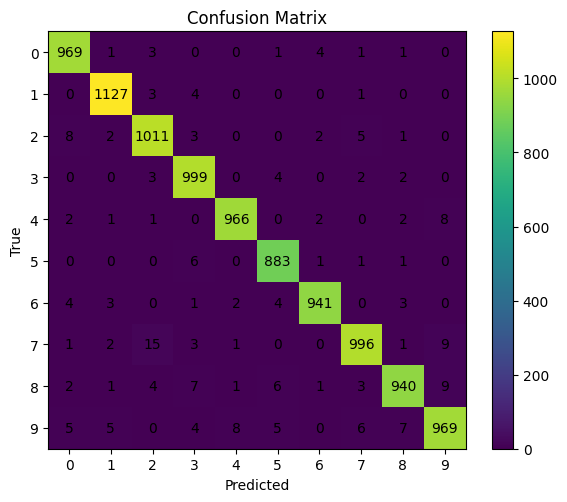

In [6]:
model.eval()
preds, targs = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)                  # only forward needs device here
        logits = model(x)                 # raw scores
        preds.append(logits.argmax(dim=1).cpu().numpy())
        targs.append(y.numpy())

y_pred = np.concatenate(preds)
y_true = np.concatenate(targs)

# Macro and per-class metrics; helpful for imbalanced data and class-wise insight
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix: rows = true, cols = predicted
cm = confusion_matrix(y_true, y_pred)

# Plot with plain matplotlib to show counts
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted"); plt.ylabel("True")

# Write the number in each cell for clarity
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

A quick grid of random test images helps spot obvious failure modes. Correct predictions are green, mistakes are red.

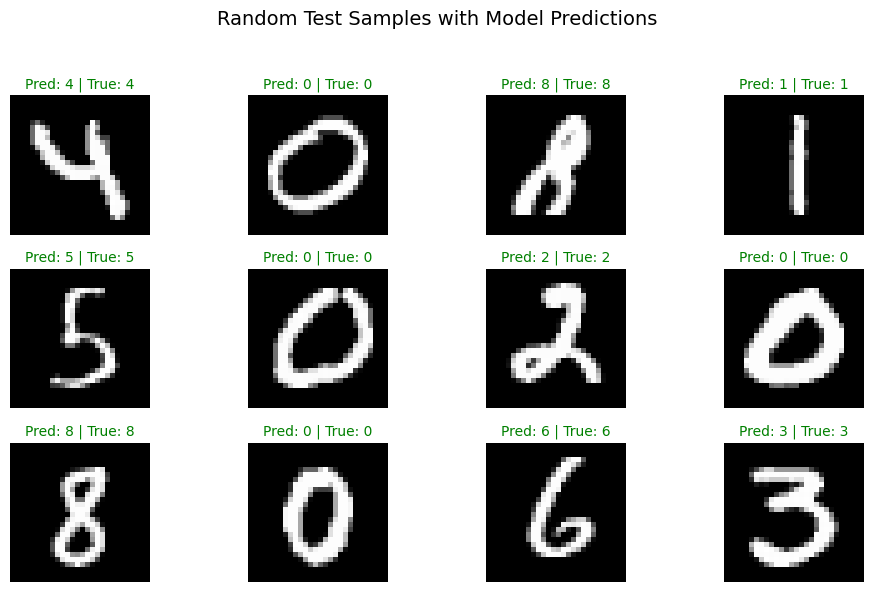

In [7]:
# Show_predictions
import random
random.seed(1)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Switch to eval mode to disable dropout etc.
model.eval()

# Pick 12 random indices from the test set
indices = random.sample(range(len(test_set)), 12)

# Prepare figure
plt.figure(figsize=(10, 6))

for i, idx in enumerate(indices):
    # Get image and ground truth
    img, label = test_set[idx]

    # Model expects batch dimension (N, C, H, W)
    x = img.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(dim=1).item()

    # Convert to numpy for display
    img_np = img.squeeze().numpy()

    # Subplot grid: 3 rows × 4 columns
    plt.subplot(3, 4, i + 1)
    plt.imshow(img_np, cmap="gray")
    # Title includes predicted and true labels
    plt.title(f"Pred: {pred} | True: {label}", color="green" if pred == label else "red", fontsize=10)
    plt.axis("off")

plt.suptitle("Random Test Samples with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 3. Crystal Image Classifier

Next we repeat the workflow on a tiny image folder that contains `crystal` vs `no-crystal` examples.

Small datasets are sensitive to overfitting, so we favor a modest CNN and careful validation. The next cell adds the extra imports used for file I/O, image handling, and plotting.

Below knobs balance speed and accuracy. `IMG_SIZE` controls input resolution. `BATCH_SIZE`, `EPOCHS`, and `LR` shape the training budget. `VAL_RATIO` holds out a slice of data for evaluation when labels are limited.

In [8]:
# setup.
# Imports, config, reproducibility

# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Dataset settings
GITHUB_API_DIR = "https://api.github.com/repos/zzhenglab/ai4chem/contents/book/_data"
DATA_DIR = "./crystal_data/images"     # local cache directory
IMG_SIZE = 200
BATCH_SIZE = 64
VAL_RATIO = 0.2
EPOCHS = 10
LR = 1e-3

Device: cpu


Below we load the image data from Github.
Labels are inferred from filename text such as `crystal_` and `nocrystal_`. The `CrystalFolder` dataset returns `(image, label)` pairs and keeps the interface consistent with torchvision datasets. If you change naming rules, adjust `infer_label`.

We resize, convert to tensor, and normalize to a roughly symmetric range. A quick class count is printed to reveal imbalance that could skew accuracy. We then split into train and test with a fixed seed so results are comparable between runs.

Optionally, we compress the `IMG_SIZE` if needed for faster training.

In [9]:
def download_from_github(out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    print("Listing GitHub folder...")
    r = requests.get(GITHUB_API_DIR, timeout=30)
    r.raise_for_status()
    items = r.json()

    kept = 0
    for it in items:
        if it.get("type") != "file":
            continue
        name = it["name"].lower()
        if not name.endswith((".png", ".jpg", ".jpeg")):
            continue
        url = it["download_url"]
        dst = os.path.join(out_dir, it["name"])
        if os.path.exists(dst):
            kept += 1
            continue
        img = requests.get(url, timeout=60)
        img.raise_for_status()
        with open(dst, "wb") as f:
            f.write(img.content)
        kept += 1
    print(f"Saved {kept} images to {out_dir}")

if not os.path.isdir(DATA_DIR) or len(os.listdir(DATA_DIR)) == 0:
    download_from_github(DATA_DIR)

# Label inference from filename prefix
CLASS_TO_IDX = {"nocrystal": 0, "crystal": 1}

def infer_label(fname: str) -> int:
    f = fname.lower()
    if f.startswith("crystal_"):
        return CLASS_TO_IDX["crystal"]
    if f.startswith("nocrystal_") or f.startswith("no_crystal_"):
        return CLASS_TO_IDX["nocrystal"]
    if "nocrystal" in f or "no_crystal" in f:
        return CLASS_TO_IDX["nocrystal"]
    if "crystal" in f:
        return CLASS_TO_IDX["crystal"]
    raise ValueError(f"Cannot infer label from: {fname}")

class CrystalFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        for fn in os.listdir(root):
            if fn.lower().endswith((".png",".jpg",".jpeg")):
                try:
                    y = infer_label(fn)
                    self.samples.append((os.path.join(root, fn), y))
                except ValueError:
                    pass
        self.samples.sort(key=lambda x: x[0])

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, y = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, y

# Transform pipeline:
# 1) resize to <=100
# 2) convert to tensor in [0,1]
# 3) normalize to [-1,1] for training stability
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

full_set = CrystalFolder(DATA_DIR, transform=tfm)

# Print full dataset counts
counts = {0:0, 1:0}
for _, y in full_set.samples: counts[y] += 1
print(f"Total images: {len(full_set)} | no-crystal(0): {counts[0]} | crystal(1): {counts[1]}")

# Split into train and test using the full set
n_test = max(1, int(len(full_set) * VAL_RATIO))
n_train = max(1, len(full_set) - n_test)
train_set, test_set = random_split(
    full_set, [n_train, n_test],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE*4, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "| Test batches:", len(test_loader))

Total images: 240 | no-crystal(0): 48 | crystal(1): 192
Train batches: 3 | Test batches: 1


Before training, view a small gallery sampled from the full set. Check that images are correctly oriented, labels look right, and normalization did not invert colors. If anything looks off, fix it now to avoid debugging the model later.

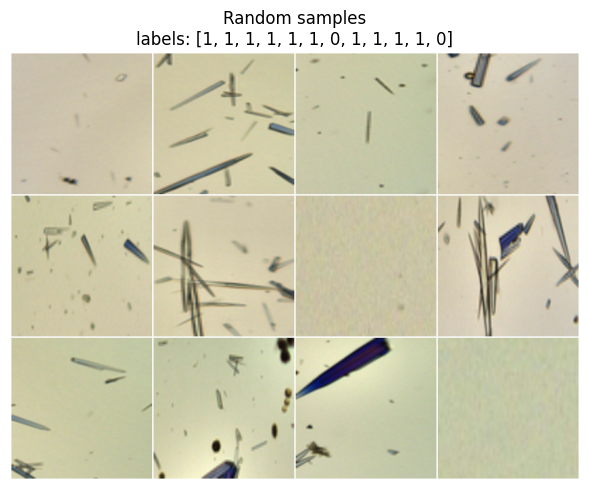

In [10]:
# Show 12 random samples from the full dataset (like your MNIST show)
def show_samples(ds, n=12):
    idxs = np.random.choice(len(ds), size=min(n, len(ds)), replace=False)
    imgs = [ds[i][0] for i in idxs]
    labels = [int(ds[i][1]) for i in idxs]
    grid = vutils.make_grid(torch.stack(imgs), nrow=4, normalize=True, pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.title(f"Random samples\nlabels: {labels}")
    plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.tight_layout()
    plt.show()

show_samples(full_set, n=12)   # 12 representative images at the beginning

Below we build CNN for this task.

Note that this CNN is intentionally compact. Two conv blocks capture local structure, then `AdaptiveAvgPool2d(6,6)` removes the dependency on input size. A small MLP head outputs two logits. The parameter count confirms that the model is light enough for a fast training loop.

In [11]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 3xH x W, any H,W >= 24
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # -> 32xH x W
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # -> 64xH x W
        self.pool  = nn.MaxPool2d(2, 2)               # halves H and W
        # Make the spatial size independent of IMG_SIZE
        self.adapt = nn.AdaptiveAvgPool2d((6, 6))     # -> 64x6x6 regardless of input
        self.drop  = nn.Dropout(0.25)
        self.fc1   = nn.Linear(64*6*6, 128)
        self.fc2   = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))          # 3xHxW -> 32xH/2 x W/2
        x = self.pool(F.relu(self.conv2(x)))          # 32x.. -> 64xH/4 x W/4
        x = self.adapt(x)                              # -> 64x6x6
        x = x.view(x.size(0), -1)                     # 2304
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

model = SmallCNN().to(device)
print("Parameter count:", f"{sum(p.numel() for p in model.parameters()):,}")

Parameter count: 314,690


The training loop mirrors MNIST. Watch both train and test losses as well as accuracy. On small datasets, a rapid drop in train loss with flat test accuracy is a sign of overfit. If that happens, try stronger augmentation, more dropout, or early stopping.

In [12]:
model = SmallCNN().to(device)
print("Params:", f"{sum(p.numel() for p in model.parameters()):,}")

epochs = EPOCHS
optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # Adam is a good default
criterion = nn.CrossEntropyLoss()                          # expects raw logits and int labels

train_losses, test_losses, test_accs = [], [], []

for epoch in range(1, epochs+1):
    # ---- Training loop ----
    model.train()                      # enable dropout and grads
    running = 0.0                      # accumulate loss*batch_size for epoch avg
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]")
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()          # clear previous gradients
        logits = model(x)              # forward pass
        loss = criterion(logits, y)    # compute loss
        loss.backward()                # backpropagate
        optimizer.step()               # update weights
        running += loss.item() * x.size(0)
        pbar.set_postfix(loss=loss.item())

    tr_loss = running / len(train_loader.dataset)
    train_losses.append(tr_loss)

    # ---- Evaluation loop (no grad) ----
    model.eval()                       # eval mode disables dropout
    te_running, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch}/{epochs} [eval]"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            te_running += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()

    te_loss = te_running / len(test_loader.dataset) if len(test_loader.dataset) else 0.0
    te_acc  = correct / total if total else 0.0
    test_losses.append(te_loss); test_accs.append(te_acc)

    print(f"Epoch {epoch}: train loss {tr_loss:.4f}  test loss {te_loss:.4f}  acc {te_acc:.4f}")

Params: 314,690


Epoch 1/10 [train]:   0%|                                                                            | 0/3 [00:00<?, ?it/s]

Epoch 1/10 [train]:   0%|                                                                            | 0/3 [00:10<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 12960, 4080) exited unexpectedly

We plot loss and accuracy over epochs to check for convergence and gaps between train and test. The saved `state_dict` in `artifacts/` allows you to reuse the trained weights later without retraining. Keep an eye on file paths if you run from different working directories.

In [ ]:
def plot_curves(train_losses, test_losses, test_accs):
    ep = range(1, len(train_losses)+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(ep, train_losses, label="train loss")
    plt.plot(ep, test_losses, label="test loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    plt.plot(ep, test_accs, label="test acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy")
    plt.tight_layout()
    plt.show()

plot_curves(train_losses, test_losses, test_accs)
torch.save(model.state_dict(), "artifacts/crystal_cnn.pt")

A grid of random test images with predicted and true labels is a fast way to judge errors. Inspect misclassified samples and ask what features might be missing. This often suggests simple fixes such as better normalization or mild augmentation.

In [ ]:
# Show_predictions: 12 random test images with model predictions
random.seed(300)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Switch to eval mode to disable dropout etc.
model.eval()

# Pick 12 random indices from the test set
indices = random.sample(range(len(test_set)), 12)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(indices):
    # Get image and ground truth
    img, label = test_set[idx]

    # Model expects (N, C, H, W)
    x = img.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(dim=1).item()

    # Convert to numpy for display
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)  # normalize to [0,1]

    # 3×4 grid
    plt.subplot(3, 4, i + 1)
    plt.imshow(img_np)
    color = "green" if pred == label else "red"
    plt.title(f"Pred: {pred} | True: {label}", color=color, fontsize=10)
    plt.axis("off")

plt.suptitle("Random Test Samples with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 4. Features the Network Learned

We visualize the first-layer filters after training. Early conv filters often resemble color blobs and edge detectors.

In [ ]:
# Access the first conv layer weights
weights = model.conv1.weight.data.clone().cpu()
weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)  # normalize to [0,1]

n_filters = min(32, weights.shape[0])
cols = 8
rows = int(np.ceil(n_filters / cols))

plt.figure(figsize=(10, 4))
for i in range(n_filters):
    f = weights[i].permute(1, 2, 0).numpy()
    plt.subplot(rows, cols, i+1)
    plt.imshow(f)
    plt.axis("off")
plt.suptitle("Learned Filters in conv1", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

Feature maps show how the network transforms an input as it moves through the layers. After conv1 you should see edge and texture responses. After conv2 you should see more abstract patterns that correlate with the target classes.

In [ ]:
# Visualize feature maps for one test sample
sample_img, _ = test_set[0]
x = sample_img.unsqueeze(0).to(device)

with torch.no_grad():
    act1 = F.relu(model.conv1(x))
    act2 = F.relu(model.conv2(model.pool(act1)))

def show_feature_maps(tensor, title, n=16):
    tensor = tensor.squeeze(0).cpu()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)
    n = min(n, tensor.shape[0])
    cols = 8
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(tensor[i], cmap="magma")
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

show_feature_maps(act1, "Feature maps after conv1")
show_feature_maps(act2, "Feature maps after conv2")

`Grad-CAM` explains a single prediction by weighting channels in a chosen conv layer with gradients of the class score. We hook into `conv2`, collect activations and gradients, then produce a heatmap that we upsample to input size. Bright areas indicate regions the model relied on for that class.

Here we first compute a Grad-CAM map for one test image and overlay it on the original. Compare the heatmap with the predicted class and the ground truth. If the model focuses on background artifacts, revise preprocessing or collect cleaner examples.

In [ ]:
# Detailed Grad-CAM for SmallCNN using conv2 as the target layer

# -----------------------------------------------------------
# Set seeds so your picks are reproducible across runs
# -----------------------------------------------------------
random.seed(0)
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)

# -----------------------------------------------------------
# Grad-CAM helper that attaches forward and backward hooks
# to a target convolutional layer (conv2 here).
# It:
#   1) Runs a forward pass and stores activations from target layer
#   2) Runs a backward pass on the chosen class score and stores grads
#   3) Averages grads over spatial dims for channel weights
#   4) Builds a ReLU-weighted sum of activations to form the CAM
#   5) Upsamples CAM to the input spatial size
# -----------------------------------------------------------
def grad_cam_for_module(model, x, target_module, target_class=None):
    """
    model: your trained SmallCNN
    x:     input tensor of shape (1, C, H, W)
    target_module: the conv module to visualize, e.g., model.conv2
    target_class:  int class index for which to compute Grad-CAM.
                   If None, use the model's predicted class.
    Returns: heatmap as a torch.Tensor of shape (H, W) in [0,1]
    """
    model.eval()

    # Storage for activations and gradients from the target module
    activations = {}
    gradients = {}

    # Forward hook: save feature maps from target module
    def fwd_hook(module, inp, out):
        # out has shape (N, C, H, W). Store detached copy for safety.
        activations["value"] = out.detach()

    # Backward hook: save gradients wrt the feature maps
    # Use register_full_backward_hook to get grad wrt module output
    def bwd_hook(module, grad_in, grad_out):
        # grad_out is a tuple. We want the gradient wrt module output
        gradients["value"] = grad_out[0].detach()

    # Register hooks
    fwd_h = target_module.register_forward_hook(fwd_hook)
    bwd_h = target_module.register_full_backward_hook(bwd_hook)

    # Forward pass
    logits = model(x)                           # (1, num_classes)
    if target_class is None:
        target_class = int(logits.argmax(dim=1).item())
    score = logits[0, target_class]             # scalar

    # Backward pass to get gradients at target layer
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=False)

    # Remove hooks
    fwd_h.remove()
    bwd_h.remove()

    # Pull stored tensors
    A = activations["value"]                    # (1, C, H_l, W_l)
    dA = gradients["value"]                     # (1, C, H_l, W_l)

    # Global average pool the gradients over spatial dimensions to get weights
    # shape: (C, 1, 1)
    weights = dA.mean(dim=(2, 3), keepdim=True)[0]  # (C,1,1)

    # Weighted sum of channels: sum_c w_c * A_c
    # Then apply ReLU as in Grad-CAM paper
    cam = (weights * A[0]).sum(dim=0)           # (H_l, W_l)
    cam = F.relu(cam)

    # Normalize CAM to [0,1]
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    # Upsample CAM from layer size to input size (H, W)
    H, W = x.shape[-2], x.shape[-1]
    cam_up = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False)
    cam_up = cam_up.squeeze(0).squeeze(0)       # (H, W), values in [0,1]
    return cam_up

# -----------------------------------------------------------
# Pick a few test samples and visualize Grad-CAM overlays
# -----------------------------------------------------------
# Expecting you already have: model, device, test_set from previous blocks


# Choose 1 example first
if len(test_set) == 0:
    print("Grad-CAM: test_set is empty. Skipping.")
else:
    idx = 1
    img, label = test_set[idx]                  # img is normalized tensor (C,H,W)
    x = img.unsqueeze(0).to(device)             # add batch dimension

    # Compute predicted class
    with torch.no_grad():
        pred = model(x).argmax(dim=1).item()

    # Build CAM for the predicted class using conv2
    heat = grad_cam_for_module(model, x, target_module=model.conv2, target_class=pred)  # shape (H,W), [0,1]

    # Convert the normalized tensor to a displayable image in [0,1]
    # Undo normalization used in 2_data.py: mean=0.5, std=0.5 -> x = (x-0.5)/0.5
    img_disp = img.clone().permute(1, 2, 0).cpu().numpy()   # H,W,C
    img_disp = (img_disp * 0.5) + 0.5                       # back to [0,1] approx

    # Plot original and CAM overlay
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title(f"Original  |  True: {label}  Pred: {pred}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_disp)
    plt.imshow(heat.cpu().numpy(), cmap="jet", alpha=0.45)  # overlay
    plt.title("Grad-CAM on conv2")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

A small grid of Grad-CAM overlays helps you see consistent attention patterns across many images. Green titles mean correct, red means incorrect. Look for systematic drift such as attention on borders or consistent focus on irrelevant structures.

In [ ]:
# -----------------------------------------------------------
# grid of 12 Grad-CAM overlays similar to your prediction grid
# -----------------------------------------------------------
def show_gradcam_grid(model, dataset, n=12):
    if len(dataset) == 0:
        print("Dataset empty. Skipping Grad-CAM grid.")
        return
    n = min(n, len(dataset))
    idxs = random.sample(range(len(dataset)), n)

    # Build figure 3x4
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        x = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x).argmax(dim=1).item()

        heat = grad_cam_for_module(model, x, target_module=model.conv2, target_class=pred)

        # To RGB [0,1]
        img_disp = img.clone().permute(1, 2, 0).cpu().numpy()
        img_disp = (img_disp * 0.5) + 0.5

        plt.subplot(3, 4, i + 1)
        plt.imshow(img_disp)
        plt.imshow(heat.cpu().numpy(), cmap="jet", alpha=0.45)
        color = "green" if pred == label else "red"
        plt.title(f"Pred {pred} | True {label}", color=color, fontsize=10)
        plt.axis("off")
    plt.suptitle("Grad-CAM overlays on 12 random test samples", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the 12-image Grad-CAM grid
show_gradcam_grid(model, test_set, n=12)

## 5. Glossary
```{glossary}

**Channel**
    Depth dimension in a feature map, e.g., 1 for grayscale, 3 for RGB.  
**Convolution (Conv)**
    Sliding filter that extracts spatial patterns.  
**Kernel / Filter**
    Learnable weights used by a conv layer.  
**Padding**
    Zeros added around edges to control output size.  
**Pooling**
    Downsampling operation that reduces spatial size.  
**Feature map** 
    Output tensor of a conv layer.  
**Receptive field**
    Region of the input that influences a unit.  
**Dropout**
    Randomly zeros activations during training to reduce overfit.  
**Logits**
    Raw, unnormalized scores before softmax.  
**Cross-entropy loss**
    Objective for multi-class classification.  
**Grad-CAM**
    Heatmap that highlights image regions that influenced a class score.  
**Adaptive AvgPool**
    
Pooling that outputs a fixed spatial size regardless of input size.
```